In [ ]:
!pip install torch torchvision torchaudio
!pip install opencv-python
!pip install scipy
!pip install scikit-image
!pip install av
!pip install six
!pip install mediapipe
!pip install ffmpeg-python
!pip install moviepy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 44.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 44.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 63.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 15.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 16.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 72.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━

In [ ]:
!pip install av
#!pip install mediapipe
!pip install ffmpeg-python

In [ ]:
import warnings
import torch
from torch import nn
import torch.nn.functional as F
import torchaudio
import torchvision
#import mediapipe as mp
import os
import cv2
import numpy as np
import numpy
import math
import json
import argparse
import copy
import logging
import six
import sys
from itertools import groupby
from IPython.display import HTML
from IPython.display import Audio, display
from base64 import b64encode
import matplotlib.pyplot as plt
from skimage import transform as tf

In [ ]:
!wget http://www.doc.ic.ac.uk/~pm4115/autoAVSR/autoavsr_demo_video.mp4 -O /content/clip.mp4

--2024-03-25 19:04:47--  http://www.doc.ic.ac.uk/~pm4115/autoAVSR/autoavsr_demo_video.mp4
Resolving www.doc.ic.ac.uk (www.doc.ic.ac.uk)... 146.169.13.6
Connecting to www.doc.ic.ac.uk (www.doc.ic.ac.uk)|146.169.13.6|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3644186 (3.5M) [video/mp4]
Saving to: ‘/content/clip.mp4’

/content/clip.mp4   100%[===================>]   3.47M  3.18MB/s    in 1.1s    

2024-03-25 19:04:48 (3.18 MB/s) - ‘/content/clip.mp4’ saved [3644186/3644186]



In [ ]:
import moviepy.editor as mpe

video = mpe.VideoFileClip("/content/clip3.mp4")
inicio = 60  # Segundos desde el inicio del video
fin = 80  # Segundos desde el inicio del video
recorte = video.subclip(inicio, fin)
recorte.write_videofile("/content/clip8.mp4")

Moviepy - Building video /content/clip6.mp4.
MoviePy - Writing audio in clip6TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /content/clip6.mp4



Moviepy - Done !
Moviepy - video ready /content/clip6.mp4


# Video

In [ ]:
def play_video(video_path, width=200):
  mp4 = open(video_path,'rb').read()
  data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
  return HTML(f"""
  <video width={width} controls>
        <source src="{data_url}" type="video/mp4">
  </video>
  """)


In [ ]:
video = torchvision.io.read_video("clip.mp4", pts_unit='sec')[0].numpy()

In [ ]:
video.shape

(178, 1080, 1920, 3)

In [ ]:
play_video("clip.mp4")

# Audio

In [ ]:
def play_audio(waveform, sample_rate):
  waveform = waveform.numpy()

  num_channels, num_frames = waveform.shape
  if num_channels == 1:
    display(Audio(waveform[0], rate=sample_rate))
  elif num_channels == 2:
    display(Audio((waveform[0], waveform[1]), rate=sample_rate))
  else:
    raise ValueError("Waveform with more than 2 channels are not supported.")

In [ ]:
waveform, sample_rate = torchaudio.load("clip.mp4", normalize=True)

In [ ]:
type(waveform),waveform.shape

(torch.Tensor, torch.Size([2, 326656]))

In [ ]:
type(sample_rate),sample_rate

(int, 44100)

In [ ]:
play_audio(waveform, sample_rate)

In [ ]:
def _plot(waveform, sample_rate, title):
  waveform = waveform.numpy()

  num_channels, num_frames = waveform.shape
  time_axis = torch.arange(0, num_frames) / sample_rate

  figure, axes = plt.subplots(num_channels, 1)
  if num_channels == 1:
    axes = [axes]
  for c in range(num_channels):
    if title == "Waveform":
      axes[c].plot(time_axis, waveform[c], linewidth=1)
      axes[c].grid(True)
    else:
      axes[c].specgram(waveform[c], Fs=sample_rate)
    if num_channels > 1:
      axes[c].set_ylabel(f'Channel {c+1}')
  figure.suptitle(title)
  plt.show(block=False)

def plot_waveform(waveform, sample_rate):
  _plot(waveform, sample_rate, title="Waveform")

def plot_specgram(waveform, sample_rate):
  _plot(waveform, sample_rate, title="Spectrogram")

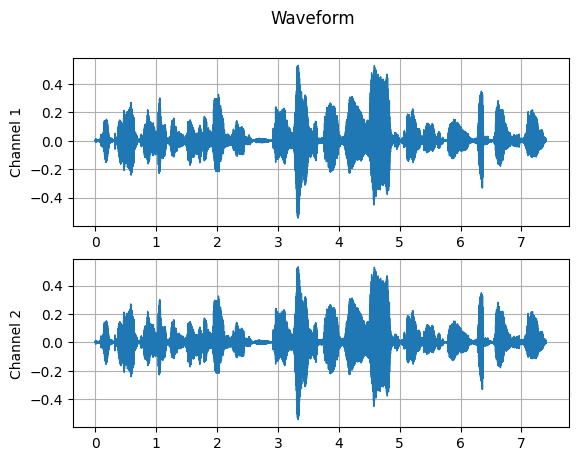

In [ ]:
plot_waveform(waveform, sample_rate)

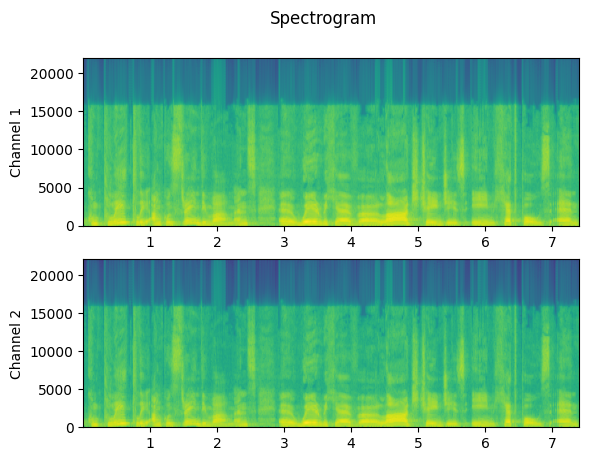

In [ ]:
plot_specgram(waveform, sample_rate)

# Preprocesamiento datos AVSR

## MediaPipe

In [ ]:
class LandmarksDetector:
    def __init__(self):
        self.mp_face_detection = mp.solutions.face_detection
        self.short_range_detector = self.mp_face_detection.FaceDetection(min_detection_confidence=0.5, model_selection=0)
        self.full_range_detector = self.mp_face_detection.FaceDetection(min_detection_confidence=0.5, model_selection=1)

    def __call__(self, filename):
        video_frames = torchvision.io.read_video(filename, pts_unit='sec')[0].numpy()
        landmarks = self.detect(video_frames, self.full_range_detector)
        if all(element is None for element in landmarks):
            landmarks = self.detect(video_frames, self.short_range_detector)
            assert any(l is not None for l in landmarks), "Cannot detect any frames in the video"
        return landmarks

    def detect(self, video_frames, detector):
        landmarks = []
        for frame in video_frames:
            results = detector.process(frame)
            if not results.detections:
                landmarks.append(None)
                continue
            face_points = []
            for idx, detected_faces in enumerate(results.detections):
                max_id, max_size = 0, 0
                bboxC = detected_faces.location_data.relative_bounding_box
                ih, iw, ic = frame.shape
                bbox = int(bboxC.xmin * iw), int(bboxC.ymin * ih), int(bboxC.width * iw), int(bboxC.height * ih)
                bbox_size = (bbox[2] - bbox[0]) + (bbox[3] - bbox[1])
                if bbox_size > max_size:
                    max_id, max_size = idx, bbox_size
                lmx = [
                    [int(detected_faces.location_data.relative_keypoints[self.mp_face_detection.FaceKeyPoint(0).value].x * iw),
                     int(detected_faces.location_data.relative_keypoints[self.mp_face_detection.FaceKeyPoint(0).value].y * ih)],
                    [int(detected_faces.location_data.relative_keypoints[self.mp_face_detection.FaceKeyPoint(1).value].x * iw),
                     int(detected_faces.location_data.relative_keypoints[self.mp_face_detection.FaceKeyPoint(1).value].y * ih)],
                    [int(detected_faces.location_data.relative_keypoints[self.mp_face_detection.FaceKeyPoint(2).value].x * iw),
                     int(detected_faces.location_data.relative_keypoints[self.mp_face_detection.FaceKeyPoint(2).value].y * ih)],
                    [int(detected_faces.location_data.relative_keypoints[self.mp_face_detection.FaceKeyPoint(3).value].x * iw),
                     int(detected_faces.location_data.relative_keypoints[self.mp_face_detection.FaceKeyPoint(3).value].y * ih)],
                    ]
                face_points.append(lmx)
            landmarks.append(np.array(face_points[max_id]))
        return landmarks

In [ ]:
#detector = LandmarksDetector()

In [ ]:
#landmarks = detector("clip.mp4")

In [ ]:
#type(landmarks),len(landmarks)

In [ ]:
#d1 = landmarks[0]

6 puento claves: ojo izquierdo, ojo derecho, nariz, boca...

In [ ]:
#d1

In [ ]:
reference = np.array([[ 70.92383848,  97.13757949],[ 72.62515288, 114.90361188],
  [ 75.98941827, 131.07402473],[ 79.26959318, 146.2116596 ],[ 83.61348894, 163.26020701],
  [ 91.33134186, 177.44535288],[100.27169245, 187.0885567 ],[112.12435016, 196.00353535],
  [130.74175801, 200.52998862],[149.8553027 , 195.31198065],[163.101687  , 186.44060881],
  [173.65334172, 176.57250158],[182.43614459, 162.27992572],[187.16738556, 145.09391978],
  [190.22905333, 129.72418731],[193.02118502, 113.45923358],[194.43863372,  95.5795392 ],
  [ 81.33095967,  80.79544511],[ 87.75906556,  75.27980275],[ 96.22692544,  73.83857497],
  [104.55524335,  74.74029382],[112.23186144,  76.97670954],[144.49576387,  76.42387471],
  [152.34799901,  73.83329748],[161.13054079,  72.63570385],[170.58715674,  73.84785054],
  [178.21409885,  79.43802857],[128.7337425 ,  95.35962566],[128.48854473, 106.92459506],
  [128.24475936, 118.27285086],[128.26596547, 127.69870727],[118.76000113, 135.19357677],
  [122.96307973, 136.14619774],[128.87017961, 137.30253356],[134.9428314 , 135.99720543],
  [139.48259748, 134.87763793],[ 92.52245553,  94.36876014],[ 97.58518219,  90.95977781],
  [105.41368273,  90.91345887],[112.77241724,  94.9436087 ],[106.103635  ,  97.08485693],
  [ 98.04628565,  97.36335869],[145.52511509,  94.53499862],[152.58953438,  90.21485666],
  [160.61170666,  90.19938514],[166.67710071,  93.56562296],[160.55971572,  96.48125958],
  [152.20465993,  96.47281336],[107.16760614, 157.19606764],[114.47611216, 152.12006957],
  [123.84852759, 148.51863199],[128.97628288, 149.41552527],[134.14360703, 148.42628211],
  [144.17717842, 151.79343262],[152.19284005, 156.98711116],[143.85966895, 164.00347101],
  [136.7441507 , 167.9430006 ],[129.15278278, 168.81853366],[121.79511074, 168.02271929],
  [115.27508573, 164.15159355],[109.23088653, 157.00172103],[122.50270762, 154.40733649],
  [129.02862236, 154.12104227],[135.83648069, 154.31214998],[150.75782809, 156.79506004],
  [135.66204627, 160.62976732],[128.95218547, 161.28762709],[122.48775432, 160.50878431]])

def linear_interpolate(landmarks, start_idx, stop_idx):
    start_landmarks = landmarks[start_idx]
    stop_landmarks = landmarks[stop_idx]
    delta = stop_landmarks - start_landmarks
    for idx in range(1, stop_idx-start_idx):
        landmarks[start_idx+idx] = start_landmarks + idx/float(stop_idx-start_idx) * delta
    return landmarks


def warp_img(src, dst, img, std_size):
    tform = tf.estimate_transform('similarity', src, dst)
    warped = tf.warp(img, inverse_map=tform.inverse, output_shape=std_size)
    warped = (warped * 255).astype('uint8')
    return warped, tform


def apply_transform(transform, img, std_size):
    warped = tf.warp(img, inverse_map=transform.inverse, output_shape=std_size)
    warped = (warped * 255).astype('uint8')
    return warped


def cut_patch(img, landmarks, height, width, threshold=5):
    center_x, center_y = np.mean(landmarks, axis=0)
    # Check for too much bias in height and width
    if abs(center_y - img.shape[0] / 2) > height + threshold:
        raise Exception('too much bias in height')
    if abs(center_x - img.shape[1] / 2) > width + threshold:
        raise Exception('too much bias in width')
    # Calculate bounding box coordinates
    y_min = int(round(np.clip(center_y - height, 0, img.shape[0])))
    y_max = int(round(np.clip(center_y + height, 0, img.shape[0])))
    x_min = int(round(np.clip(center_x - width, 0, img.shape[1])))
    x_max = int(round(np.clip(center_x + width, 0, img.shape[1])))
    # Cut the image
    cutted_img = np.copy(img[y_min:y_max, x_min:x_max])
    return cutted_img


class VideoProcess:
    def __init__(self, mean_face_path="20words_mean_face.npy", crop_width=96, crop_height=96,
                 start_idx=3, stop_idx=4, window_margin=12, convert_gray=True):
        #self.reference = np.load(os.path.join(os.path.dirname(__file__), mean_face_path))
        #self.reference = np.load(mean_face_path)
        self.reference = reference
        self.crop_width = crop_width
        self.crop_height = crop_height
        self.start_idx = start_idx
        self.stop_idx = stop_idx
        self.window_margin = window_margin
        self.convert_gray = convert_gray

    def __call__(self, video, landmarks):
        # Pre-process landmarks: interpolate frames that are not detected
        preprocessed_landmarks = self.interpolate_landmarks(landmarks)
        # Exclude corner cases: no landmark in all frames
        if not preprocessed_landmarks:
            return
        # Affine transformation and crop patch
        sequence = self.crop_patch(video, preprocessed_landmarks)
        assert sequence is not None, f"cannot crop a patch from {filename}."
        return sequence


    def crop_patch(self, video, landmarks):
        sequence = []
        for frame_idx, frame in enumerate(video):
            window_margin = min(self.window_margin // 2, frame_idx, len(landmarks) - 1 - frame_idx)
            smoothed_landmarks = np.mean([landmarks[x] for x in range(frame_idx - window_margin, frame_idx + window_margin + 1)], axis=0)
            smoothed_landmarks += landmarks[frame_idx].mean(axis=0) - smoothed_landmarks.mean(axis=0)
            transformed_frame, transformed_landmarks = self.affine_transform(frame,smoothed_landmarks,self.reference,grayscale=self.convert_gray)
            patch = cut_patch(transformed_frame, transformed_landmarks[self.start_idx:self.stop_idx], self.crop_height//2, self.crop_width//2,)
            sequence.append(patch)
        return np.array(sequence)


    def interpolate_landmarks(self, landmarks):
        valid_frames_idx = [idx for idx, lm in enumerate(landmarks) if lm is not None]

        if not valid_frames_idx:
            return None

        for idx in range(1, len(valid_frames_idx)):
            if valid_frames_idx[idx] - valid_frames_idx[idx - 1] > 1:
                landmarks = linear_interpolate(landmarks, valid_frames_idx[idx - 1], valid_frames_idx[idx])

        valid_frames_idx = [idx for idx, lm in enumerate(landmarks) if lm is not None]

        # Handle corner case: keep frames at the beginning or at the end that failed to be detected
        if valid_frames_idx:
            landmarks[:valid_frames_idx[0]] = [landmarks[valid_frames_idx[0]]] * valid_frames_idx[0]
            landmarks[valid_frames_idx[-1]:] = [landmarks[valid_frames_idx[-1]]] * (len(landmarks) - valid_frames_idx[-1])

        assert all(lm is not None for lm in landmarks), "not every frame has landmark"

        return landmarks


    def affine_transform(self, frame, landmarks, reference, grayscale=False,
                         target_size=(256, 256), reference_size=(256, 256), stable_points=(0, 1, 2, 3),
                         interpolation=cv2.INTER_LINEAR, border_mode=cv2.BORDER_CONSTANT, border_value=0):
        if grayscale:
            frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
        stable_reference = self.get_stable_reference(reference, reference_size, target_size)
        transform = self.estimate_affine_transform(landmarks, stable_points, stable_reference)
        transformed_frame, transformed_landmarks = self.apply_affine_transform(frame, landmarks, transform, target_size, interpolation, border_mode, border_value)

        return transformed_frame, transformed_landmarks


    def get_stable_reference(self, reference, reference_size, target_size):
        # -- right eye, left eye, nose tip, mouth center
        stable_reference = np.vstack([
            np.mean(reference[36:42], axis=0),
            np.mean(reference[42:48], axis=0),
            np.mean(reference[31:36], axis=0),
            np.mean(reference[48:68], axis=0)
        ])
        stable_reference[:, 0] -= (reference_size[0] - target_size[0]) / 2.0
        stable_reference[:, 1] -= (reference_size[1] - target_size[1]) / 2.0
        return stable_reference


    def estimate_affine_transform(self, landmarks, stable_points, stable_reference):
        return cv2.estimateAffinePartial2D(np.vstack([landmarks[x] for x in stable_points]), stable_reference, method=cv2.LMEDS)[0]


    def apply_affine_transform(self, frame, landmarks, transform, target_size, interpolation, border_mode, border_value):
        transformed_frame = cv2.warpAffine(frame, transform, dsize=(target_size[0], target_size[1]),
                                           flags=interpolation, borderMode=border_mode, borderValue=border_value)
        transformed_landmarks = np.matmul(landmarks, transform[:, :2].transpose()) + transform[:, 2].transpose()
        return transformed_frame, transformed_landmarks

In [ ]:
# video_process = VideoProcess(convert_gray=False)

In [ ]:
# video_recortado = video_process(video, landmarks)

In [ ]:
# type(video_recortado), video_recortado.shape

## RetinaFace and FAN

In [ ]:
!git clone https://github.com/hhj1897/face_alignment.git
!git clone https://github.com/hhj1897/face_detection.git

Cloning into 'face_alignment'...
remote: Enumerating objects: 190, done.
remote: Counting objects: 100% (32/32), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 190 (delta 27), reused 27 (delta 26), pack-reused 158
Receiving objects: 100% (190/190), 213.82 MiB | 15.46 MiB/s, done.
Resolving deltas: 100% (84/84), done.
Updating files: 100% (14/14), done.
Cloning into 'face_detection'...
remote: Enumerating objects: 300, done.
remote: Counting objects: 100% (50/50), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 300 (delta 41), reused 39 (delta 39), pack-reused 250
Receiving objects: 100% (300/300), 81.19 MiB | 16.12 MiB/s, done.
Resolving deltas: 100% (141/141), done.
Updating files: 100% (27/27), done.


In [ ]:
from face_detection.ibug.face_detection import RetinaFacePredictor
from face_alignment.ibug.face_alignment import FANPredictor

In [ ]:
class LandmarksDetector:
    def __init__(self, device="cuda:0", model_name='resnet50'):
        self.face_detector = RetinaFacePredictor(
            device=device,
            threshold=0.8,
            model=RetinaFacePredictor.get_model(model_name)
        )
        self.landmark_detector = FANPredictor(device=device, model=None)

    def __call__(self, filename):
        video_frames = torchvision.io.read_video(filename, pts_unit='sec')[0].numpy()
        landmarks = []
        for frame in video_frames:
            detected_faces = self.face_detector(frame, rgb=False)
            face_points, _ = self.landmark_detector(frame, detected_faces, rgb=True)
            if len(detected_faces) == 0:
                landmarks.append(None)
            else:
                max_id, max_size = 0, 0
                for idx, bbox in enumerate(detected_faces):
                    bbox_size = (bbox[2] - bbox[0]) + (bbox[3] - bbox[1])
                    if bbox_size > max_size:
                        max_id, max_size = idx, bbox_size
                landmarks.append(face_points[max_id])
        return landmarks

In [ ]:
detector = LandmarksDetector()

In [ ]:
landmarks = detector("clip.mp4")

In [ ]:
type(landmarks),len(landmarks)

(list, 178)

In [ ]:
d1 = landmarks[0]

In [ ]:
d1.shape

(68, 2)

In [ ]:
reference = np.array([[ 70.92383848,  97.13757949],[ 72.62515288, 114.90361188],
  [ 75.98941827, 131.07402473],[ 79.26959318, 146.2116596 ],[ 83.61348894, 163.26020701],
  [ 91.33134186, 177.44535288],[100.27169245, 187.0885567 ],[112.12435016, 196.00353535],
  [130.74175801, 200.52998862],[149.8553027 , 195.31198065],[163.101687  , 186.44060881],
  [173.65334172, 176.57250158],[182.43614459, 162.27992572],[187.16738556, 145.09391978],
  [190.22905333, 129.72418731],[193.02118502, 113.45923358],[194.43863372,  95.5795392 ],
  [ 81.33095967,  80.79544511],[ 87.75906556,  75.27980275],[ 96.22692544,  73.83857497],
  [104.55524335,  74.74029382],[112.23186144,  76.97670954],[144.49576387,  76.42387471],
  [152.34799901,  73.83329748],[161.13054079,  72.63570385],[170.58715674,  73.84785054],
  [178.21409885,  79.43802857],[128.7337425 ,  95.35962566],[128.48854473, 106.92459506],
  [128.24475936, 118.27285086],[128.26596547, 127.69870727],[118.76000113, 135.19357677],
  [122.96307973, 136.14619774],[128.87017961, 137.30253356],[134.9428314 , 135.99720543],
  [139.48259748, 134.87763793],[ 92.52245553,  94.36876014],[ 97.58518219,  90.95977781],
  [105.41368273,  90.91345887],[112.77241724,  94.9436087 ],[106.103635  ,  97.08485693],
  [ 98.04628565,  97.36335869],[145.52511509,  94.53499862],[152.58953438,  90.21485666],
  [160.61170666,  90.19938514],[166.67710071,  93.56562296],[160.55971572,  96.48125958],
  [152.20465993,  96.47281336],[107.16760614, 157.19606764],[114.47611216, 152.12006957],
  [123.84852759, 148.51863199],[128.97628288, 149.41552527],[134.14360703, 148.42628211],
  [144.17717842, 151.79343262],[152.19284005, 156.98711116],[143.85966895, 164.00347101],
  [136.7441507 , 167.9430006 ],[129.15278278, 168.81853366],[121.79511074, 168.02271929],
  [115.27508573, 164.15159355],[109.23088653, 157.00172103],[122.50270762, 154.40733649],
  [129.02862236, 154.12104227],[135.83648069, 154.31214998],[150.75782809, 156.79506004],
  [135.66204627, 160.62976732],[128.95218547, 161.28762709],[122.48775432, 160.50878431]])


def linear_interpolate(landmarks, start_idx, stop_idx):
    start_landmarks = landmarks[start_idx]
    stop_landmarks = landmarks[stop_idx]
    delta = stop_landmarks - start_landmarks
    for idx in range(1, stop_idx-start_idx):
        landmarks[start_idx+idx] = start_landmarks + idx/float(stop_idx-start_idx) * delta
    return landmarks


def warp_img(src, dst, img, std_size):
    tform = tf.estimate_transform('similarity', src, dst)
    warped = tf.warp(img, inverse_map=tform.inverse, output_shape=std_size)
    warped = (warped * 255).astype('uint8')
    return warped, tform


def apply_transform(transform, img, std_size):
    warped = tf.warp(img, inverse_map=transform.inverse, output_shape=std_size)
    warped = (warped * 255).astype('uint8')
    return warped


def cut_patch(img, landmarks, height, width, threshold=5):
    center_x, center_y = np.mean(landmarks, axis=0)
    # Check for too much bias in height and width
    if abs(center_y - img.shape[0] / 2) > height + threshold:
        raise Exception('too much bias in height')
    if abs(center_x - img.shape[1] / 2) > width + threshold:
        raise Exception('too much bias in width')
    # Calculate bounding box coordinates
    y_min = int(round(np.clip(center_y - height, 0, img.shape[0])))
    y_max = int(round(np.clip(center_y + height, 0, img.shape[0])))
    x_min = int(round(np.clip(center_x - width, 0, img.shape[1])))
    x_max = int(round(np.clip(center_x + width, 0, img.shape[1])))
    # Cut the image
    cutted_img = np.copy(img[y_min:y_max, x_min:x_max])
    return cutted_img


class VideoProcess:
    def __init__(self, mean_face_path="20words_mean_face.npy", crop_width=96, crop_height=96,
                 start_idx=48, stop_idx=68, window_margin=12, convert_gray=True):
        #self.reference = np.load(os.path.join(os.path.dirname(__file__), mean_face_path))
        self.reference = reference
        self.crop_width = crop_width
        self.crop_height = crop_height
        self.start_idx = start_idx
        self.stop_idx = stop_idx
        self.window_margin = window_margin
        self.convert_gray = convert_gray

    def __call__(self, video, landmarks):
        # Pre-process landmarks: interpolate frames that are not detected
        preprocessed_landmarks = self.interpolate_landmarks(landmarks)
        # Exclude corner cases: no landmark in all frames or number of frames is less than window length
        if not preprocessed_landmarks or len(preprocessed_landmarks) < self.window_margin:
            return
        # Affine transformation and crop patch
        sequence = self.crop_patch(video, preprocessed_landmarks)
        assert sequence is not None, f"cannot crop a patch from {filename}."
        return sequence


    def crop_patch(self, video, landmarks):
        sequence = []
        for frame_idx, frame in enumerate(video):
            window_margin = min(self.window_margin // 2, frame_idx, len(landmarks) - 1 - frame_idx)
            smoothed_landmarks = np.mean([landmarks[x] for x in range(frame_idx - window_margin, frame_idx + window_margin + 1)], axis=0)
            smoothed_landmarks += landmarks[frame_idx].mean(axis=0) - smoothed_landmarks.mean(axis=0)
            transformed_frame, transformed_landmarks = self.affine_transform(frame,smoothed_landmarks,self.reference,grayscale=self.convert_gray)
            patch = cut_patch(transformed_frame, transformed_landmarks[self.start_idx:self.stop_idx], self.crop_height//2, self.crop_width//2,)
            sequence.append(patch)
        return np.array(sequence)


    def interpolate_landmarks(self, landmarks):
        valid_frames_idx = [idx for idx, lm in enumerate(landmarks) if lm is not None]

        if not valid_frames_idx:
            return None

        for idx in range(1, len(valid_frames_idx)):
            if valid_frames_idx[idx] - valid_frames_idx[idx - 1] > 1:
                landmarks = linear_interpolate(landmarks, valid_frames_idx[idx - 1], valid_frames_idx[idx])

        valid_frames_idx = [idx for idx, lm in enumerate(landmarks) if lm is not None]

        # Handle corner case: keep frames at the beginning or at the end that failed to be detected
        if valid_frames_idx:
            landmarks[:valid_frames_idx[0]] = [landmarks[valid_frames_idx[0]]] * valid_frames_idx[0]
            landmarks[valid_frames_idx[-1]:] = [landmarks[valid_frames_idx[-1]]] * (len(landmarks) - valid_frames_idx[-1])

        assert all(lm is not None for lm in landmarks), "not every frame has landmark"

        return landmarks


    def affine_transform(self, frame, landmarks, reference, grayscale=True,
                         target_size=(256, 256), reference_size=(256, 256), stable_points=(28, 33, 36, 39, 42, 45, 48, 54),
                         interpolation=cv2.INTER_LINEAR, border_mode=cv2.BORDER_CONSTANT, border_value=0):
        if grayscale:
            frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
        stable_reference = self.get_stable_reference(reference, stable_points, reference_size, target_size)
        transform = self.estimate_affine_transform(landmarks, stable_points, stable_reference)
        transformed_frame, transformed_landmarks = self.apply_affine_transform(frame, landmarks, transform, target_size, interpolation, border_mode, border_value)

        return transformed_frame, transformed_landmarks


    def get_stable_reference(self, reference, stable_points, reference_size, target_size):
        stable_reference = np.vstack([reference[x] for x in stable_points])
        stable_reference[:, 0] -= (reference_size[0] - target_size[0]) / 2.0
        stable_reference[:, 1] -= (reference_size[1] - target_size[1]) / 2.0
        return stable_reference


    def estimate_affine_transform(self, landmarks, stable_points, stable_reference):
        return cv2.estimateAffinePartial2D(np.vstack([landmarks[x] for x in stable_points]), stable_reference, method=cv2.LMEDS)[0]


    def apply_affine_transform(self, frame, landmarks, transform, target_size, interpolation, border_mode, border_value):
        transformed_frame = cv2.warpAffine(frame, transform, dsize=(target_size[0], target_size[1]),
                                           flags=interpolation, borderMode=border_mode, borderValue=border_value)
        transformed_landmarks = np.matmul(landmarks, transform[:, :2].transpose()) + transform[:, 2].transpose()
        return transformed_frame, transformed_landmarks

In [ ]:
video_process = VideoProcess(convert_gray=False)

In [ ]:
video_recortado = video_process(video, landmarks)

In [ ]:
type(video_recortado), video_recortado.shape

(numpy.ndarray, (178, 96, 96, 3))

## Transformacion

In [ ]:
class FunctionalModule(torch.nn.Module):
    def __init__(self, functional):
        super().__init__()
        self.functional = functional

    def forward(self, input):
        return self.functional(input)


class VideoTransform:
    def __init__(self, speed_rate):
        self.video_pipeline = torch.nn.Sequential(
            FunctionalModule(lambda x: x.unsqueeze(-1)),
            FunctionalModule(lambda x: x if speed_rate == 1 else torch.index_select(x, dim=0, index=torch.linspace(0, x.shape[0]-1, int(x.shape[0] / speed_rate), dtype=torch.int64))),
            FunctionalModule(lambda x: x.permute(3, 0, 1, 2)),
            FunctionalModule(lambda x: x / 255.),
            torchvision.transforms.CenterCrop(88),
            torchvision.transforms.Normalize(0.421, 0.165),
        )

    def __call__(self, sample):
        return self.video_pipeline(sample)


class AudioTransform:
    def __init__(self):
        self.audio_pipeline = torch.nn.Sequential(
            FunctionalModule(lambda x: torch.nn.functional.layer_norm(x, x.shape, eps=0)),
            FunctionalModule(lambda x: x.transpose(0, 1)),
        )

    def __call__(self, sample):
        return self.audio_pipeline(sample)

# Dataloader

In [ ]:
class AVSRDataLoader:
    def __init__(self, modality, speed_rate=1, transform=True, detector="retinaface", convert_gray=True):
        self.modality = modality
        self.transform = transform
        if self.modality in ["audio", "audiovisual"]:
            self.audio_transform = AudioTransform()
        if self.modality in ["video", "audiovisual"]:
            if detector == "mediapipe":
                #from pipelines.detectors.mediapipe.video_process import VideoProcess
                self.video_process = VideoProcess(convert_gray=convert_gray)
            if detector == "retinaface":
                #from pipelines.detectors.retinaface.video_process import VideoProcess
                self.video_process = VideoProcess(convert_gray=convert_gray)
            self.video_transform = VideoTransform(speed_rate=speed_rate)


    def load_data(self, data_filename, landmarks=None, transform=True):
        if self.modality == "audio":
            audio, sample_rate = self.load_audio(data_filename)
            audio = self.audio_process(audio, sample_rate)
            return self.audio_transform(audio) if self.transform else audio
        if self.modality == "video":
            video = self.load_video(data_filename)
            video = self.video_process(video, landmarks)
            video = torch.tensor(video)
            return self.video_transform(video) if self.transform else video
        if self.modality == "audiovisual":
            rate_ratio = 640
            #audio
            audio, sample_rate = self.load_audio(data_filename)
            audio = self.audio_process(audio, sample_rate)
            #video
            video = self.load_video(data_filename)
            video = self.video_process(video, landmarks)
            video = torch.tensor(video)
            min_t = min(len(video), audio.size(1) // rate_ratio)
            audio = audio[:, :min_t*rate_ratio]
            video = video[:min_t]
            if self.transform:
                audio = self.audio_transform(audio)
                video = self.video_transform(video)
            return video, audio


    def load_audio(self, data_filename):
        waveform, sample_rate = torchaudio.load(data_filename, normalize=True)
        return waveform, sample_rate


    def load_video(self, data_filename):
        return torchvision.io.read_video(data_filename, pts_unit='sec')[0].numpy()


    def audio_process(self, waveform, sample_rate, target_sample_rate=16000):
        if sample_rate != target_sample_rate:
            waveform = torchaudio.functional.resample(waveform, sample_rate, target_sample_rate)
        waveform = torch.mean(waveform, dim=0, keepdim=True)
        return waveform

## Prueva video

In [ ]:
landmarks_detector = LandmarksDetector()

In [ ]:
video_pro = VideoProcess(convert_gray=True)

In [ ]:
video = torchvision.io.read_video("clip4.mp4", pts_unit='sec')[0].numpy()

RuntimeError: File not found: clip4.mp4

In [ ]:
landmarks = landmarks_detector("clip4.mp4")

In [ ]:
tensor = video_pro(video, landmarks)

In [ ]:
tensor.shape

# Obteniendo solo video

In [ ]:
def save2vid(filename, vid, frames_per_second):
    os.makedirs(os.path.dirname(filename), exist_ok=True)
    torchvision.io.write_video(filename, vid, frames_per_second)

def preprocess_video(src_filename, dst_filename):
    landmarks = landmarks_detector(src_filename)
    data = dataloader.load_data(src_filename, landmarks)
    fps = cv2.VideoCapture(src_filename).get(cv2.CAP_PROP_FPS)
    save2vid(dst_filename, data, fps)
    return

dataloader = AVSRDataLoader(modality="video", speed_rate=1, transform=False, detector="retinaface", convert_gray=False)
landmarks_detector = LandmarksDetector()

In [ ]:
preprocess_video(src_filename="clip.mp4", dst_filename="/content/roi.mp4")

In [ ]:
play_video("roi.mp4")

# Obteniendo audio y video

In [ ]:
# Sin transformacion y a colores, util para visualizar
dataloader = AVSRDataLoader(modality="audiovisual", speed_rate=1, transform=False, detector="retinaface", convert_gray=False)
landmarks_detector = LandmarksDetector()
landmarks = landmarks_detector("clip.mp4")
video, audio = dataloader.load_data("clip.mp4", landmarks)

In [ ]:
video.shape, audio.shape

(torch.Size([178, 96, 96, 3]), torch.Size([1, 113920]))

In [ ]:
dataloader = AVSRDataLoader(modality="audiovisual", speed_rate=1, transform=True, detector="mediapipe", convert_gray=True)
landmarks_detector = LandmarksDetector()
landmarks = landmarks_detector("clip.mp4")
video, audio = dataloader.load_data("clip.mp4", landmarks)

In [ ]:
video.shape, audio.shape

(torch.Size([1, 178, 88, 88]), torch.Size([113920, 1]))

# Grabar video

In [ ]:
import cv2
from google.colab.patches import cv2_imshow

# Función para capturar video desde la cámara
def capturar_video():
    cap = cv2.VideoCapture(0)  # 0 para la cámara predeterminada

    while(True):
        # Captura fotograma por fotograma
        ret, frame = cap.read()

        if ret:  # Verifica si el fotograma se capturó correctamente
            # Muestra el fotograma
            cv2_imshow(frame)

            # Rompe el bucle si se presiona 'q'
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break

    # Libera la cámara y cierra la ventana
    cap.release()
    cv2.destroyAllWindows()

# Llama a la función para capturar video
capturar_video()

KeyboardInterrupt: 

In [ ]:
!pip install opencv-python
!pip install imageai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.8/69.8 kB 3.2 MB/s eta 0:00:00


In [ ]:
import cv2
from imageai.OpenCV import VideoCamera

ModuleNotFoundError: No module named 'imageai.OpenCV'

# Espnet

In [ ]:
!pip install espnet

In [ ]:
!pip show aspnet

In [ ]:
!git clone https://github.com/espnet/espnet.git

Cloning into 'espnet'...
remote: Enumerating objects: 257564, done.
remote: Counting objects: 100% (907/907), done.
remote: Compressing objects: 100% (386/386), done.
remote: Total 257564 (delta 639), reused 698 (delta 509), pack-reused 256657
Receiving objects: 100% (257564/257564), 927.67 MiB | 20.20 MiB/s, done.
Resolving deltas: 100% (188644/188644), done.


In [ ]:
%cd "/content/espnet"

/content/espnet


In [ ]:
!pip install chainer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 10.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for chainer: filename=chainer-7.8.1-py3-none-any.whl size=967716 sha256=7913fcd36388e1e120741fa813c8e0897e3dde37a32730cdaa82ae26f3cc9261
  Stored in directory: /root/.cache/pip/wheels/c4/95/6a/16014db6f761c4e742755b64aac60dbe142da1df6c5919f790
Successfully built chainer


In [ ]:
from espnet.nets.pytorch_backend.e2e_asr_transformer import E2E

In [ ]:
E2E

espnet.nets.pytorch_backend.e2e_asr_transformer.E2E

# Contruir E2E

## RelPositionalEncoding

In [ ]:
class RelPositionalEncoding(torch.nn.Module):
    """Relative positional encoding module (new implementation).
    Details can be found in https://github.com/espnet/espnet/pull/2816.
    See : Appendix B in https://arxiv.org/abs/1901.02860
    Args:
        d_model (int): Embedding dimension.
        dropout_rate (float): Dropout rate.
        max_len (int): Maximum input length.
    """

    def __init__(self, d_model, dropout_rate, max_len=5000):
        """Construct an PositionalEncoding object."""
        super(RelPositionalEncoding, self).__init__()
        self.d_model = d_model
        self.xscale = math.sqrt(self.d_model)
        self.dropout = torch.nn.Dropout(p=dropout_rate)
        self.pe = None
        self.extend_pe(torch.tensor(0.0).expand(1, max_len))

    def extend_pe(self, x):
        """Reset the positional encodings."""
        if self.pe is not None:
            # self.pe contains both positive and negative parts
            # the length of self.pe is 2 * input_len - 1
            if self.pe.size(1) >= x.size(1) * 2 - 1:
                if self.pe.dtype != x.dtype or self.pe.device != x.device:
                    self.pe = self.pe.to(dtype=x.dtype, device=x.device)
                return
        # Suppose `i` means to the position of query vecotr and `j` means the
        # position of key vector. We use position relative positions when keys
        # are to the left (i>j) and negative relative positions otherwise (i<j).
        pe_positive = torch.zeros(x.size(1), self.d_model)
        pe_negative = torch.zeros(x.size(1), self.d_model)
        position = torch.arange(0, x.size(1), dtype=torch.float32).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, self.d_model, 2, dtype=torch.float32)
            * -(math.log(10000.0) / self.d_model)
        )
        pe_positive[:, 0::2] = torch.sin(position * div_term)
        pe_positive[:, 1::2] = torch.cos(position * div_term)
        pe_negative[:, 0::2] = torch.sin(-1 * position * div_term)
        pe_negative[:, 1::2] = torch.cos(-1 * position * div_term)

        # Reserve the order of positive indices and concat both positive and
        # negative indices. This is used to support the shifting trick
        # as in https://arxiv.org/abs/1901.02860
        pe_positive = torch.flip(pe_positive, [0]).unsqueeze(0)
        pe_negative = pe_negative[1:].unsqueeze(0)
        pe = torch.cat([pe_positive, pe_negative], dim=1)
        self.pe = pe.to(device=x.device, dtype=x.dtype)

    def forward(self, x: torch.Tensor):
        """Add positional encoding.
        Args:
            x (torch.Tensor): Input tensor (batch, time, `*`).
        Returns:
            torch.Tensor: Encoded tensor (batch, time, `*`).
        """
        self.extend_pe(x)
        x = x * self.xscale
        pos_emb = self.pe[
            :,
            self.pe.size(1) // 2 - x.size(1) + 1 : self.pe.size(1) // 2 + x.size(1),
        ]
        return self.dropout(x), self.dropout(pos_emb)

In [ ]:
# re_emb = RelPositionalEncoding(256, 0.1)

In [ ]:
# y_re_emb = re_emb(torch.rand(32,))

## Swish

In [ ]:
class Swish(nn.Module):
    """Construct an Swish object."""

    def forward(self, x):
        """Return Swich activation function."""
        return x * torch.sigmoid(x)

## ResNet 2D

In [ ]:
def conv3x3(in_planes, out_planes, stride=1):
    """conv3x3.

    :param in_planes: int, number of channels in the input sequence.
    :param out_planes: int,  number of channels produced by the convolution.
    :param stride: int, size of the convolving kernel.
    """
    return nn.Conv2d(
        in_planes,
        out_planes,
        kernel_size=3,
        stride=stride,
        padding=1,
        bias=False,
    )


def downsample_basic_block(inplanes, outplanes, stride):
    """downsample_basic_block.

    :param inplanes: int, number of channels in the input sequence.
    :param outplanes: int, number of channels produced by the convolution.
    :param stride: int, size of the convolving kernel.
    """
    return  nn.Sequential(
        nn.Conv2d(
            inplanes,
            outplanes,
            kernel_size=1,
            stride=stride,
            bias=False,
            ),
        nn.BatchNorm2d(outplanes),
    )


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(
        self,
        inplanes,
        planes,
        stride=1,
        downsample=None,
        relu_type="swish",
    ):
        """__init__.

        :param inplanes: int, number of channels in the input sequence.
        :param planes: int,  number of channels produced by the convolution.
        :param stride: int, size of the convolving kernel.
        :param downsample: boolean, if True, the temporal resolution is downsampled.
        :param relu_type: str, type of activation function.
        """
        super(BasicBlock, self).__init__()

        assert relu_type in ["relu", "prelu", "swish"]

        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)

        if relu_type == "relu":
            self.relu1 = nn.ReLU(inplace=True)
            self.relu2 = nn.ReLU(inplace=True)
        elif relu_type == "prelu":
            self.relu1 = nn.PReLU(num_parameters=planes)
            self.relu2 = nn.PReLU(num_parameters=planes)
        elif relu_type == "swish":
            self.relu1 = Swish()
            self.relu2 = Swish()
        else:
            raise NotImplementedError
        # --------

        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)

        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        """forward.

        :param x: torch.Tensor, input tensor with input size (B, C, T, H, W).
        """
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu1(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu2(out)

        return out


class ResNet(nn.Module):

    def __init__(
        self,
        block,
        layers,
        relu_type="swish",
    ):
        super(ResNet, self).__init__()
        self.inplanes = 64
        self.relu_type = relu_type
        self.downsample_block = downsample_basic_block

        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d(1)


    def _make_layer(self, block, planes, blocks, stride=1):
        """_make_layer.

        :param block: torch.nn.Module, class of blocks.
        :param planes: int,  number of channels produced by the convolution.
        :param blocks: int, number of layers in a block.
        :param stride: int, size of the convolving kernel.
        """
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = self.downsample_block(
                inplanes=self.inplanes,
                outplanes=planes*block.expansion,
                stride=stride,
            )

        layers = []
        layers.append(
            block(
                self.inplanes,
                planes,
                stride,
                downsample,
                relu_type=self.relu_type,
            )
        )
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(
                block(
                    self.inplanes,
                    planes,
                    relu_type=self.relu_type,
                )
            )

        return nn.Sequential(*layers)

    def forward(self, x):
        """forward.

        :param x: torch.Tensor, input tensor with input size (B, C, T, H, W).
        """
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        return x

## ResNet 1D

In [ ]:
def conv3x31D(in_planes, out_planes, stride=1):
    """conv3x3.

    :param in_planes: int, number of channels in the input sequence.
    :param out_planes: int,  number of channels produced by the convolution.
    :param stride: int, size of the convolving kernel.
    """
    return nn.Conv1d(
        in_planes,
        out_planes,
        kernel_size=3,
        stride=stride,
        padding=1,
        bias=False,
    )


def downsample_basic_block_1d(inplanes, outplanes, stride):
    """downsample_basic_block.

    :param inplanes: int, number of channels in the input sequence.
    :param outplanes: int, number of channels produced by the convolution.
    :param stride: int, size of the convolving kernel.
    """
    return  nn.Sequential(
        nn.Conv1d(
            inplanes,
            outplanes,
            kernel_size=1,
            stride=stride,
            bias=False,
        ),
        nn.BatchNorm1d(outplanes),
    )


class BasicBlock1D(nn.Module):
    expansion = 1

    def __init__(
        self,
        inplanes,
        planes,
        stride=1,
        downsample=None,
        relu_type="relu",
    ):
        """__init__.

        :param inplanes: int, number of channels in the input sequence.
        :param planes: int,  number of channels produced by the convolution.
        :param stride: int, size of the convolving kernel.
        :param downsample: boolean, if True, the temporal resolution is downsampled.
        :param relu_type: str, type of activation function.
        """
        super(BasicBlock1D, self).__init__()

        assert relu_type in ["relu","prelu", "swish"]

        self.conv1 = conv3x31D(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm1d(planes)

        # type of ReLU is an input option
        if relu_type == "relu":
            self.relu1 = nn.ReLU(inplace=True)
            self.relu2 = nn.ReLU(inplace=True)
        elif relu_type == "prelu":
            self.relu1 = nn.PReLU(num_parameters=planes)
            self.relu2 = nn.PReLU(num_parameters=planes)
        elif relu_type == "swish":
            self.relu1 = Swish()
            self.relu2 = Swish()
        else:
            raise NotImplementedError
        # --------

        self.conv2 = conv3x31D(planes, planes)
        self.bn2 = nn.BatchNorm1d(planes)

        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        """forward.

        :param x: torch.Tensor, input tensor with input size (B, C, T)
        """
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu1(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu2(out)

        return out


class ResNet1D(nn.Module):

    def __init__(self,
        block,
        layers,
        relu_type="swish",
        a_upsample_ratio=1,
    ):
        """__init__.

        :param block: torch.nn.Module, class of blocks.
        :param layers: List, customised layers in each block.
        :param relu_type: str, type of activation function.
        :param a_upsample_ratio: int, The ratio related to the \
            temporal resolution of output features of the frontend. \
            a_upsample_ratio=1 produce features with a fps of 25.
        """
        super(ResNet1D, self).__init__()
        self.inplanes = 64
        self.relu_type = relu_type
        self.downsample_block = downsample_basic_block_1d
        self.a_upsample_ratio = a_upsample_ratio

        self.conv1 = nn.Conv1d(
            in_channels=1,
            out_channels=self.inplanes,
            kernel_size=80,
            stride=4,
            padding=38,
            bias=False,
        )
        self.bn1 = nn.BatchNorm1d(self.inplanes)

        if relu_type == "relu":
            self.relu = nn.ReLU(inplace=True)
        elif relu_type == "prelu":
            self.relu = nn.PReLU(num_parameters=self.inplanes)
        elif relu_type == "swish":
            self.relu = Swish()

        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AvgPool1d(
            kernel_size=20//self.a_upsample_ratio,
            stride=20//self.a_upsample_ratio,
        )


    def _make_layer(self, block, planes, blocks, stride=1):
        """_make_layer.

        :param block: torch.nn.Module, class of blocks.
        :param planes: int,  number of channels produced by the convolution.
        :param blocks: int, number of layers in a block.
        :param stride: int, size of the convolving kernel.
        """

        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = self.downsample_block(
                inplanes=self.inplanes,
                outplanes=planes*block.expansion,
                stride=stride,
            )

        layers = []
        layers.append(
            block(
                self.inplanes,
                planes,
                stride,
                downsample,
                relu_type=self.relu_type,
            )
        )
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(
                block(
                    self.inplanes,
                    planes,
                    relu_type=self.relu_type,
                )
            )

        return nn.Sequential(*layers)

    def forward(self, x):
        """forward.

        :param x: torch.Tensor, input tensor with input size (B, C, T)
        """
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        return x

## Conv3dResNet

In [ ]:
def threeD_to_2D_tensor(x):
    n_batch, n_channels, s_time, sx, sy = x.shape
    x = x.transpose(1, 2)
    return x.reshape(n_batch * s_time, n_channels, sx, sy)

class Conv3dResNet(torch.nn.Module):
    """Conv3dResNet module
    """

    def __init__(self, backbone_type="resnet", relu_type="swish"):
        """__init__.

        :param backbone_type: str, the type of a visual front-end.
        :param relu_type: str, activation function used in an audio front-end.
        """
        super(Conv3dResNet, self).__init__()
        self.frontend_nout = 64
        self.trunk = ResNet(BasicBlock, [2, 2, 2, 2], relu_type=relu_type)
        self.frontend3D = nn.Sequential(
            nn.Conv3d(1, self.frontend_nout, (5, 7, 7), (1, 2, 2), (2, 3, 3), bias=False),
            nn.BatchNorm3d(self.frontend_nout),
            Swish(),
            nn.MaxPool3d((1, 3, 3), (1, 2, 2), (0, 1, 1))
        )


    def forward(self, xs_pad):
        B, C, T, H, W = xs_pad.size()
        xs_pad = self.frontend3D(xs_pad)
        Tnew = xs_pad.shape[2]
        xs_pad = threeD_to_2D_tensor(xs_pad)
        xs_pad = self.trunk(xs_pad)
        return xs_pad.view(B, Tnew, xs_pad.size(1))

## Conv1dResNet

In [ ]:
class Conv1dResNet(torch.nn.Module):
    def __init__(self, relu_type="swish", a_upsample_ratio=1):
        super().__init__()
        self.a_upsample_ratio = a_upsample_ratio
        self.trunk = ResNet1D(BasicBlock1D, [2, 2, 2, 2], relu_type=relu_type, a_upsample_ratio=a_upsample_ratio)


    def forward(self, xs_pad):
        """forward.

        :param xs_pad: torch.Tensor, batch of padded input sequences (B, Tmax, idim)
        """
        B, T, C = xs_pad.size()
        xs_pad = xs_pad[:, :T // 640 * 640, :]
        xs_pad = xs_pad.transpose(1, 2)
        xs_pad = self.trunk(xs_pad)
        return xs_pad.transpose(1, 2)

## Bloques conformer

### PositionwiseFeedForward

In [ ]:
class PositionwiseFeedForward(torch.nn.Module):
    """Positionwise feed forward layer.

    :param int idim: input dimenstion
    :param int hidden_units: number of hidden units
    :param float dropout_rate: dropout rate

    """

    def __init__(self, idim, hidden_units, dropout_rate):
        """Construct an PositionwiseFeedForward object."""
        super(PositionwiseFeedForward, self).__init__()
        self.w_1 = torch.nn.Linear(idim, hidden_units)
        self.w_2 = torch.nn.Linear(hidden_units, idim)
        self.dropout = torch.nn.Dropout(dropout_rate)

    def forward(self, x):
        """Forward funciton."""
        return self.w_2(self.dropout(torch.relu(self.w_1(x))))

### RelPositionMultiHeadedAttention

In [ ]:
class MultiHeadedAttention(nn.Module):
    """Multi-Head Attention layer.
    Args:
        n_head (int): The number of heads.
        n_feat (int): The number of features.
        dropout_rate (float): Dropout rate.
    """

    def __init__(self, n_head, n_feat, dropout_rate):
        """Construct an MultiHeadedAttention object."""
        super(MultiHeadedAttention, self).__init__()
        assert n_feat % n_head == 0
        # We assume d_v always equals d_k
        self.d_k = n_feat // n_head
        self.h = n_head
        self.linear_q = nn.Linear(n_feat, n_feat)
        self.linear_k = nn.Linear(n_feat, n_feat)
        self.linear_v = nn.Linear(n_feat, n_feat)
        self.linear_out = nn.Linear(n_feat, n_feat)
        self.attn = None
        self.dropout = nn.Dropout(p=dropout_rate)

    def forward_qkv(self, query, key, value):
        """Transform query, key and value.
        Args:
            query (torch.Tensor): Query tensor (#batch, time1, size).
            key (torch.Tensor): Key tensor (#batch, time2, size).
            value (torch.Tensor): Value tensor (#batch, time2, size).
        Returns:
            torch.Tensor: Transformed query tensor (#batch, n_head, time1, d_k).
            torch.Tensor: Transformed key tensor (#batch, n_head, time2, d_k).
            torch.Tensor: Transformed value tensor (#batch, n_head, time2, d_k).
        """
        n_batch = query.size(0)
        q = self.linear_q(query).view(n_batch, -1, self.h, self.d_k)
        k = self.linear_k(key).view(n_batch, -1, self.h, self.d_k)
        v = self.linear_v(value).view(n_batch, -1, self.h, self.d_k)
        q = q.transpose(1, 2)  # (batch, head, time1, d_k)
        k = k.transpose(1, 2)  # (batch, head, time2, d_k)
        v = v.transpose(1, 2)  # (batch, head, time2, d_k)

        return q, k, v

    def forward_attention(self, value, scores, mask, rtn_attn=False):
        """Compute attention context vector.
        Args:
            value (torch.Tensor): Transformed value (#batch, n_head, time2, d_k).
            scores (torch.Tensor): Attention score (#batch, n_head, time1, time2).
            mask (torch.Tensor): Mask (#batch, 1, time2) or (#batch, time1, time2).
            rtn_attn (boolean): Flag of return attention score
        Returns:
            torch.Tensor: Transformed value (#batch, time1, d_model)
                weighted by the attention score (#batch, time1, time2).
        """
        n_batch = value.size(0)
        if mask is not None:
            mask = mask.unsqueeze(1).eq(0)  # (batch, 1, *, time2)
            min_value = float(
                numpy.finfo(torch.tensor(0, dtype=scores.dtype).numpy().dtype).min
            )
            scores = scores.masked_fill(mask, min_value)
            self.attn = torch.softmax(scores, dim=-1).masked_fill(
                mask, 0.0
            )  # (batch, head, time1, time2)
        else:
            self.attn = torch.softmax(scores, dim=-1)  # (batch, head, time1, time2)

        p_attn = self.dropout(self.attn)
        x = torch.matmul(p_attn, value)  # (batch, head, time1, d_k)
        x = (
            x.transpose(1, 2).contiguous().view(n_batch, -1, self.h * self.d_k)
        )  # (batch, time1, d_model)
        if rtn_attn:
            return self.linear_out(x), self.attn
        return self.linear_out(x)  # (batch, time1, d_model)

    def forward(self, query, key, value, mask, rtn_attn=False):
        """Compute scaled dot product attention.
        Args:
            query (torch.Tensor): Query tensor (#batch, time1, size).
            key (torch.Tensor): Key tensor (#batch, time2, size).
            value (torch.Tensor): Value tensor (#batch, time2, size).
            mask (torch.Tensor): Mask tensor (#batch, 1, time2) or
                (#batch, time1, time2).
            rtn_attn (boolean): Flag of return attention score
        Returns:
            torch.Tensor: Output tensor (#batch, time1, d_model).
        """
        q, k, v = self.forward_qkv(query, key, value)
        scores = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(self.d_k)
        return self.forward_attention(v, scores, mask, rtn_attn)


In [ ]:
class RelPositionMultiHeadedAttention(MultiHeadedAttention):
    """Multi-Head Attention layer with relative position encoding (new implementation).
    Details can be found in https://github.com/espnet/espnet/pull/2816.
    Paper: https://arxiv.org/abs/1901.02860
    Args:
        n_head (int): The number of heads.
        n_feat (int): The number of features.
        dropout_rate (float): Dropout rate.
        zero_triu (bool): Whether to zero the upper triangular part of attention matrix.
    """

    def __init__(self, n_head, n_feat, dropout_rate, zero_triu=False):
        """Construct an RelPositionMultiHeadedAttention object."""
        super().__init__(n_head, n_feat, dropout_rate)
        self.zero_triu = zero_triu
        # linear transformation for positional encoding
        self.linear_pos = nn.Linear(n_feat, n_feat, bias=False)
        # these two learnable bias are used in matrix c and matrix d
        # as described in https://arxiv.org/abs/1901.02860 Section 3.3
        self.pos_bias_u = nn.Parameter(torch.Tensor(self.h, self.d_k))
        self.pos_bias_v = nn.Parameter(torch.Tensor(self.h, self.d_k))
        torch.nn.init.xavier_uniform_(self.pos_bias_u)
        torch.nn.init.xavier_uniform_(self.pos_bias_v)

    def rel_shift(self, x):
        """Compute relative positional encoding.
        Args:
            x (torch.Tensor): Input tensor (batch, head, time1, 2*time1-1).
            time1 means the length of query vector.
        Returns:
            torch.Tensor: Output tensor.
        """
        zero_pad = torch.zeros((*x.size()[:3], 1), device=x.device, dtype=x.dtype)
        x_padded = torch.cat([zero_pad, x], dim=-1)

        x_padded = x_padded.view(*x.size()[:2], x.size(3) + 1, x.size(2))
        x = x_padded[:, :, 1:].view_as(x)[
            :, :, :, : x.size(-1) // 2 + 1
        ]  # only keep the positions from 0 to time2

        if self.zero_triu:
            ones = torch.ones((x.size(2), x.size(3)), device=x.device)
            x = x * torch.tril(ones, x.size(3) - x.size(2))[None, None, :, :]

        return x

    def forward(self, query, key, value, pos_emb, mask):
        """Compute 'Scaled Dot Product Attention' with rel. positional encoding.
        Args:
            query (torch.Tensor): Query tensor (#batch, time1, size).
            key (torch.Tensor): Key tensor (#batch, time2, size).
            value (torch.Tensor): Value tensor (#batch, time2, size).
            pos_emb (torch.Tensor): Positional embedding tensor
                (#batch, 2*time1-1, size).
            mask (torch.Tensor): Mask tensor (#batch, 1, time2) or
                (#batch, time1, time2).
        Returns:
            torch.Tensor: Output tensor (#batch, time1, d_model).
        """
        q, k, v = self.forward_qkv(query, key, value)
        q = q.transpose(1, 2)  # (batch, time1, head, d_k)

        n_batch_pos = pos_emb.size(0)
        p = self.linear_pos(pos_emb).view(n_batch_pos, -1, self.h, self.d_k)
        p = p.transpose(1, 2)  # (batch, head, 2*time1-1, d_k)

        # (batch, head, time1, d_k)
        q_with_bias_u = (q + self.pos_bias_u).transpose(1, 2)
        # (batch, head, time1, d_k)
        q_with_bias_v = (q + self.pos_bias_v).transpose(1, 2)

        # compute attention score
        # first compute matrix a and matrix c
        # as described in https://arxiv.org/abs/1901.02860 Section 3.3
        # (batch, head, time1, time2)
        matrix_ac = torch.matmul(q_with_bias_u, k.transpose(-2, -1))

        # compute matrix b and matrix d
        # (batch, head, time1, 2*time1-1)
        matrix_bd = torch.matmul(q_with_bias_v, p.transpose(-2, -1))
        matrix_bd = self.rel_shift(matrix_bd)

        scores = (matrix_ac + matrix_bd) / math.sqrt(
            self.d_k
        )  # (batch, head, time1, time2)

        return self.forward_attention(v, scores, mask)

### ConvolutionModule

In [ ]:
class ConvolutionModule(nn.Module):
    """ConvolutionModule in Conformer model.

    :param int channels: channels of cnn
    :param int kernel_size: kernerl size of cnn

    """

    def __init__(self, channels, kernel_size, bias=True):
        """Construct an ConvolutionModule object."""
        super(ConvolutionModule, self).__init__()
        # kernerl_size should be a odd number for 'SAME' padding
        assert (kernel_size - 1) % 2 == 0

        self.pointwise_cov1 = nn.Conv1d(
            channels, 2 * channels, kernel_size=1, stride=1, padding=0, bias=bias,
        )
        self.depthwise_conv = nn.Conv1d(
            channels,
            channels,
            kernel_size,
            stride=1,
            padding=(kernel_size - 1) // 2,
            groups=channels,
            bias=bias,
        )
        self.norm = nn.BatchNorm1d(channels)
        self.pointwise_cov2 = nn.Conv1d(
            channels, channels, kernel_size=1, stride=1, padding=0, bias=bias,
        )
        self.activation = Swish()

    def forward(self, x):
        """Compute covolution module.

        :param torch.Tensor x: (batch, time, size)
        :return torch.Tensor: convoluted `value` (batch, time, d_model)
        """
        # exchange the temporal dimension and the feature dimension
        x = x.transpose(1, 2)

        # GLU mechanism
        x = self.pointwise_cov1(x)  # (batch, 2*channel, dim)
        x = nn.functional.glu(x, dim=1)  # (batch, channel, dim)

        # 1D Depthwise Conv
        x = self.depthwise_conv(x)
        x = self.activation(self.norm(x))

        x = self.pointwise_cov2(x)

        return x.transpose(1, 2)

### Repeat

In [ ]:
class MultiSequential(torch.nn.Sequential):
    """Multi-input multi-output torch.nn.Sequential."""

    def forward(self, *args):
        """Repeat."""
        for m in self:
            args = m(*args)
        return args


def repeat(N, fn):
    """Repeat module N times.

    :param int N: repeat time
    :param function fn: function to generate module
    :return: repeated modules
    :rtype: MultiSequential
    """
    return MultiSequential(*[fn() for _ in range(N)])

### LayerNorm

In [ ]:
class LayerNorm(torch.nn.LayerNorm):
    """Layer normalization module.

    :param int nout: output dim size
    :param int dim: dimension to be normalized
    """

    def __init__(self, nout, dim=-1):
        """Construct an LayerNorm object."""
        super(LayerNorm, self).__init__(nout, eps=1e-12)
        self.dim = dim

    def forward(self, x):
        """Apply layer normalization.

        :param torch.Tensor x: input tensor
        :return: layer normalized tensor
        :rtype torch.Tensor
        """
        if self.dim == -1:
            return super(LayerNorm, self).forward(x)
        return super(LayerNorm, self).forward(x.transpose(1, -1)).transpose(1, -1)

### EncoderLayer - conformer

In [ ]:
class EncoderLayer(nn.Module):
    """Encoder layer module.

    :param int size: input dim
    :param espnet.nets.pytorch_backend.transformer.attention.
        MultiHeadedAttention self_attn: self attention module
        RelPositionMultiHeadedAttention self_attn: self attention module
    :param espnet.nets.pytorch_backend.transformer.positionwise_feed_forward.
        PositionwiseFeedForward feed_forward:
        feed forward module
    :param espnet.nets.pytorch_backend.transformer.convolution.
        ConvolutionModule feed_foreard:
        feed forward module
    :param float dropout_rate: dropout rate
    :param bool normalize_before: whether to use layer_norm before the first block
    :param bool concat_after: whether to concat attention layer's input and output
        if True, additional linear will be applied.
        i.e. x -> x + linear(concat(x, att(x)))
        if False, no additional linear will be applied. i.e. x -> x + att(x)
    :param bool macaron_style: whether to use macaron style for PositionwiseFeedForward

    """

    def __init__(
        self,
        size,
        self_attn,
        feed_forward,
        conv_module,
        dropout_rate,
        normalize_before=True,
        concat_after=False,
        macaron_style=False,
    ):
        """Construct an EncoderLayer object."""
        super(EncoderLayer, self).__init__()
        self.self_attn = self_attn
        self.feed_forward = feed_forward
        self.ff_scale = 1.0
        self.conv_module = conv_module
        self.macaron_style = macaron_style
        self.norm_ff = LayerNorm(size)  # for the FNN module
        self.norm_mha = LayerNorm(size)  # for the MHA module
        if self.macaron_style:
            self.feed_forward_macaron = copy.deepcopy(feed_forward)
            self.ff_scale = 0.5
            # for another FNN module in macaron style
            self.norm_ff_macaron = LayerNorm(size)
        if self.conv_module is not None:
            self.norm_conv = LayerNorm(size)  # for the CNN module
            self.norm_final = LayerNorm(size)  # for the final output of the block
        self.dropout = nn.Dropout(dropout_rate)
        self.size = size
        self.normalize_before = normalize_before
        self.concat_after = concat_after
        if self.concat_after:
            self.concat_linear = nn.Linear(size + size, size)

    def forward(self, x_input, mask, cache=None):
        """Compute encoded features.

        :param torch.Tensor x_input: encoded source features (batch, max_time_in, size)
        :param torch.Tensor mask: mask for x (batch, max_time_in)
        :param torch.Tensor cache: cache for x (batch, max_time_in - 1, size)
        :rtype: Tuple[torch.Tensor, torch.Tensor]
        """
        if isinstance(x_input, tuple):
            x, pos_emb = x_input[0], x_input[1]
        else:
            x, pos_emb = x_input, None

        # whether to use macaron style
        if self.macaron_style:
            residual = x
            if self.normalize_before:
                x = self.norm_ff_macaron(x)
            x = residual + self.ff_scale * self.dropout(self.feed_forward_macaron(x))
            if not self.normalize_before:
                x = self.norm_ff_macaron(x)

        # multi-headed self-attention module
        residual = x
        if self.normalize_before:
            x = self.norm_mha(x)

        if cache is None:
            x_q = x
        else:
            assert cache.shape == (x.shape[0], x.shape[1] - 1, self.size)
            x_q = x[:, -1:, :]
            residual = residual[:, -1:, :]
            mask = None if mask is None else mask[:, -1:, :]

        if pos_emb is not None:
            x_att = self.self_attn(x_q, x, x, pos_emb, mask)
        else:
            x_att = self.self_attn(x_q, x, x, mask)

        if self.concat_after:
            x_concat = torch.cat((x, x_att), dim=-1)
            x = residual + self.concat_linear(x_concat)
        else:
            x = residual + self.dropout(x_att)
        if not self.normalize_before:
            x = self.norm_mha(x)

        # convolution module
        if self.conv_module is not None:
            residual = x
            if self.normalize_before:
                x = self.norm_conv(x)
            x = residual + self.dropout(self.conv_module(x))
            if not self.normalize_before:
                x = self.norm_conv(x)

        # feed forward module
        residual = x
        if self.normalize_before:
            x = self.norm_ff(x)
        x = residual + self.ff_scale * self.dropout(self.feed_forward(x))
        if not self.normalize_before:
            x = self.norm_ff(x)

        if self.conv_module is not None:
            x = self.norm_final(x)

        if cache is not None:
            x = torch.cat([cache, x], dim=1)

        if pos_emb is not None:
            return (x, pos_emb), mask
        else:
            return x, mask

## Encoder (Audio - Video)

In [ ]:
"""Encoder definition."""

# import torch

# from espnet.nets.pytorch_backend.nets_utils import rename_state_dict
# #from espnet.nets.pytorch_backend.transducer.vgg import VGG2L
# from espnet.nets.pytorch_backend.transformer.attention import (
#     MultiHeadedAttention,  # noqa: H301
#     RelPositionMultiHeadedAttention,  # noqa: H301
#     LegacyRelPositionMultiHeadedAttention,  # noqa: H301
# )
# from espnet.nets.pytorch_backend.transformer.convolution import ConvolutionModule
# from espnet.nets.pytorch_backend.transformer.embedding import (
#     PositionalEncoding,  # noqa: H301
#     RelPositionalEncoding,  # noqa: H301
#     LegacyRelPositionalEncoding, # noqa: H301
# )
# from espnet.nets.pytorch_backend.transformer.encoder_layer import EncoderLayer
# from espnet.nets.pytorch_backend.transformer.layer_norm import LayerNorm
# from espnet.nets.pytorch_backend.transformer.multi_layer_conv import Conv1dLinear
# from espnet.nets.pytorch_backend.transformer.multi_layer_conv import MultiLayeredConv1d
# from espnet.nets.pytorch_backend.transformer.positionwise_feed_forward import (
#     PositionwiseFeedForward,  # noqa: H301
# )
# from espnet.nets.pytorch_backend.transformer.repeat import repeat
# from espnet.nets.pytorch_backend.transformer.subsampling import Conv2dSubsampling
# from espnet.nets.pytorch_backend.transformer.raw_embeddings import VideoEmbedding
# from espnet.nets.pytorch_backend.transformer.raw_embeddings import AudioEmbedding
# from espnet.nets.pytorch_backend.backbones.conv3d_extractor  import Conv3dResNet
# from espnet.nets.pytorch_backend.backbones.conv1d_extractor  import Conv1dResNet


# def _pre_hook(
#     state_dict,
#     prefix,
#     local_metadata,
#     strict,
#     missing_keys,
#     unexpected_keys,
#     error_msgs,):
#     # https://github.com/espnet/espnet/commit/21d70286c354c66c0350e65dc098d2ee236faccc#diff-bffb1396f038b317b2b64dd96e6d3563
#     rename_state_dict(prefix + "input_layer.", prefix + "embed.", state_dict)
#     # https://github.com/espnet/espnet/commit/3d422f6de8d4f03673b89e1caef698745ec749ea#diff-bffb1396f038b317b2b64dd96e6d3563
#     rename_state_dict(prefix + "norm.", prefix + "after_norm.", state_dict)


class Encoder(torch.nn.Module):
    """Transformer encoder module.

    :param int idim: input dim
    :param int attention_dim: dimention of attention
    :param int attention_heads: the number of heads of multi head attention
    :param int linear_units: the number of units of position-wise feed forward
    :param int num_blocks: the number of decoder blocks
    :param float dropout_rate: dropout rate
    :param float attention_dropout_rate: dropout rate in attention
    :param float positional_dropout_rate: dropout rate after adding positional encoding
    :param str or torch.nn.Module input_layer: input layer type
    :param class pos_enc_class: PositionalEncoding or ScaledPositionalEncoding
    :param bool normalize_before: whether to use layer_norm before the first block
    :param bool concat_after: whether to concat attention layer's input and output
        if True, additional linear will be applied.
        i.e. x -> x + linear(concat(x, att(x)))
        if False, no additional linear will be applied. i.e. x -> x + att(x)
    :param str positionwise_layer_type: linear of conv1d
    :param int positionwise_conv_kernel_size: kernel size of positionwise conv1d layer
    :param str encoder_attn_layer_type: encoder attention layer type
    :param bool macaron_style: whether to use macaron style for positionwise layer
    :param bool use_cnn_module: whether to use convolution module
    :param bool zero_triu: whether to zero the upper triangular part of attention matrix
    :param int cnn_module_kernel: kernerl size of convolution module
    :param int padding_idx: padding_idx for input_layer=embed
    """

    def __init__(
        self,
        idim,
        attention_dim=256,
        attention_heads=4,
        linear_units=2048,
        num_blocks=6,
        dropout_rate=0.1,
        positional_dropout_rate=0.1,
        attention_dropout_rate=0.0,
        input_layer="conv2d",
        pos_enc_class=RelPositionalEncoding,
        normalize_before=True,
        concat_after=False,
        positionwise_layer_type="linear",
        positionwise_conv_kernel_size=1,
        macaron_style=False,
        encoder_attn_layer_type="mha",
        use_cnn_module=False,
        zero_triu=False,
        cnn_module_kernel=31,
        padding_idx=-1,
        relu_type="prelu",
        a_upsample_ratio=1,
    ):
        """Construct an Encoder object."""
        super(Encoder, self).__init__()
        # self._register_load_state_dict_pre_hook(_pre_hook)

        # -- frontend module.
        if input_layer == "conv1d":
            self.frontend = Conv1dResNet(relu_type=relu_type, a_upsample_ratio=a_upsample_ratio)
        elif input_layer == "conv3d":
            self.frontend = Conv3dResNet(relu_type=relu_type)
        else:
            self.frontend = None

        # -- Embedding
        if encoder_attn_layer_type == "rel_mha":
            pos_enc_class = RelPositionalEncoding
        if input_layer in ["conv1d", "conv3d"]:
            self.embed = torch.nn.Sequential(
                torch.nn.Linear(512, attention_dim),
                pos_enc_class(attention_dim, positional_dropout_rate)
            )
        else:
            raise ValueError("unknown input_layer: " + input_layer)

        # -- backend module.
        self.normalize_before = normalize_before
        if positionwise_layer_type == "linear":
            positionwise_layer = PositionwiseFeedForward
            positionwise_layer_args = (attention_dim, linear_units, dropout_rate)
        else:
            raise NotImplementedError("Support only linear")

        if encoder_attn_layer_type == "rel_mha":
            encoder_attn_layer = RelPositionMultiHeadedAttention
            encoder_attn_layer_args = (
                attention_heads,
                attention_dim,
                attention_dropout_rate,
                zero_triu,
            )
        else:
            raise ValueError("unknown encoder_attn_layer: " + encoder_attn_layer)

        convolution_layer = ConvolutionModule
        convolution_layer_args = (attention_dim, cnn_module_kernel)

        self.encoders = repeat(
            num_blocks,
            lambda: EncoderLayer(
                attention_dim,
                encoder_attn_layer(*encoder_attn_layer_args),
                positionwise_layer(*positionwise_layer_args),
                convolution_layer(*convolution_layer_args) if use_cnn_module else None,
                dropout_rate,
                normalize_before,
                concat_after,
                macaron_style,
            ),
        )
        if self.normalize_before:
            self.after_norm = LayerNorm(attention_dim)


    def forward(self, xs, masks, extract_resnet_feats=False):
        """Encode input sequence.

        :param torch.Tensor xs: input tensor
        :param torch.Tensor masks: input mask
        :param str extract_features: the position for feature extraction
        :return: position embedded tensor and mask
        :rtype Tuple[torch.Tensor, torch.Tensor]:
        """
        print('En encoder------------------------------------------')
        # Parte 1: Resnet
        if isinstance(self.frontend, (Conv1dResNet, Conv3dResNet)):
            xs = self.frontend(xs)
        print('Forma despues de Resnet:',xs.shape)
        # if extract_resnet_feats:
        #     return xs

        # Embedded
        xs = self.embed(xs)
        print('Forma despues del embed:',xs[0].shape,'-',xs[1].shape)

        # Parte 2: Bloques conformer
        xs, masks = self.encoders(xs, masks)
        print('Forma despues de conformer:',xs[0].shape,'-',xs[1].shape)
        if isinstance(xs, tuple):
            xs = xs[0]
        if self.normalize_before:
            xs = self.after_norm(xs)
        return xs, masks

    # def forward_one_step(self, xs, masks, cache=None):
    #     """Encode input frame.

    #     :param torch.Tensor xs: input tensor
    #     :param torch.Tensor masks: input mask
    #     :param List[torch.Tensor] cache: cache tensors
    #     :return: position embedded tensor, mask and new cache
    #     :rtype Tuple[torch.Tensor, torch.Tensor, List[torch.Tensor]]:
    #     """
    #     if isinstance(self.frontend, (Conv1dResNet, Conv3dResNet)):
    #         xs = self.frontend(xs)

    #     if isinstance(self.embed, Conv2dSubsampling):
    #         xs, masks = self.embed(xs, masks)
    #     else:
    #         xs = self.embed(xs)
    #     if cache is None:
    #         cache = [None for _ in range(len(self.encoders))]
    #     new_cache = []
    #     for c, e in zip(cache, self.encoders):
    #         xs, masks = e(xs, masks, cache=c)
    #         new_cache.append(xs)
    #     if self.normalize_before:
    #         xs = self.after_norm(xs)
    #     return xs, masks, new_cache

## MLPHead

In [ ]:
class MLPHead(torch.nn.Module):
    def __init__(self, idim, hdim, odim, norm="batchnorm"):
        super(MLPHead, self).__init__()
        self.norm = norm

        self.fc1 = torch.nn.Linear(idim, hdim)
        if norm == "batchnorm":
            self.bn1 = torch.nn.BatchNorm1d(hdim)
        elif norm == "layernorm":
            self.norm1 = torch.nn.LayerNorm(hdim)
        self.nonlin1 = torch.nn.ReLU(inplace=True)
        self.fc2 = torch.nn.Linear( hdim, odim)

    def forward(self, x):
        x = self.fc1(x)
        if self.norm == "batchnorm":
            x = self.bn1(x.transpose(1,2)).transpose(1,2)
        elif self.norm == "layernorm":
            x = self.norm1(x)
        x = self.nonlin1(x)
        x = self.fc2(x)
        return x

## ScorerInterface

In [ ]:
from typing import Any
from typing import List
from typing import Tuple

class ScorerInterface:
    """Scorer interface for beam search.

    The scorer performs scoring of the all tokens in vocabulary.

    Examples:
        * Search heuristics
            * :class:`espnet.nets.scorers.length_bonus.LengthBonus`
        * Decoder networks of the sequence-to-sequence models
            * :class:`espnet.nets.pytorch_backend.nets.transformer.decoder.Decoder`
            * :class:`espnet.nets.pytorch_backend.nets.rnn.decoders.Decoder`
        * Neural language models
            * :class:`espnet.nets.pytorch_backend.lm.transformer.TransformerLM`
            * :class:`espnet.nets.pytorch_backend.lm.default.DefaultRNNLM`
            * :class:`espnet.nets.pytorch_backend.lm.seq_rnn.SequentialRNNLM`

    """

    def init_state(self, x: torch.Tensor) -> Any:
        """Get an initial state for decoding (optional).

        Args:
            x (torch.Tensor): The encoded feature tensor

        Returns: initial state

        """
        return None

    def select_state(self, state: Any, i: int, new_id: int = None) -> Any:
        """Select state with relative ids in the main beam search.

        Args:
            state: Decoder state for prefix tokens
            i (int): Index to select a state in the main beam search
            new_id (int): New label index to select a state if necessary

        Returns:
            state: pruned state

        """
        return None if state is None else state[i]

    def score(
        self, y: torch.Tensor, state: Any, x: torch.Tensor
    ) -> Tuple[torch.Tensor, Any]:
        """Score new token (required).

        Args:
            y (torch.Tensor): 1D torch.int64 prefix tokens.
            state: Scorer state for prefix tokens
            x (torch.Tensor): The encoder feature that generates ys.

        Returns:
            tuple[torch.Tensor, Any]: Tuple of
                scores for next token that has a shape of `(n_vocab)`
                and next state for ys

        """
        raise NotImplementedError

    def final_score(self, state: Any) -> float:
        """Score eos (optional).

        Args:
            state: Scorer state for prefix tokens

        Returns:
            float: final score

        """
        return 0.0


class BatchScorerInterface(ScorerInterface):
    """Batch scorer interface."""

    def batch_init_state(self, x: torch.Tensor) -> Any:
        """Get an initial state for decoding (optional).

        Args:
            x (torch.Tensor): The encoded feature tensor

        Returns: initial state

        """
        return self.init_state(x)


class PartialScorerInterface(ScorerInterface):
    """Partial scorer interface for beam search.

    The partial scorer performs scoring when non-partial scorer finished scoring,
    and receives pre-pruned next tokens to score because it is too heavy to score
    all the tokens.

    Examples:
         * Prefix search for connectionist-temporal-classification models
             * :class:`espnet.nets.scorers.ctc.CTCPrefixScorer`

    """

    def score_partial(
        self, y: torch.Tensor, next_tokens: torch.Tensor, state: Any, x: torch.Tensor
    ) -> Tuple[torch.Tensor, Any]:
        """Score new token (required).

        Args:
            y (torch.Tensor): 1D prefix token
            next_tokens (torch.Tensor): torch.int64 next token to score
            state: decoder state for prefix tokens
            x (torch.Tensor): The encoder feature that generates ys

        Returns:
            tuple[torch.Tensor, Any]:
                Tuple of a score tensor for y that has a shape `(len(next_tokens),)`
                and next state for ys

        """
        raise NotImplementedError


class BatchPartialScorerInterface(BatchScorerInterface, PartialScorerInterface):
    """Batch partial scorer interface for beam search."""

    def batch_score_partial(
        self,
        ys: torch.Tensor,
        next_tokens: torch.Tensor,
        states: List[Any],
        xs: torch.Tensor,
    ) -> Tuple[torch.Tensor, Any]:
        """Score new token (required).

        Args:
            ys (torch.Tensor): torch.int64 prefix tokens (n_batch, ylen).
            next_tokens (torch.Tensor): torch.int64 tokens to score (n_batch, n_token).
            states (List[Any]): Scorer states for prefix tokens.
            xs (torch.Tensor):
                The encoder feature that generates ys (n_batch, xlen, n_feat).

        Returns:
            tuple[torch.Tensor, Any]:
                Tuple of a score tensor for ys that has a shape `(n_batch, n_vocab)`
                and next states for ys
        """
        raise NotImplementedError

## PositionalEncoding

In [ ]:
# def _pre_hook(
#     state_dict,
#     prefix,
#     local_metadata,
#     strict,
#     missing_keys,
#     unexpected_keys,
#     error_msgs,
# ):
#     """Perform pre-hook in load_state_dict for backward compatibility.
#     Note:
#         We saved self.pe until v.0.5.2 but we have omitted it later.
#         Therefore, we remove the item "pe" from `state_dict` for backward compatibility.
#     """
#     k = prefix + "pe"
#     if k in state_dict:
#         state_dict.pop(k)

class PositionalEncoding(torch.nn.Module):
    """Positional encoding.
    Args:
        d_model (int): Embedding dimension.
        dropout_rate (float): Dropout rate.
        max_len (int): Maximum input length.
        reverse (bool): Whether to reverse the input position. Only for
        the class LegacyRelPositionalEncoding. We remove it in the current
        class RelPositionalEncoding.
    """

    def __init__(self, d_model, dropout_rate, max_len=5000, reverse=False):
        """Construct an PositionalEncoding object."""
        super().__init__()
        self.d_model = d_model
        self.reverse = reverse
        self.xscale = math.sqrt(self.d_model)
        self.dropout = torch.nn.Dropout(p=dropout_rate)
        self.pe = None
        self.extend_pe(torch.tensor(0.0).expand(1, max_len))
        #self._register_load_state_dict_pre_hook(_pre_hook)

    def extend_pe(self, x):
        """Reset the positional encodings."""
        if self.pe is not None:
            if self.pe.size(1) >= x.size(1):
                if self.pe.dtype != x.dtype or self.pe.device != x.device:
                    self.pe = self.pe.to(dtype=x.dtype, device=x.device)
                return
        pe = torch.zeros(x.size(1), self.d_model)
        if self.reverse:
            position = torch.arange(
                x.size(1) - 1, -1, -1.0, dtype=torch.float32
            ).unsqueeze(1)
        else:
            position = torch.arange(0, x.size(1), dtype=torch.float32).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, self.d_model, 2, dtype=torch.float32)
            * -(math.log(10000.0) / self.d_model)
        )
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.pe = pe.to(device=x.device, dtype=x.dtype)

    def forward(self, x: torch.Tensor):
        """Add positional encoding.
        Args:
            x (torch.Tensor): Input tensor (batch, time, `*`).
        Returns:
            torch.Tensor: Encoded tensor (batch, time, `*`).
        """
        self.extend_pe(x)
        x = x * self.xscale + self.pe[:, : x.size(1)]
        return self.dropout(x)

## DecoderLayer (Decoder del transformer)

In [ ]:
class DecoderLayer(nn.Module):
    """Single decoder layer module.
    :param int size: input dim
    :param espnet.nets.pytorch_backend.transformer.attention.MultiHeadedAttention
        self_attn: self attention module
    :param espnet.nets.pytorch_backend.transformer.attention.MultiHeadedAttention
        src_attn: source attention module
    :param espnet.nets.pytorch_backend.transformer.positionwise_feed_forward.
        PositionwiseFeedForward feed_forward: feed forward layer module
    :param float dropout_rate: dropout rate
    :param bool normalize_before: whether to use layer_norm before the first block
    :param bool concat_after: whether to concat attention layer's input and output
        if True, additional linear will be applied.
        i.e. x -> x + linear(concat(x, att(x)))
        if False, no additional linear will be applied. i.e. x -> x + att(x)
    """

    def __init__(
        self,
        size,
        self_attn,
        src_attn,
        feed_forward,
        dropout_rate,
        normalize_before=True,
        concat_after=False,
    ):
        """Construct an DecoderLayer object."""
        super(DecoderLayer, self).__init__()
        self.size = size
        self.self_attn = self_attn
        self.src_attn = src_attn
        self.feed_forward = feed_forward
        self.norm1 = LayerNorm(size)
        self.norm2 = LayerNorm(size)
        self.norm3 = LayerNorm(size)
        self.dropout = nn.Dropout(dropout_rate)
        self.normalize_before = normalize_before
        self.concat_after = concat_after
        if self.concat_after:
            self.concat_linear1 = nn.Linear(size + size, size)
            self.concat_linear2 = nn.Linear(size + size, size)

    def forward(self, tgt, tgt_mask, memory, memory_mask, cache=None):
        """Compute decoded features.
        Args:
            tgt (torch.Tensor):
                decoded previous target features (batch, max_time_out, size)
            tgt_mask (torch.Tensor): mask for x (batch, max_time_out)
            memory (torch.Tensor): encoded source features (batch, max_time_in, size)
            memory_mask (torch.Tensor): mask for memory (batch, max_time_in)
            cache (torch.Tensor): cached output (batch, max_time_out-1, size)
        """
        residual = tgt
        if self.normalize_before:
            tgt = self.norm1(tgt)

        if cache is None:
            tgt_q = tgt
            tgt_q_mask = tgt_mask
        else:
            # compute only the last frame query keeping dim: max_time_out -> 1
            assert cache.shape == (
                tgt.shape[0],
                tgt.shape[1] - 1,
                self.size,
            ), f"{cache.shape} == {(tgt.shape[0], tgt.shape[1] - 1, self.size)}"
            tgt_q = tgt[:, -1:, :]
            residual = residual[:, -1:, :]
            tgt_q_mask = None
            if tgt_mask is not None:
                tgt_q_mask = tgt_mask[:, -1:, :]

        if self.concat_after:
            tgt_concat = torch.cat(
                (tgt_q, self.self_attn(tgt_q, tgt, tgt, tgt_q_mask)), dim=-1
            )
            x = residual + self.concat_linear1(tgt_concat)
        else:
            x = residual + self.dropout(self.self_attn(tgt_q, tgt, tgt, tgt_q_mask))
        if not self.normalize_before:
            x = self.norm1(x)

        residual = x
        if self.normalize_before:
            x = self.norm2(x)
        if self.concat_after:
            x_concat = torch.cat(
                (x, self.src_attn(x, memory, memory, memory_mask)), dim=-1
            )
            x = residual + self.concat_linear2(x_concat)
        else:
            x = residual + self.dropout(self.src_attn(x, memory, memory, memory_mask))
        if not self.normalize_before:
            x = self.norm2(x)

        residual = x
        if self.normalize_before:
            x = self.norm3(x)
        x = residual + self.dropout(self.feed_forward(x))
        if not self.normalize_before:
            x = self.norm3(x)

        if cache is not None:
            x = torch.cat([cache, x], dim=1)

        return x, tgt_mask, memory, memory_mask

## mask

In [ ]:
from distutils.version import LooseVersion

is_torch_1_2_plus = LooseVersion(torch.__version__) >= LooseVersion("1.2.0")
# LooseVersion('1.2.0') == LooseVersion(torch.__version__) can't include e.g. 1.2.0+aaa
is_torch_1_2 = (
    LooseVersion("1.3") > LooseVersion(torch.__version__) >= LooseVersion("1.2")
)
datatype = torch.bool if is_torch_1_2_plus else torch.uint8

def subsequent_mask(size, device="cpu", dtype=datatype):
    """Create mask for subsequent steps (1, size, size).

    :param int size: size of mask
    :param str device: "cpu" or "cuda" or torch.Tensor.device
    :param torch.dtype dtype: result dtype
    :rtype: torch.Tensor
    >>> subsequent_mask(3)
    [[1, 0, 0],
     [1, 1, 0],
     [1, 1, 1]]
    """
    if is_torch_1_2 and dtype == torch.bool:
        # torch=1.2 doesn't support tril for bool tensor
        ret = torch.ones(size, size, device=device, dtype=torch.uint8)
        return torch.tril(ret, out=ret).type(dtype)
    else:
        ret = torch.ones(size, size, device=device, dtype=dtype)
        return torch.tril(ret, out=ret)


def target_mask(ys_in_pad, ignore_id):
    """Create mask for decoder self-attention.

    :param torch.Tensor ys_pad: batch of padded target sequences (B, Lmax)
    :param int ignore_id: index of padding
    :param torch.dtype dtype: result dtype
    :rtype: torch.Tensor
    """
    ys_mask = ys_in_pad != ignore_id
    m = subsequent_mask(ys_mask.size(-1), device=ys_mask.device).unsqueeze(0)
    return ys_mask.unsqueeze(-2) & m

<ipython-input-30-ab144cb2b338>:3: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  is_torch_1_2_plus = LooseVersion(torch.__version__) >= LooseVersion("1.2.0")
<ipython-input-30-ab144cb2b338>:6: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion("1.3") > LooseVersion(torch.__version__) >= LooseVersion("1.2")


## Decoder

In [ ]:
"""Decoder definition."""

# from typing import Any
# from typing import List
# from typing import Tuple

# import torch

# from espnet.nets.pytorch_backend.nets_utils import rename_state_dict
# from espnet.nets.pytorch_backend.transformer.attention import MultiHeadedAttention
# from espnet.nets.pytorch_backend.transformer.decoder_layer import DecoderLayer
# from espnet.nets.pytorch_backend.transformer.embedding import PositionalEncoding
# from espnet.nets.pytorch_backend.transformer.layer_norm import LayerNorm
# from espnet.nets.pytorch_backend.transformer.mask import subsequent_mask
# from espnet.nets.pytorch_backend.transformer.positionwise_feed_forward import (
#     PositionwiseFeedForward,  # noqa: H301
# )
# from espnet.nets.pytorch_backend.transformer.repeat import repeat
# from espnet.nets.scorer_interface import BatchScorerInterface


# def _pre_hook(
#     state_dict,
#     prefix,
#     local_metadata,
#     strict,
#     missing_keys,
#     unexpected_keys,
#     error_msgs,
# ):
#     # https://github.com/espnet/espnet/commit/3d422f6de8d4f03673b89e1caef698745ec749ea#diff-bffb1396f038b317b2b64dd96e6d3563
#     rename_state_dict(prefix + "output_norm.", prefix + "after_norm.", state_dict)


class Decoder(BatchScorerInterface, torch.nn.Module):
    """Transfomer decoder module.

    :param int odim: output dim
    :param int attention_dim: dimention of attention
    :param int attention_heads: the number of heads of multi head attention
    :param int linear_units: the number of units of position-wise feed forward
    :param int num_blocks: the number of decoder blocks
    :param float dropout_rate: dropout rate
    :param float attention_dropout_rate: dropout rate for attention
    :param str or torch.nn.Module input_layer: input layer type
    :param bool use_output_layer: whether to use output layer
    :param class pos_enc_class: PositionalEncoding or ScaledPositionalEncoding
    :param bool normalize_before: whether to use layer_norm before the first block
    :param bool concat_after: whether to concat attention layer's input and output
        if True, additional linear will be applied.
        i.e. x -> x + linear(concat(x, att(x)))
        if False, no additional linear will be applied. i.e. x -> x + att(x)
    """

    def __init__(
        self,
        odim,
        attention_dim=256,
        attention_heads=4,
        linear_units=2048,
        num_blocks=6,
        dropout_rate=0.1,
        positional_dropout_rate=0.1,
        self_attention_dropout_rate=0.0,
        src_attention_dropout_rate=0.0,
        input_layer="embed",
        use_output_layer=True,
        pos_enc_class=PositionalEncoding,
        normalize_before=True,
        concat_after=False,
    ):
        """Construct an Decoder object."""
        torch.nn.Module.__init__(self)
        # self._register_load_state_dict_pre_hook(_pre_hook)
        if input_layer == "embed":
            self.embed = torch.nn.Sequential(
                torch.nn.Embedding(odim, attention_dim),
                pos_enc_class(attention_dim, positional_dropout_rate),
            )
        # elif input_layer == "linear":
        #     self.embed = torch.nn.Sequential(
        #         torch.nn.Linear(odim, attention_dim),
        #         torch.nn.LayerNorm(attention_dim),
        #         torch.nn.Dropout(dropout_rate),
        #         torch.nn.ReLU(),
        #         pos_enc_class(attention_dim, positional_dropout_rate),
        #     )
        # elif isinstance(input_layer, torch.nn.Module):
        #     self.embed = torch.nn.Sequential(
        #         input_layer, pos_enc_class(attention_dim, positional_dropout_rate)
        #     )
        else:
            raise NotImplementedError("only `embed` or torch.nn.Module is supported.")

        self.normalize_before = normalize_before
        self.decoders = repeat(
            num_blocks,
            lambda: DecoderLayer(
                attention_dim,
                MultiHeadedAttention(
                    attention_heads, attention_dim, self_attention_dropout_rate
                ),
                MultiHeadedAttention(
                    attention_heads, attention_dim, src_attention_dropout_rate
                ),
                PositionwiseFeedForward(attention_dim, linear_units, dropout_rate),
                dropout_rate,
                normalize_before,
                concat_after,
            ),
        )
        if self.normalize_before:
            self.after_norm = LayerNorm(attention_dim)
        if use_output_layer:
            self.output_layer = torch.nn.Linear(attention_dim, odim)
        else:
            self.output_layer = None

    def forward(self, tgt, tgt_mask, memory, memory_mask):
        """Forward decoder.
        :param torch.Tensor tgt: input token ids, int64 (batch, maxlen_out)
                                 if input_layer == "embed"
                                 input tensor (batch, maxlen_out, #mels)
                                 in the other cases
        :param torch.Tensor tgt_mask: input token mask,  (batch, maxlen_out)
                                      dtype=torch.uint8 in PyTorch 1.2-
                                      dtype=torch.bool in PyTorch 1.2+ (include 1.2)
        :param torch.Tensor memory: encoded memory, float32  (batch, maxlen_in, feat)
        :param torch.Tensor memory_mask: encoded memory mask,  (batch, maxlen_in)
                                         dtype=torch.uint8 in PyTorch 1.2-
                                         dtype=torch.bool in PyTorch 1.2+ (include 1.2)
        :return x: decoded token score before softmax (batch, maxlen_out, token)
                   if use_output_layer is True,
                   final block outputs (batch, maxlen_out, attention_dim)
                   in the other cases
        :rtype: torch.Tensor
        :return tgt_mask: score mask before softmax (batch, maxlen_out)
        :rtype: torch.Tensor
        """
        x = self.embed(tgt)
        x, tgt_mask, memory, memory_mask = self.decoders(
            x, tgt_mask, memory, memory_mask
        )
        if self.normalize_before:
            x = self.after_norm(x)
        if self.output_layer is not None:
            x = self.output_layer(x)
        return x, tgt_mask

    def forward_one_step(self, tgt, tgt_mask, memory, memory_mask=None, cache=None):
        """Forward one step.
        :param torch.Tensor tgt: input token ids, int64 (batch, maxlen_out)
        :param torch.Tensor tgt_mask: input token mask,  (batch, maxlen_out)
                                      dtype=torch.uint8 in PyTorch 1.2-
                                      dtype=torch.bool in PyTorch 1.2+ (include 1.2)
        :param torch.Tensor memory: encoded memory, float32  (batch, maxlen_in, feat)
        :param List[torch.Tensor] cache:
            cached output list of (batch, max_time_out-1, size)
        :return y, cache: NN output value and cache per `self.decoders`.
            `y.shape` is (batch, maxlen_out, token)
        :rtype: Tuple[torch.Tensor, List[torch.Tensor]]
        """
        x = self.embed(tgt)
        if cache is None:
            cache = [None] * len(self.decoders)
        new_cache = []
        for c, decoder in zip(cache, self.decoders):
            x, tgt_mask, memory, memory_mask = decoder(
                x, tgt_mask, memory, memory_mask, cache=c
            )
            new_cache.append(x)

        if self.normalize_before:
            y = self.after_norm(x[:, -1])
        else:
            y = x[:, -1]
        if self.output_layer is not None:
            y = torch.log_softmax(self.output_layer(y), dim=-1)

        return y, new_cache

    # beam search API (see ScorerInterface)
    def score(self, ys, state, x):
        """Score."""
        ys_mask = subsequent_mask(len(ys), device=x.device).unsqueeze(0)
        logp, state = self.forward_one_step(
            ys.unsqueeze(0), ys_mask, x.unsqueeze(0), cache=state
        )
        return logp.squeeze(0), state

    # batch beam search API (see BatchScorerInterface)
    def batch_score(
        self, ys: torch.Tensor, states: List[Any], xs: torch.Tensor
    ) -> Tuple[torch.Tensor, List[Any]]:
        """Score new token batch (required).
        Args:
            ys (torch.Tensor): torch.int64 prefix tokens (n_batch, ylen).
            states (List[Any]): Scorer states for prefix tokens.
            xs (torch.Tensor):
                The encoder feature that generates ys (n_batch, xlen, n_feat).
        Returns:
            tuple[torch.Tensor, List[Any]]: Tuple of
                batchfied scores for next token with shape of `(n_batch, n_vocab)`
                and next state list for ys.
        """
        # merge states
        n_batch = len(ys)
        n_layers = len(self.decoders)
        if states[0] is None:
            batch_state = None
        else:
            # transpose state of [batch, layer] into [layer, batch]
            batch_state = [
                torch.stack([states[b][l] for b in range(n_batch)])
                for l in range(n_layers)
            ]

        # batch decoding
        ys_mask = subsequent_mask(ys.size(-1), device=xs.device).unsqueeze(0)
        logp, states = self.forward_one_step(ys, ys_mask, xs, cache=batch_state)

        # transpose state of [layer, batch] into [batch, layer]
        state_list = [[states[l][b] for l in range(n_layers)] for b in range(n_batch)]
        return logp, state_list

## CTCPrefixScorer

In [ ]:
class CTCPrefixScoreTH(object):
    """Batch processing of CTCPrefixScore

    which is based on Algorithm 2 in WATANABE et al.
    "HYBRID CTC/ATTENTION ARCHITECTURE FOR END-TO-END SPEECH RECOGNITION,"
    but extended to efficiently compute the label probablities for multiple
    hypotheses simultaneously
    See also Seki et al. "Vectorized Beam Search for CTC-Attention-Based
    Speech Recognition," In INTERSPEECH (pp. 3825-3829), 2019.
    """

    def __init__(self, x, xlens, blank, eos, margin=0):
        """Construct CTC prefix scorer

        :param torch.Tensor x: input label posterior sequences (B, T, O)
        :param torch.Tensor xlens: input lengths (B,)
        :param int blank: blank label id
        :param int eos: end-of-sequence id
        :param int margin: margin parameter for windowing (0 means no windowing)
        """
        # In the comment lines,
        # we assume T: input_length, B: batch size, W: beam width, O: output dim.
        self.logzero = -10000000000.0
        self.blank = blank
        self.eos = eos
        self.batch = x.size(0)
        self.input_length = x.size(1)
        self.odim = x.size(2)
        self.dtype = x.dtype
        self.device = (
            torch.device("cuda:%d" % x.get_device())
            if x.is_cuda
            else torch.device("cpu")
        )
        # Pad the rest of posteriors in the batch
        # TODO(takaaki-hori): need a better way without for-loops
        for i, l in enumerate(xlens):
            if l < self.input_length:
                x[i, l:, :] = self.logzero
                x[i, l:, blank] = 0
        # Reshape input x
        xn = x.transpose(0, 1)  # (B, T, O) -> (T, B, O)
        xb = xn[:, :, self.blank].unsqueeze(2).expand(-1, -1, self.odim)
        self.x = torch.stack([xn, xb])  # (2, T, B, O)
        self.end_frames = torch.as_tensor(xlens) - 1

        # Setup CTC windowing
        self.margin = margin
        if margin > 0:
            self.frame_ids = torch.arange(
                self.input_length, dtype=self.dtype, device=self.device
            )
        # Base indices for index conversion
        self.idx_bh = None
        self.idx_b = torch.arange(self.batch, device=self.device)
        self.idx_bo = (self.idx_b * self.odim).unsqueeze(1)

    def __call__(self, y, state, scoring_ids=None, att_w=None):
        """Compute CTC prefix scores for next labels

        :param list y: prefix label sequences
        :param tuple state: previous CTC state
        :param torch.Tensor pre_scores: scores for pre-selection of hypotheses (BW, O)
        :param torch.Tensor att_w: attention weights to decide CTC window
        :return new_state, ctc_local_scores (BW, O)
        """
        output_length = len(y[0]) - 1  # ignore sos
        last_ids = [yi[-1] for yi in y]  # last output label ids
        n_bh = len(last_ids)  # batch * hyps
        n_hyps = n_bh // self.batch  # assuming each utterance has the same # of hyps
        self.scoring_num = scoring_ids.size(-1) if scoring_ids is not None else 0
        # prepare state info
        if state is None:
            r_prev = torch.full(
                (self.input_length, 2, self.batch, n_hyps),
                self.logzero,
                dtype=self.dtype,
                device=self.device,
            )
            r_prev[:, 1] = torch.cumsum(self.x[0, :, :, self.blank], 0).unsqueeze(2)
            r_prev = r_prev.view(-1, 2, n_bh)
            s_prev = 0.0
            f_min_prev = 0
            f_max_prev = 1
        else:
            r_prev, s_prev, f_min_prev, f_max_prev = state

        # select input dimensions for scoring
        if self.scoring_num > 0:
            scoring_idmap = torch.full(
                (n_bh, self.odim), -1, dtype=torch.long, device=self.device
            )
            snum = self.scoring_num
            if self.idx_bh is None or n_bh > len(self.idx_bh):
                self.idx_bh = torch.arange(n_bh, device=self.device).view(-1, 1)
            scoring_idmap[self.idx_bh[:n_bh], scoring_ids] = torch.arange(
                snum, device=self.device
            )
            scoring_idx = (
                scoring_ids + self.idx_bo.repeat(1, n_hyps).view(-1, 1)
            ).view(-1)
            x_ = torch.index_select(
                self.x.view(2, -1, self.batch * self.odim), 2, scoring_idx
            ).view(2, -1, n_bh, snum)
        else:
            scoring_ids = None
            scoring_idmap = None
            snum = self.odim
            x_ = self.x.unsqueeze(3).repeat(1, 1, 1, n_hyps, 1).view(2, -1, n_bh, snum)

        # new CTC forward probs are prepared as a (T x 2 x BW x S) tensor
        # that corresponds to r_t^n(h) and r_t^b(h) in a batch.
        r = torch.full(
            (self.input_length, 2, n_bh, snum),
            self.logzero,
            dtype=self.dtype,
            device=self.device,
        )
        if output_length == 0:
            r[0, 0] = x_[0, 0]

        r_sum = torch.logsumexp(r_prev, 1)
        log_phi = r_sum.unsqueeze(2).repeat(1, 1, snum)
        if scoring_ids is not None:
            for idx in range(n_bh):
                pos = scoring_idmap[idx, last_ids[idx]]
                if pos >= 0:
                    log_phi[:, idx, pos] = r_prev[:, 1, idx]
        else:
            for idx in range(n_bh):
                log_phi[:, idx, last_ids[idx]] = r_prev[:, 1, idx]

        # decide start and end frames based on attention weights
        if att_w is not None and self.margin > 0:
            f_arg = torch.matmul(att_w, self.frame_ids)
            f_min = max(int(f_arg.min().cpu()), f_min_prev)
            f_max = max(int(f_arg.max().cpu()), f_max_prev)
            start = min(f_max_prev, max(f_min - self.margin, output_length, 1))
            end = min(f_max + self.margin, self.input_length)
        else:
            f_min = f_max = 0
            start = max(output_length, 1)
            end = self.input_length

        # compute forward probabilities log(r_t^n(h)) and log(r_t^b(h))
        for t in range(start, end):
            rp = r[t - 1]
            rr = torch.stack([rp[0], log_phi[t - 1], rp[0], rp[1]]).view(
                2, 2, n_bh, snum
            )
            r[t] = torch.logsumexp(rr, 1) + x_[:, t]

        # compute log prefix probabilities log(psi)
        log_phi_x = torch.cat((log_phi[0].unsqueeze(0), log_phi[:-1]), dim=0) + x_[0]
        if scoring_ids is not None:
            log_psi = torch.full(
                (n_bh, self.odim), self.logzero, dtype=self.dtype, device=self.device
            )
            log_psi_ = torch.logsumexp(
                torch.cat((log_phi_x[start:end], r[start - 1, 0].unsqueeze(0)), dim=0),
                dim=0,
            )
            for si in range(n_bh):
                log_psi[si, scoring_ids[si]] = log_psi_[si]
        else:
            log_psi = torch.logsumexp(
                torch.cat((log_phi_x[start:end], r[start - 1, 0].unsqueeze(0)), dim=0),
                dim=0,
            )

        for si in range(n_bh):
            log_psi[si, self.eos] = r_sum[self.end_frames[si // n_hyps], si]

        # exclude blank probs
        log_psi[:, self.blank] = self.logzero

        return (log_psi - s_prev), (r, log_psi, f_min, f_max, scoring_idmap)

    def index_select_state(self, state, best_ids):
        """Select CTC states according to best ids

        :param state    : CTC state
        :param best_ids : index numbers selected by beam pruning (B, W)
        :return selected_state
        """
        r, s, f_min, f_max, scoring_idmap = state
        # convert ids to BHO space
        n_bh = len(s)
        n_hyps = n_bh // self.batch
        vidx = (best_ids + (self.idx_b * (n_hyps * self.odim)).view(-1, 1)).view(-1)
        # select hypothesis scores
        s_new = torch.index_select(s.view(-1), 0, vidx)
        s_new = s_new.view(-1, 1).repeat(1, self.odim).view(n_bh, self.odim)
        # convert ids to BHS space (S: scoring_num)
        if scoring_idmap is not None:
            snum = self.scoring_num
            hyp_idx = (best_ids // self.odim + (self.idx_b * n_hyps).view(-1, 1)).view(
                -1
            )
            label_ids = torch.fmod(best_ids, self.odim).view(-1)
            score_idx = scoring_idmap[hyp_idx, label_ids]
            score_idx[score_idx == -1] = 0
            vidx = score_idx + hyp_idx * snum
        else:
            snum = self.odim
        # select forward probabilities
        r_new = torch.index_select(r.view(-1, 2, n_bh * snum), 2, vidx).view(
            -1, 2, n_bh
        )
        return r_new, s_new, f_min, f_max

    def extend_prob(self, x):
        """Extend CTC prob.

        :param torch.Tensor x: input label posterior sequences (B, T, O)
        """

        if self.x.shape[1] < x.shape[1]:  # self.x (2,T,B,O); x (B,T,O)
            # Pad the rest of posteriors in the batch
            # TODO(takaaki-hori): need a better way without for-loops
            xlens = [x.size(1)]
            for i, l in enumerate(xlens):
                if l < self.input_length:
                    x[i, l:, :] = self.logzero
                    x[i, l:, self.blank] = 0
            tmp_x = self.x
            xn = x.transpose(0, 1)  # (B, T, O) -> (T, B, O)
            xb = xn[:, :, self.blank].unsqueeze(2).expand(-1, -1, self.odim)
            self.x = torch.stack([xn, xb])  # (2, T, B, O)
            self.x[:, : tmp_x.shape[1], :, :] = tmp_x
            self.input_length = x.size(1)
            self.end_frames = torch.as_tensor(xlens) - 1

    def extend_state(self, state):
        """Compute CTC prefix state.


        :param state    : CTC state
        :return ctc_state
        """

        if state is None:
            # nothing to do
            return state
        else:
            r_prev, s_prev, f_min_prev, f_max_prev = state

            r_prev_new = torch.full(
                (self.input_length, 2),
                self.logzero,
                dtype=self.dtype,
                device=self.device,
            )
            start = max(r_prev.shape[0], 1)
            r_prev_new[0:start] = r_prev
            for t in six.moves.range(start, self.input_length):
                r_prev_new[t, 1] = r_prev_new[t - 1, 1] + self.x[0, t, :, self.blank]

            return (r_prev_new, s_prev, f_min_prev, f_max_prev)


class CTCPrefixScore(object):
    """Compute CTC label sequence scores

    which is based on Algorithm 2 in WATANABE et al.
    "HYBRID CTC/ATTENTION ARCHITECTURE FOR END-TO-END SPEECH RECOGNITION,"
    but extended to efficiently compute the probablities of multiple labels
    simultaneously
    """

    def __init__(self, x, blank, eos, xp):
        self.xp = xp
        self.logzero = -10000000000.0
        self.blank = blank
        self.eos = eos
        self.input_length = len(x)
        self.x = x

    def initial_state(self):
        """Obtain an initial CTC state

        :return: CTC state
        """
        # initial CTC state is made of a frame x 2 tensor that corresponds to
        # r_t^n(<sos>) and r_t^b(<sos>), where 0 and 1 of axis=1 represent
        # superscripts n and b (non-blank and blank), respectively.
        r = self.xp.full((self.input_length, 2), self.logzero, dtype=np.float32)
        r[0, 1] = self.x[0, self.blank]
        for i in six.moves.range(1, self.input_length):
            r[i, 1] = r[i - 1, 1] + self.x[i, self.blank]
        return r

    def __call__(self, y, cs, r_prev):
        """Compute CTC prefix scores for next labels

        :param y     : prefix label sequence
        :param cs    : array of next labels
        :param r_prev: previous CTC state
        :return ctc_scores, ctc_states
        """
        # initialize CTC states
        output_length = len(y) - 1  # ignore sos
        # new CTC states are prepared as a frame x (n or b) x n_labels tensor
        # that corresponds to r_t^n(h) and r_t^b(h).
        r = self.xp.ndarray((self.input_length, 2, len(cs)), dtype=np.float32)
        xs = self.x[:, cs]
        if output_length == 0:
            r[0, 0] = xs[0]
            r[0, 1] = self.logzero
        else:
            r[output_length - 1] = self.logzero

        # prepare forward probabilities for the last label
        r_sum = self.xp.logaddexp(
            r_prev[:, 0], r_prev[:, 1]
        )  # log(r_t^n(g) + r_t^b(g))
        last = y[-1]
        if output_length > 0 and last in cs:
            log_phi = self.xp.ndarray((self.input_length, len(cs)), dtype=np.float32)
            for i in six.moves.range(len(cs)):
                log_phi[:, i] = r_sum if cs[i] != last else r_prev[:, 1]
        else:
            log_phi = r_sum

        # compute forward probabilities log(r_t^n(h)), log(r_t^b(h)),
        # and log prefix probabilities log(psi)
        start = max(output_length, 1)
        log_psi = r[start - 1, 0]
        for t in six.moves.range(start, self.input_length):
            r[t, 0] = self.xp.logaddexp(r[t - 1, 0], log_phi[t - 1]) + xs[t]
            r[t, 1] = (
                self.xp.logaddexp(r[t - 1, 0], r[t - 1, 1]) + self.x[t, self.blank]
            )
            log_psi = self.xp.logaddexp(log_psi, log_phi[t - 1] + xs[t])

        # get P(...eos|X) that ends with the prefix itself
        eos_pos = self.xp.where(cs == self.eos)[0]
        if len(eos_pos) > 0:
            log_psi[eos_pos] = r_sum[-1]  # log(r_T^n(g) + r_T^b(g))

        # exclude blank probs
        blank_pos = self.xp.where(cs == self.blank)[0]
        if len(blank_pos) > 0:
            log_psi[blank_pos] = self.logzero

        # return the log prefix probability and CTC states, where the label axis
        # of the CTC states is moved to the first axis to slice it easily
        return log_psi, self.xp.rollaxis(r, 2)

In [ ]:
class CTCPrefixScorer(BatchPartialScorerInterface):
    """Decoder interface wrapper for CTCPrefixScore."""

    def __init__(self, ctc: torch.nn.Module, eos: int):
        """Initialize class.

        Args:
            ctc (torch.nn.Module): The CTC implementation.
                For example, :class:`espnet.nets.pytorch_backend.ctc.CTC`
            eos (int): The end-of-sequence id.

        """
        self.ctc = ctc
        self.eos = eos
        self.impl = None

    def init_state(self, x: torch.Tensor):
        """Get an initial state for decoding.

        Args:
            x (torch.Tensor): The encoded feature tensor

        Returns: initial state

        """
        logp = self.ctc.log_softmax(x.unsqueeze(0)).detach().squeeze(0).cpu().numpy()
        # TODO(karita): use CTCPrefixScoreTH
        self.impl = CTCPrefixScore(logp, 0, self.eos, np)
        return 0, self.impl.initial_state()

    def select_state(self, state, i, new_id=None):
        """Select state with relative ids in the main beam search.

        Args:
            state: Decoder state for prefix tokens
            i (int): Index to select a state in the main beam search
            new_id (int): New label id to select a state if necessary

        Returns:
            state: pruned state

        """
        if type(state) == tuple:
            if len(state) == 2:  # for CTCPrefixScore
                sc, st = state
                return sc[i], st[i]
            else:  # for CTCPrefixScoreTH (need new_id > 0)
                r, log_psi, f_min, f_max, scoring_idmap = state
                s = log_psi[i, new_id].expand(log_psi.size(1))
                if scoring_idmap is not None:
                    return r[:, :, i, scoring_idmap[i, new_id]], s, f_min, f_max
                else:
                    return r[:, :, i, new_id], s, f_min, f_max
        return None if state is None else state[i]

    def score_partial(self, y, ids, state, x):
        """Score new token.

        Args:
            y (torch.Tensor): 1D prefix token
            next_tokens (torch.Tensor): torch.int64 next token to score
            state: decoder state for prefix tokens
            x (torch.Tensor): 2D encoder feature that generates ys

        Returns:
            tuple[torch.Tensor, Any]:
                Tuple of a score tensor for y that has a shape `(len(next_tokens),)`
                and next state for ys

        """
        prev_score, state = state
        presub_score, new_st = self.impl(y.cpu(), ids.cpu(), state)
        tscore = torch.as_tensor(
            presub_score - prev_score, device=x.device, dtype=x.dtype
        )
        return tscore, (presub_score, new_st)

    def batch_init_state(self, x: torch.Tensor):
        """Get an initial state for decoding.

        Args:
            x (torch.Tensor): The encoded feature tensor

        Returns: initial state

        """
        logp = self.ctc.log_softmax(x.unsqueeze(0))  # assuming batch_size = 1
        xlen = torch.tensor([logp.size(1)])
        self.impl = CTCPrefixScoreTH(logp, xlen, 0, self.eos)
        return None

    def batch_score_partial(self, y, ids, state, x):
        """Score new token.

        Args:
            y (torch.Tensor): 1D prefix token
            ids (torch.Tensor): torch.int64 next token to score
            state: decoder state for prefix tokens
            x (torch.Tensor): 2D encoder feature that generates ys

        Returns:
            tuple[torch.Tensor, Any]:
                Tuple of a score tensor for y that has a shape `(len(next_tokens),)`
                and next state for ys

        """
        batch_state = (
            (
                torch.stack([s[0] for s in state], dim=2),
                torch.stack([s[1] for s in state]),
                state[0][2],
                state[0][3],
            )
            if state[0] is not None
            else None
        )
        return self.impl(y, batch_state, ids)

    def extend_prob(self, x: torch.Tensor):
        """Extend probs for decoding.

        This extension is for streaming decoding
        as in Eq (14) in https://arxiv.org/abs/2006.14941

        Args:
            x (torch.Tensor): The encoded feature tensor

        """
        logp = self.ctc.log_softmax(x.unsqueeze(0))
        self.impl.extend_prob(logp)

    def extend_state(self, state):
        """Extend state for decoding.

        This extension is for streaming decoding
        as in Eq (14) in https://arxiv.org/abs/2006.14941

        Args:
            state: The states of hyps

        Returns: exteded state

        """
        new_state = []
        for s in state:
            new_state.append(self.impl.extend_state(s))

        return new_state

## Until

In [ ]:
def get_subsample(train_args, mode, arch):
    """Parse the subsampling factors from the args for the specified `mode` and `arch`.

    Args:
        train_args: argument Namespace containing options.
        mode: one of ('asr', 'mt', 'st')
        arch: one of ('rnn', 'rnn-t', 'rnn_mix', 'rnn_mulenc', 'transformer')

    Returns:
        np.ndarray / List[np.ndarray]: subsampling factors.
    """
    if arch == "transformer":
        return np.array([1])

    elif mode == "mt" and arch == "rnn":
        # +1 means input (+1) and layers outputs (train_args.elayer)
        subsample = np.ones(train_args.elayers + 1, dtype=np.int)
        logging.warning("Subsampling is not performed for machine translation.")
        logging.info("subsample: " + " ".join([str(x) for x in subsample]))
        return subsample

    elif (
        (mode == "asr" and arch in ("rnn", "rnn-t"))
        or (mode == "mt" and arch == "rnn")
        or (mode == "st" and arch == "rnn")
    ):
        subsample = np.ones(train_args.elayers + 1, dtype=np.int)
        if train_args.etype.endswith("p") and not train_args.etype.startswith("vgg"):
            ss = train_args.subsample.split("_")
            for j in range(min(train_args.elayers + 1, len(ss))):
                subsample[j] = int(ss[j])
        else:
            logging.warning(
                "Subsampling is not performed for vgg*. "
                "It is performed in max pooling layers at CNN."
            )
        logging.info("subsample: " + " ".join([str(x) for x in subsample]))
        return subsample

    elif mode == "asr" and arch == "rnn_mix":
        subsample = np.ones(
            train_args.elayers_sd + train_args.elayers + 1, dtype=np.int
        )
        if train_args.etype.endswith("p") and not train_args.etype.startswith("vgg"):
            ss = train_args.subsample.split("_")
            for j in range(
                min(train_args.elayers_sd + train_args.elayers + 1, len(ss))
            ):
                subsample[j] = int(ss[j])
        else:
            logging.warning(
                "Subsampling is not performed for vgg*. "
                "It is performed in max pooling layers at CNN."
            )
        logging.info("subsample: " + " ".join([str(x) for x in subsample]))
        return subsample

    elif mode == "asr" and arch == "rnn_mulenc":
        subsample_list = []
        for idx in range(train_args.num_encs):
            subsample = np.ones(train_args.elayers[idx] + 1, dtype=np.int)
            if train_args.etype[idx].endswith("p") and not train_args.etype[
                idx
            ].startswith("vgg"):
                ss = train_args.subsample[idx].split("_")
                for j in range(min(train_args.elayers[idx] + 1, len(ss))):
                    subsample[j] = int(ss[j])
            else:
                logging.warning(
                    "Encoder %d: Subsampling is not performed for vgg*. "
                    "It is performed in max pooling layers at CNN.",
                    idx + 1,
                )
            logging.info("subsample: " + " ".join([str(x) for x in subsample]))
            subsample_list.append(subsample)
        return subsample_list

    else:
        raise ValueError("Invalid options: mode={}, arch={}".format(mode, arch))

## LabelSmoothingLoss

In [ ]:
class LabelSmoothingLoss(nn.Module):
    """Label-smoothing loss.

    :param int size: the number of class
    :param int padding_idx: ignored class id
    :param float smoothing: smoothing rate (0.0 means the conventional CE)
    :param bool normalize_length: normalize loss by sequence length if True
    :param torch.nn.Module criterion: loss function to be smoothed
    """

    def __init__(
        self,
        size,
        padding_idx,
        smoothing,
        normalize_length=False,
        criterion=nn.KLDivLoss(reduction="none"),
    ):
        """Construct an LabelSmoothingLoss object."""
        super(LabelSmoothingLoss, self).__init__()
        self.criterion = criterion
        self.padding_idx = padding_idx
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.size = size
        self.true_dist = None
        self.normalize_length = normalize_length

    def forward(self, x, target):
        """Compute loss between x and target.

        :param torch.Tensor x: prediction (batch, seqlen, class)
        :param torch.Tensor target:
            target signal masked with self.padding_id (batch, seqlen)
        :return: scalar float value
        :rtype torch.Tensor
        """
        assert x.size(2) == self.size
        batch_size = x.size(0)
        x = x.view(-1, self.size)
        target = target.view(-1)
        with torch.no_grad():
            true_dist = x.clone()
            true_dist.fill_(self.smoothing / (self.size - 1))
            ignore = target == self.padding_idx  # (B,)
            total = len(target) - ignore.sum().item()
            target = target.masked_fill(ignore, 0)  # avoid -1 index
            true_dist.scatter_(1, target.unsqueeze(1), self.confidence)
        kl = self.criterion(torch.log_softmax(x, dim=1), true_dist)
        denom = total if self.normalize_length else batch_size
        return kl.masked_fill(ignore.unsqueeze(1), 0).sum() / denom

## CTC

In [ ]:
def to_device(m, x):
    """Send tensor into the device of the module.

    Args:
        m (torch.nn.Module): Torch module.
        x (Tensor): Torch tensor.

    Returns:
        Tensor: Torch tensor located in the same place as torch module.

    """
    if isinstance(m, torch.nn.Module):
        device = next(m.parameters()).device
    elif isinstance(m, torch.Tensor):
        device = m.device
    else:
        raise TypeError(
            "Expected torch.nn.Module or torch.tensor, " f"bot got: {type(m)}"
        )
    return x.to(device)


class CTC(torch.nn.Module):
    """CTC module

    :param int odim: dimension of outputs
    :param int eprojs: number of encoder projection units
    :param float dropout_rate: dropout rate (0.0 ~ 1.0)
    :param str ctc_type: builtin or warpctc
    :param bool reduce: reduce the CTC loss into a scalar
    """

    def __init__(self, odim, eprojs, dropout_rate, ctc_type="warpctc", reduce=True):
        super().__init__()
        self.dropout_rate = dropout_rate
        self.loss = None
        self.ctc_lo = torch.nn.Linear(eprojs, odim)
        self.dropout = torch.nn.Dropout(dropout_rate)
        self.probs = None  # for visualization

        # In case of Pytorch >= 1.7.0, CTC will be always builtin
        self.ctc_type = (
            ctc_type
            if LooseVersion(torch.__version__) < LooseVersion("1.7.0")
            else "builtin"
        )

        if self.ctc_type == "builtin":
            reduction_type = "sum" if reduce else "none"
            self.ctc_loss = torch.nn.CTCLoss(
                reduction=reduction_type, zero_infinity=True
            )
        # elif self.ctc_type == "cudnnctc":
        #     reduction_type = "sum" if reduce else "none"
        #     self.ctc_loss = torch.nn.CTCLoss(reduction=reduction_type)
        # elif self.ctc_type == "warpctc":
        #     import warpctc_pytorch as warp_ctc

        #     self.ctc_loss = warp_ctc.CTCLoss(size_average=True, reduce=reduce)
        # elif self.ctc_type == "gtnctc":
        #     from espnet.nets.pytorch_backend.gtn_ctc import GTNCTCLossFunction

        #     self.ctc_loss = GTNCTCLossFunction.apply
        else:
            raise ValueError(
                'ctc_type must be "builtin" or "warpctc": {}'.format(self.ctc_type)
            )

        self.ignore_id = -1
        self.reduce = reduce

    def loss_fn(self, th_pred, th_target, th_ilen, th_olen):
        if self.ctc_type in ["builtin", "cudnnctc"]:
            th_pred = th_pred.log_softmax(2)
            # Use the deterministic CuDNN implementation of CTC loss to avoid
            #  [issue#17798](https://github.com/pytorch/pytorch/issues/17798)
            with torch.backends.cudnn.flags(deterministic=True):
                loss = self.ctc_loss(th_pred, th_target, th_ilen, th_olen)
            # Batch-size average
            loss = loss / th_pred.size(1)
            return loss
        elif self.ctc_type == "warpctc":
            return self.ctc_loss(th_pred, th_target, th_ilen, th_olen)
        elif self.ctc_type == "gtnctc":
            targets = [t.tolist() for t in th_target]
            log_probs = torch.nn.functional.log_softmax(th_pred, dim=2)
            return self.ctc_loss(log_probs, targets, th_ilen, 0, "none")
        else:
            raise NotImplementedError

    def forward(self, hs_pad, hlens, ys_pad):
        """CTC forward

        :param torch.Tensor hs_pad: batch of padded hidden state sequences (B, Tmax, D)
        :param torch.Tensor hlens: batch of lengths of hidden state sequences (B)
        :param torch.Tensor ys_pad:
            batch of padded character id sequence tensor (B, Lmax)
        :return: ctc loss value
        :rtype: torch.Tensor
        """
        # TODO(kan-bayashi): need to make more smart way
        ys = [y[y != self.ignore_id] for y in ys_pad]  # parse padded ys

        # zero padding for hs
        ys_hat = self.ctc_lo(self.dropout(hs_pad))
        if self.ctc_type != "gtnctc":
            ys_hat = ys_hat.transpose(0, 1)

        if self.ctc_type == "builtin":
            olens = to_device(ys_hat, torch.LongTensor([len(s) for s in ys]))
            hlens = hlens.long()
            ys_pad = torch.cat(ys)  # without this the code breaks for asr_mix
            self.loss = self.loss_fn(ys_hat, ys_pad, hlens, olens)
        else:
            self.loss = None
            hlens = torch.from_numpy(np.fromiter(hlens, dtype=np.int32))
            olens = torch.from_numpy(
                np.fromiter((x.size(0) for x in ys), dtype=np.int32)
            )
            # zero padding for ys
            ys_true = torch.cat(ys).cpu().int()  # batch x olen
            # get ctc loss
            # expected shape of seqLength x batchSize x alphabet_size
            dtype = ys_hat.dtype
            if self.ctc_type == "warpctc" or dtype == torch.float16:
                # warpctc only supports float32
                # torch.ctc does not support float16 (#1751)
                ys_hat = ys_hat.to(dtype=torch.float32)
            if self.ctc_type == "cudnnctc":
                # use GPU when using the cuDNN implementation
                ys_true = to_device(hs_pad, ys_true)
            if self.ctc_type == "gtnctc":
                # keep as list for gtn
                ys_true = ys
            self.loss = to_device(
                hs_pad, self.loss_fn(ys_hat, ys_true, hlens, olens)
            ).to(dtype=dtype)

        # get length info
        logging.info(
            self.__class__.__name__
            + " input lengths:  "
            + "".join(str(hlens).split("\n"))
        )
        logging.info(
            self.__class__.__name__
            + " output lengths: "
            + "".join(str(olens).split("\n"))
        )

        if self.reduce:
            # NOTE: sum() is needed to keep consistency
            # since warpctc return as tensor w/ shape (1,)
            # but builtin return as tensor w/o shape (scalar).
            self.loss = self.loss.sum()
            logging.info("ctc loss:" + str(float(self.loss)))

        return self.loss

    def softmax(self, hs_pad):
        """softmax of frame activations

        :param torch.Tensor hs_pad: 3d tensor (B, Tmax, eprojs)
        :return: log softmax applied 3d tensor (B, Tmax, odim)
        :rtype: torch.Tensor
        """
        self.probs = F.softmax(self.ctc_lo(hs_pad), dim=2)
        return self.probs

    def log_softmax(self, hs_pad):
        """log_softmax of frame activations

        :param torch.Tensor hs_pad: 3d tensor (B, Tmax, eprojs)
        :return: log softmax applied 3d tensor (B, Tmax, odim)
        :rtype: torch.Tensor
        """
        return F.log_softmax(self.ctc_lo(hs_pad), dim=2)

    def argmax(self, hs_pad):
        """argmax of frame activations

        :param torch.Tensor hs_pad: 3d tensor (B, Tmax, eprojs)
        :return: argmax applied 2d tensor (B, Tmax)
        :rtype: torch.Tensor
        """
        return torch.argmax(self.ctc_lo(hs_pad), dim=2)

    def forced_align(self, h, y, blank_id=0):
        """forced alignment.

        :param torch.Tensor h: hidden state sequence, 2d tensor (T, D)
        :param torch.Tensor y: id sequence tensor 1d tensor (L)
        :param int y: blank symbol index
        :return: best alignment results
        :rtype: list
        """

        def interpolate_blank(label, blank_id=0):
            """Insert blank token between every two label token."""
            label = np.expand_dims(label, 1)
            blanks = np.zeros((label.shape[0], 1), dtype=np.int64) + blank_id
            label = np.concatenate([blanks, label], axis=1)
            label = label.reshape(-1)
            label = np.append(label, label[0])
            return label

        lpz = self.log_softmax(h)
        lpz = lpz.squeeze(0)

        y_int = interpolate_blank(y, blank_id)

        logdelta = np.zeros((lpz.size(0), len(y_int))) - 100000000000.0  # log of zero
        state_path = (
            np.zeros((lpz.size(0), len(y_int)), dtype=np.int16) - 1
        )  # state path

        logdelta[0, 0] = lpz[0][y_int[0]]
        logdelta[0, 1] = lpz[0][y_int[1]]

        for t in six.moves.range(1, lpz.size(0)):
            for s in six.moves.range(len(y_int)):
                if y_int[s] == blank_id or s < 2 or y_int[s] == y_int[s - 2]:
                    candidates = np.array([logdelta[t - 1, s], logdelta[t - 1, s - 1]])
                    prev_state = [s, s - 1]
                else:
                    candidates = np.array(
                        [
                            logdelta[t - 1, s],
                            logdelta[t - 1, s - 1],
                            logdelta[t - 1, s - 2],
                        ]
                    )
                    prev_state = [s, s - 1, s - 2]
                logdelta[t, s] = np.max(candidates) + lpz[t][y_int[s]]
                state_path[t, s] = prev_state[np.argmax(candidates)]

        state_seq = -1 * np.ones((lpz.size(0), 1), dtype=np.int16)

        candidates = np.array(
            [logdelta[-1, len(y_int) - 1], logdelta[-1, len(y_int) - 2]]
        )
        prev_state = [len(y_int) - 1, len(y_int) - 2]
        state_seq[-1] = prev_state[np.argmax(candidates)]
        for t in six.moves.range(lpz.size(0) - 2, -1, -1):
            state_seq[t] = state_path[t + 1, state_seq[t + 1, 0]]

        output_state_seq = []
        for t in six.moves.range(0, lpz.size(0)):
            output_state_seq.append(y_int[state_seq[t, 0]])

        return output_state_seq


def ctc_for(args, odim, reduce=True):
    """Returns the CTC module for the given args and output dimension

    :param Namespace args: the program args
    :param int odim : The output dimension
    :param bool reduce : return the CTC loss in a scalar
    :return: the corresponding CTC module
    """
    num_encs = getattr(args, "num_encs", 1)  # use getattr to keep compatibility
    if num_encs == 1:
        # compatible with single encoder asr mode
        return CTC(
            odim, args.eprojs, args.dropout_rate, ctc_type=args.ctc_type, reduce=reduce
        )
    elif num_encs >= 1:
        ctcs_list = torch.nn.ModuleList()
        if args.share_ctc:
            # use dropout_rate of the first encoder
            ctc = CTC(
                odim,
                args.eprojs,
                args.dropout_rate[0],
                ctc_type=args.ctc_type,
                reduce=reduce,
            )
            ctcs_list.append(ctc)
        else:
            for idx in range(num_encs):
                ctc = CTC(
                    odim,
                    args.eprojs,
                    args.dropout_rate[idx],
                    ctc_type=args.ctc_type,
                    reduce=reduce,
                )
                ctcs_list.append(ctc)
        return ctcs_list
    else:
        raise ValueError(
            "Number of encoders needs to be more than one. {}".format(num_encs)
        )

## ErrorCalculator

In [ ]:
class ErrorCalculator(object):
    """Calculate CER and WER for E2E_ASR and CTC models during training.

    :param y_hats: numpy array with predicted text
    :param y_pads: numpy array with true (target) text
    :param char_list:
    :param sym_space:
    :param sym_blank:
    :return:
    """

    def __init__(
        self, char_list, sym_space, sym_blank, report_cer=False, report_wer=False
    ):
        """Construct an ErrorCalculator object."""
        super(ErrorCalculator, self).__init__()

        self.report_cer = report_cer
        self.report_wer = report_wer

        self.char_list = char_list
        self.space = sym_space
        self.blank = sym_blank
        self.idx_blank = self.char_list.index(self.blank)
        if self.space in self.char_list:
            self.idx_space = self.char_list.index(self.space)
        else:
            self.idx_space = None

    def __call__(self, ys_hat, ys_pad, is_ctc=False):
        """Calculate sentence-level WER/CER score.

        :param torch.Tensor ys_hat: prediction (batch, seqlen)
        :param torch.Tensor ys_pad: reference (batch, seqlen)
        :param bool is_ctc: calculate CER score for CTC
        :return: sentence-level WER score
        :rtype float
        :return: sentence-level CER score
        :rtype float
        """
        cer, wer = None, None
        if is_ctc:
            return self.calculate_cer_ctc(ys_hat, ys_pad)
        elif not self.report_cer and not self.report_wer:
            return cer, wer

        seqs_hat, seqs_true = self.convert_to_char(ys_hat, ys_pad)
        if self.report_cer:
            cer = self.calculate_cer(seqs_hat, seqs_true)

        if self.report_wer:
            wer = self.calculate_wer(seqs_hat, seqs_true)
        return cer, wer

    def calculate_cer_ctc(self, ys_hat, ys_pad):
        """Calculate sentence-level CER score for CTC.

        :param torch.Tensor ys_hat: prediction (batch, seqlen)
        :param torch.Tensor ys_pad: reference (batch, seqlen)
        :return: average sentence-level CER score
        :rtype float
        """
        import editdistance

        cers, char_ref_lens = [], []
        for i, y in enumerate(ys_hat):
            y_hat = [x[0] for x in groupby(y)]
            y_true = ys_pad[i]
            seq_hat, seq_true = [], []
            for idx in y_hat:
                idx = int(idx)
                if idx != -1 and idx != self.idx_blank and idx != self.idx_space:
                    seq_hat.append(self.char_list[int(idx)])

            for idx in y_true:
                idx = int(idx)
                if idx != -1 and idx != self.idx_blank and idx != self.idx_space:
                    seq_true.append(self.char_list[int(idx)])

            hyp_chars = "".join(seq_hat)
            ref_chars = "".join(seq_true)
            if len(ref_chars) > 0:
                cers.append(editdistance.eval(hyp_chars, ref_chars))
                char_ref_lens.append(len(ref_chars))

        cer_ctc = float(sum(cers)) / sum(char_ref_lens) if cers else None
        return cer_ctc

    def convert_to_char(self, ys_hat, ys_pad):
        """Convert index to character.

        :param torch.Tensor seqs_hat: prediction (batch, seqlen)
        :param torch.Tensor seqs_true: reference (batch, seqlen)
        :return: token list of prediction
        :rtype list
        :return: token list of reference
        :rtype list
        """
        seqs_hat, seqs_true = [], []
        for i, y_hat in enumerate(ys_hat):
            y_true = ys_pad[i]
            eos_true = np.where(y_true == -1)[0]
            ymax = eos_true[0] if len(eos_true) > 0 else len(y_true)
            # NOTE: padding index (-1) in y_true is used to pad y_hat
            seq_hat = [self.char_list[int(idx)] for idx in y_hat[:ymax]]
            seq_true = [self.char_list[int(idx)] for idx in y_true if int(idx) != -1]
            seq_hat_text = "".join(seq_hat).replace(self.space, " ")
            seq_hat_text = seq_hat_text.replace(self.blank, "")
            seq_true_text = "".join(seq_true).replace(self.space, " ")
            seqs_hat.append(seq_hat_text)
            seqs_true.append(seq_true_text)
        return seqs_hat, seqs_true

    def calculate_cer(self, seqs_hat, seqs_true):
        """Calculate sentence-level CER score.

        :param list seqs_hat: prediction
        :param list seqs_true: reference
        :return: average sentence-level CER score
        :rtype float
        """
        import editdistance

        char_eds, char_ref_lens = [], []
        for i, seq_hat_text in enumerate(seqs_hat):
            seq_true_text = seqs_true[i]
            hyp_chars = seq_hat_text.replace(" ", "")
            ref_chars = seq_true_text.replace(" ", "")
            char_eds.append(editdistance.eval(hyp_chars, ref_chars))
            char_ref_lens.append(len(ref_chars))
        return float(sum(char_eds)) / sum(char_ref_lens)

    def calculate_wer(self, seqs_hat, seqs_true):
        """Calculate sentence-level WER score.

        :param list seqs_hat: prediction
        :param list seqs_true: reference
        :return: average sentence-level WER score
        :rtype float
        """
        import editdistance

        word_eds, word_ref_lens = [], []
        for i, seq_hat_text in enumerate(seqs_hat):
            seq_true_text = seqs_true[i]
            hyp_words = seq_hat_text.split()
            ref_words = seq_true_text.split()
            word_eds.append(editdistance.eval(hyp_words, ref_words))
            word_ref_lens.append(len(ref_words))
        return float(sum(word_eds)) / sum(word_ref_lens)

## E2E AV (multimodal)

In [ ]:
"""Transformer speech recognition model (pytorch)."""

# from argparse import Namespace
# from distutils.util import strtobool
# import logging
# import math

# import numpy
# import torch

# from espnet.nets.ctc_prefix_score import CTCPrefixScore
# from espnet.nets.e2e_asr_common import end_detect
# from espnet.nets.e2e_asr_common import ErrorCalculator
# from espnet.nets.pytorch_backend.ctc import CTC
# from espnet.nets.pytorch_backend.nets_utils import get_subsample
# from espnet.nets.pytorch_backend.nets_utils import make_non_pad_mask
# from espnet.nets.pytorch_backend.nets_utils import th_accuracy
# from espnet.nets.pytorch_backend.transformer.add_sos_eos import add_sos_eos
# from espnet.nets.pytorch_backend.transformer.attention import (
#     MultiHeadedAttention,  # noqa: H301
#     RelPositionMultiHeadedAttention,  # noqa: H301
# )
# from espnet.nets.pytorch_backend.transformer.decoder import Decoder
# from espnet.nets.pytorch_backend.transformer.encoder import Encoder
# from espnet.nets.pytorch_backend.transformer.label_smoothing_loss import (
#     LabelSmoothingLoss,  # noqa: H301
# )
# from espnet.nets.pytorch_backend.transformer.mask import subsequent_mask
# from espnet.nets.pytorch_backend.transformer.mask import target_mask
# from espnet.nets.scorers.ctc import CTCPrefixScorer
# from espnet.nets.pytorch_backend.nets_utils import MLPHead


class E2EAV(torch.nn.Module):
    """E2E module.

    :param int idim: dimension of inputs
    :param int odim: dimension of outputs
    :param Namespace args: argument Namespace containing options

    """

    def __init__(self, odim, args, ignore_id=-1):
        """Construct an E2E object.
        :param int odim: dimension of outputs
        :param Namespace args: argument Namespace containing options
        """
        torch.nn.Module.__init__(self)
        if args.transformer_attn_dropout_rate is None:
            args.transformer_attn_dropout_rate = args.dropout_rate
        # Check the relative positional encoding type
        self.rel_pos_type = getattr(args, "rel_pos_type", None)
        if self.rel_pos_type is None and args.transformer_encoder_attn_layer_type == "rel_mha":
            args.transformer_encoder_attn_layer_type = "legacy_rel_mha"
            # logging.warning(
            #     "Using legacy_rel_pos and it will be deprecated in the future."
            # )

        idim = 80
        # Visual
        self.encoder = Encoder(
            idim=idim,
            attention_dim=args.adim,
            attention_heads=args.aheads,
            linear_units=args.eunits,
            num_blocks=args.elayers,
            input_layer=args.transformer_input_layer,
            dropout_rate=args.dropout_rate,
            positional_dropout_rate=args.dropout_rate,
            attention_dropout_rate=args.transformer_attn_dropout_rate,
            encoder_attn_layer_type=args.transformer_encoder_attn_layer_type,
            macaron_style=args.macaron_style,
            use_cnn_module=args.use_cnn_module,
            cnn_module_kernel=args.cnn_module_kernel,
            zero_triu=getattr(args, "zero_triu", False),
            a_upsample_ratio=args.a_upsample_ratio,
            relu_type=getattr(args, "relu_type", "swish"),
        )
        #self.transformer_input_layer = args.transformer_input_layer
        #self.a_upsample_ratio = args.a_upsample_ratio

        # Audio
        self.aux_encoder = Encoder(
            idim=idim,
            attention_dim=args.aux_adim,
            attention_heads=args.aux_aheads,
            linear_units=args.aux_eunits,
            num_blocks=args.aux_elayers,
            input_layer=args.aux_transformer_input_layer,
            dropout_rate=args.aux_dropout_rate,
            positional_dropout_rate=args.aux_dropout_rate,
            attention_dropout_rate=args.aux_transformer_attn_dropout_rate,
            encoder_attn_layer_type=args.aux_transformer_encoder_attn_layer_type,
            macaron_style=args.aux_macaron_style,
            use_cnn_module=args.aux_use_cnn_module,
            cnn_module_kernel=args.aux_cnn_module_kernel,
            zero_triu=getattr(args, "aux_zero_triu", False),
            a_upsample_ratio=args.aux_a_upsample_ratio,
            relu_type=getattr(args, "aux_relu_type", "swish"),
        )
        #self.aux_transformer_input_layer = args.aux_transformer_input_layer

        # Union de informacion visual y auditiva
        self.fusion = MLPHead(
            idim=args.adim + args.aux_adim,
            hdim=args.fusion_hdim,
            odim=args.adim,
            norm=args.fusion_norm,
        )

        if args.mtlalpha < 1:
            self.decoder = Decoder(
                odim=odim,
                attention_dim=args.adim,
                attention_heads=args.aheads,
                linear_units=args.dunits,
                num_blocks=args.dlayers,
                dropout_rate=args.dropout_rate,
                positional_dropout_rate=args.dropout_rate,
                self_attention_dropout_rate=args.transformer_attn_dropout_rate,
                src_attention_dropout_rate=args.transformer_attn_dropout_rate,
            )
        else:
            self.decoder = None

        self.blank = 0
        self.sos = odim - 1
        self.eos = odim - 1
        self.odim = odim
        self.ignore_id = ignore_id
        self.subsample = get_subsample(args, mode="asr", arch="transformer")

        # self.lsm_weight = a
        self.criterion = LabelSmoothingLoss(
            self.odim,
            self.ignore_id,
            args.lsm_weight,
            args.transformer_length_normalized_loss,
        )

        self.adim = args.adim
        self.mtlalpha = args.mtlalpha
        if args.mtlalpha > 0.0:
            self.ctc = CTC(
                odim, args.adim, args.dropout_rate, ctc_type=args.ctc_type, reduce=True
            )
        else:
            self.ctc = None

        if args.report_cer or args.report_wer:
            self.error_calculator = ErrorCalculator(
                args.char_list,
                args.sym_space,
                args.sym_blank,
                args.report_cer,
                args.report_wer,
            )
        else:
            self.error_calculator = None
        self.rnnlm = None

    def scorers(self):
        """Scorers."""
        return dict(decoder=self.decoder, ctc=CTCPrefixScorer(self.ctc, self.eos))

    def encode(self, x, aux_x, extract_resnet_feats=False):
        """Encode acoustic features.

        :param ndarray x: source acoustic feature (T, D)
        :return: encoder outputs
        :rtype: torch.Tensor
        """
        self.eval()
        # if extract_resnet_feats:
        #     x = torch.as_tensor(x).unsqueeze(0)
        #     resnet_feats = self.encoder(
        #         x,
        #         None,
        #         extract_resnet_feats=extract_resnet_feats,
        #     )
        #     return resnet_feats.squeeze(0)
        # else:
        x = torch.as_tensor(x).unsqueeze(0)
        aux_x = torch.as_tensor(aux_x).unsqueeze(0)
        print(f'Entrada a encoders: x_video={x.shape} audio={aux_x.shape}')
        feat, _ = self.encoder(x, None)
        print(f'Salida ecoder video {feat.shape}')
        aux_feat, _ = self.aux_encoder(aux_x, None)
        print(f'Salida decoder audio {aux_feat.shape}')
        print('---------------------------')
        print('Forma entrada fucion:',torch.cat((feat, aux_feat), dim=-1).shape)
        fus_output = self.fusion(torch.cat((feat, aux_feat), dim=-1))
        print('Funcion:',fus_output.shape)
        return fus_output.squeeze(0)

In [ ]:
confs = json.load(open('model_av.json', "rb"))
args = confs if isinstance(confs, dict) else confs[2]
conf = argparse.Namespace(**args)

FileNotFoundError: [Errno 2] No such file or directory: 'model_av.json'

In [ ]:
e2e = E2EAV(10, conf)

In [ ]:
print("Número de parámetros:", sum(p.numel() for p in list(e2e.parameters())))

In [ ]:
dataloader = AVSRDataLoader(modality="audiovisual", speed_rate=1, transform=True, detector="mediapipe", convert_gray=True)
landmarks_detector = LandmarksDetector()
landmarks = landmarks_detector("clip.mp4")
video, audio = dataloader.load_data("clip.mp4", landmarks)

In [ ]:
video.shape, audio.shape

In [ ]:
salida = e2e.encode(video, audio)
print('Forma de la salida del encode e2e:',salida.shape)

## E2E (unimodal)

In [ ]:
"""Transformer speech recognition model (pytorch)."""

# from argparse import Namespace
# from distutils.util import strtobool
# import logging
# import math

# import numpy
# import torch

# from espnet.nets.ctc_prefix_score import CTCPrefixScore
# from espnet.nets.e2e_asr_common import end_detect
# from espnet.nets.e2e_asr_common import ErrorCalculator
# from espnet.nets.pytorch_backend.ctc import CTC
# from espnet.nets.pytorch_backend.nets_utils import get_subsample
# from espnet.nets.pytorch_backend.nets_utils import make_non_pad_mask
# from espnet.nets.pytorch_backend.nets_utils import th_accuracy
# from espnet.nets.pytorch_backend.transformer.add_sos_eos import add_sos_eos
# from espnet.nets.pytorch_backend.transformer.attention import (
#     MultiHeadedAttention,  # noqa: H301
#     RelPositionMultiHeadedAttention,  # noqa: H301
# )
# from espnet.nets.pytorch_backend.transformer.decoder import Decoder
# from espnet.nets.pytorch_backend.transformer.encoder import Encoder
# from espnet.nets.pytorch_backend.transformer.label_smoothing_loss import (
#     LabelSmoothingLoss,  # noqa: H301
# )
# from espnet.nets.pytorch_backend.transformer.mask import subsequent_mask
# from espnet.nets.pytorch_backend.transformer.mask import target_mask
# from espnet.nets.scorers.ctc import CTCPrefixScorer


class E2E(torch.nn.Module):
    """E2E module.

    :param int idim: dimension of inputs
    :param int odim: dimension of outputs
    :param Namespace args: argument Namespace containing options

    """

    def __init__(self, odim, args, ignore_id=-1):
        """Construct an E2E object.
        :param int odim: dimension of outputs
        :param Namespace args: argument Namespace containing options
        """
        torch.nn.Module.__init__(self)
        if args.transformer_attn_dropout_rate is None:
            args.transformer_attn_dropout_rate = args.dropout_rate
        # Check the relative positional encoding type
        self.rel_pos_type = getattr(args, "rel_pos_type", None)
        if self.rel_pos_type is None and args.transformer_encoder_attn_layer_type == "rel_mha":
            args.transformer_encoder_attn_layer_type = "legacy_rel_mha"
            # logging.warning(
            #     "Using legacy_rel_pos and it will be deprecated in the future."
            # )

        idim = 80

        self.encoder = Encoder(
            idim=idim,
            attention_dim=args.adim,
            attention_heads=args.aheads,
            linear_units=args.eunits,
            num_blocks=args.elayers,
            input_layer=args.transformer_input_layer,
            dropout_rate=args.dropout_rate,
            positional_dropout_rate=args.dropout_rate,
            attention_dropout_rate=args.transformer_attn_dropout_rate,
            encoder_attn_layer_type=args.transformer_encoder_attn_layer_type,
            macaron_style=args.macaron_style,
            use_cnn_module=args.use_cnn_module,
            cnn_module_kernel=args.cnn_module_kernel,
            zero_triu=getattr(args, "zero_triu", False),
            a_upsample_ratio=args.a_upsample_ratio,
            relu_type=getattr(args, "relu_type", "swish"),
        )

        # self.transformer_input_layer = args.transformer_input_layer
        # self.a_upsample_ratio = args.a_upsample_ratio

        if args.mtlalpha < 1:
            self.decoder = Decoder(
                odim=odim,
                attention_dim=args.adim,
                attention_heads=args.aheads,
                linear_units=args.dunits,
                num_blocks=args.dlayers,
                dropout_rate=args.dropout_rate,
                positional_dropout_rate=args.dropout_rate,
                self_attention_dropout_rate=args.transformer_attn_dropout_rate,
                src_attention_dropout_rate=args.transformer_attn_dropout_rate,
            )
        else:
            self.decoder = None

        self.blank = 0
        self.sos = odim - 1
        self.eos = odim - 1
        self.odim = odim
        self.ignore_id = ignore_id
        self.subsample = get_subsample(args, mode="asr", arch="transformer")

        # self.lsm_weight = a
        self.criterion = LabelSmoothingLoss(
            self.odim,
            self.ignore_id,
            args.lsm_weight,
            args.transformer_length_normalized_loss,
        )

        self.adim = args.adim
        self.mtlalpha = args.mtlalpha
        if args.mtlalpha > 0.0:
            self.ctc = CTC(
                odim, args.adim, args.dropout_rate, ctc_type=args.ctc_type, reduce=True
            )
        else:
            self.ctc = None

        if args.report_cer or args.report_wer:
            self.error_calculator = ErrorCalculator(
                args.char_list,
                args.sym_space,
                args.sym_blank,
                args.report_cer,
                args.report_wer,
            )
        else:
            self.error_calculator = None
        self.rnnlm = None

    def scorers(self):
        """Scorers."""
        return dict(decoder=self.decoder, ctc=CTCPrefixScorer(self.ctc, self.eos))

    def encode(self, x, extract_resnet_feats=False):
        """Encode acoustic features.

        :param ndarray x: source acoustic feature (T, D)
        :return: encoder outputs
        :rtype: torch.Tensor
        """
        self.eval()
        # if extract_resnet_feats:
        #     resnet_feats = self.encoder(
        #         x,
        #         None,
        #         extract_resnet_feats=extract_resnet_feats,
        #     )
        #     return resnet_feats.squeeze(0)
        # else:
        x = torch.as_tensor(x).unsqueeze(0)
        print(f'Entrada a encoders: x_audio-video={x.shape}')
        enc_output, _ = self.encoder(x, None)
        print(f'Salida ecoder audio-video {enc_output.shape}')
        return enc_output.squeeze(0)

# until avs

In [ ]:
def parse_hypothesis(hyp, char_list):
    """Parse hypothesis.

    Args:
        hyp (list[dict[str, Any]]): Recognition hypothesis.
        char_list (list[str]): List of characters.

    Returns:
        tuple(str, str, str, float)

    """
    # remove sos and get results
    tokenid_as_list = list(map(int, hyp["yseq"][1:]))
    token_as_list = [char_list[idx] for idx in tokenid_as_list]
    score = float(hyp["score"])

    # convert to string
    tokenid = " ".join([str(idx) for idx in tokenid_as_list])
    token = " ".join(token_as_list)
    text = "".join(token_as_list).replace("<space>", " ")

    return text, token, tokenid, score


def add_results_to_json(nbest_hyps, char_list):
    """Add N-best results to json.
    Args:
        js (dict[str, Any]): Groundtruth utterance dict.
        nbest_hyps_sd (list[dict[str, Any]]):
            List of hypothesis for multi_speakers: nutts x nspkrs.
        char_list (list[str]): List of characters.
    Returns:
        str: 1-best result
    """
    assert len(nbest_hyps) == 1, "only 1-best result is supported."
    # parse hypothesis
    rec_text, rec_token, rec_tokenid, score = parse_hypothesis(nbest_hyps[0], char_list)
    return rec_text

In [ ]:
def get_model_conf(model_path, conf_path=None):
    """Get model config information by reading a model config file (model.json).

    Args:
        model_path (str): Model path.
        conf_path (str): Optional model config path.

    Returns:
        list[int, int, dict[str, Any]]: Config information loaded from json file.

    """
    if conf_path is None:
        model_conf = os.path.dirname(model_path) + "/model.json"
    else:
        model_conf = conf_path
    with open(model_conf, "rb") as f:
        logging.info("reading a config file from " + model_conf)
        confs = json.load(f)
    if isinstance(confs, dict):
        # for lm
        args = confs
        return argparse.Namespace(**args)
    else:
        # for asr, tts, mt
        idim, odim, args = confs
        return idim, odim, argparse.Namespace(**args)

# RNNLM

In [ ]:
import importlib

def dynamic_import(import_path, alias=dict()):
    """dynamic import module and class

    :param str import_path: syntax 'module_name:class_name'
        e.g., 'espnet.transform.add_deltas:AddDeltas'
    :param dict alias: shortcut for registered class
    :return: imported class
    """
    if import_path not in alias and ":" not in import_path:
        raise ValueError(
            "import_path should be one of {} or "
            'include ":", e.g. "espnet.transform.add_deltas:AddDeltas" : '
            "{}".format(set(alias), import_path)
        )
    if ":" not in import_path:
        import_path = alias[import_path]

    module_name, objname = import_path.split(":")
    m = importlib.import_module(module_name)
    return getattr(m, objname)


from typing import Any
from typing import List
from typing import Tuple

class ScorerInterface:
    """Scorer interface for beam search.

    The scorer performs scoring of the all tokens in vocabulary.

    Examples:
        * Search heuristics
            * :class:`espnet.nets.scorers.length_bonus.LengthBonus`
        * Decoder networks of the sequence-to-sequence models
            * :class:`espnet.nets.pytorch_backend.nets.transformer.decoder.Decoder`
            * :class:`espnet.nets.pytorch_backend.nets.rnn.decoders.Decoder`
        * Neural language models
            * :class:`espnet.nets.pytorch_backend.lm.transformer.TransformerLM`
            * :class:`espnet.nets.pytorch_backend.lm.default.DefaultRNNLM`
            * :class:`espnet.nets.pytorch_backend.lm.seq_rnn.SequentialRNNLM`

    """

    def init_state(self, x: torch.Tensor) -> Any:
        """Get an initial state for decoding (optional).

        Args:
            x (torch.Tensor): The encoded feature tensor

        Returns: initial state

        """
        return None

    def select_state(self, state: Any, i: int, new_id: int = None) -> Any:
        """Select state with relative ids in the main beam search.

        Args:
            state: Decoder state for prefix tokens
            i (int): Index to select a state in the main beam search
            new_id (int): New label index to select a state if necessary

        Returns:
            state: pruned state

        """
        return None if state is None else state[i]

    def score(
        self, y: torch.Tensor, state: Any, x: torch.Tensor
    ) -> Tuple[torch.Tensor, Any]:
        """Score new token (required).

        Args:
            y (torch.Tensor): 1D torch.int64 prefix tokens.
            state: Scorer state for prefix tokens
            x (torch.Tensor): The encoder feature that generates ys.

        Returns:
            tuple[torch.Tensor, Any]: Tuple of
                scores for next token that has a shape of `(n_vocab)`
                and next state for ys

        """
        raise NotImplementedError

    def final_score(self, state: Any) -> float:
        """Score eos (optional).

        Args:
            state: Scorer state for prefix tokens

        Returns:
            float: final score

        """
        return 0.0


def fill_missing_args(args, add_arguments):
    """Fill missing arguments in args.

    Args:
        args (Namespace or None): Namesapce containing hyperparameters.
        add_arguments (function): Function to add arguments.

    Returns:
        Namespace: Arguments whose missing ones are filled with default value.

    Examples:
        >>> from argparse import Namespace
        >>> from espnet.nets.pytorch_backend.e2e_tts_tacotron2 import Tacotron2
        >>> args = Namespace()
        >>> fill_missing_args(args, Tacotron2.add_arguments_fn)
        Namespace(aconv_chans=32, aconv_filts=15, adim=512, atype='location', ...)

    """
    # check argument type
    assert isinstance(args, argparse.Namespace) or args is None
    assert callable(add_arguments)

    # get default arguments
    default_args, _ = add_arguments(argparse.ArgumentParser()).parse_known_args()

    # convert to dict
    args = {} if args is None else vars(args)
    default_args = vars(default_args)

    for key, value in default_args.items():
        if key not in args:
            logging.info(
                'attribute "%s" does not exist. use default %s.' % (key, str(value))
            )
            args[key] = value

    return argparse.Namespace(**args)


class LMInterface(ScorerInterface):
    """LM Interface for ESPnet model implementation."""

    @staticmethod
    def add_arguments(parser):
        """Add arguments to command line argument parser."""
        return parser

    @classmethod
    def build(cls, n_vocab: int, **kwargs):
        """Initialize this class with python-level args.

        Args:
            idim (int): The number of vocabulary.

        Returns:
            LMinterface: A new instance of LMInterface.

        """
        # local import to avoid cyclic import in lm_train
        #from espnet.bin.lm_train import get_parser

        def wrap(parser):
            return get_parser(parser, required=False)

        args = argparse.Namespace(**kwargs)
        args = fill_missing_args(args, wrap)
        args = fill_missing_args(args, cls.add_arguments)
        return cls(n_vocab, args)

    def forward(self, x, t):
        """Compute LM loss value from buffer sequences.

        Args:
            x (torch.Tensor): Input ids. (batch, len)
            t (torch.Tensor): Target ids. (batch, len)

        Returns:
            tuple[torch.Tensor, torch.Tensor, torch.Tensor]: Tuple of
                loss to backward (scalar),
                negative log-likelihood of t: -log p(t) (scalar) and
                the number of elements in x (scalar)

        Notes:
            The last two return values are used
            in perplexity: p(t)^{-n} = exp(-log p(t) / n)

        """
        raise NotImplementedError("forward method is not implemented")


predefined_lms = {
    "pytorch": {
        "default": "espnet.nets.pytorch_backend.lm.default:DefaultRNNLM",
        "seq_rnn": "espnet.nets.pytorch_backend.lm.seq_rnn:SequentialRNNLM",
        "transformer": "espnet.nets.pytorch_backend.lm.transformer:TransformerLM",
    },
    "chainer": {"default": "espnet.lm.chainer_backend.lm:DefaultRNNLM"},
}


def dynamic_import_lm(module, backend):
    """Import LM class dynamically.

    Args:
        module (str): module_name:class_name or alias in `predefined_lms`
        backend (str): NN backend. e.g., pytorch, chainer

    Returns:
        type: LM class

    """
    model_class = dynamic_import(module, predefined_lms.get(backend, dict()))
    assert issubclass(
        model_class, LMInterface
    ), f"{module} does not implement LMInterface"
    return model_class


def torch_load(path, model):
    """Load torch model states.

    Args:
        path (str): Model path or snapshot file path to be loaded.
        model (torch.nn.Module): Torch model.

    """
    if "snapshot" in os.path.basename(path):
        model_state_dict = torch.load(path, map_location=lambda storage, loc: storage)[
            "model"
        ]
    else:
        model_state_dict = torch.load(path, map_location=lambda storage, loc: storage)

    if hasattr(model, "module"):
        model.module.load_state_dict(model_state_dict)
    else:
        model.load_state_dict(model_state_dict)

    del model_state_dict

# LengthBonus

In [ ]:
class LengthBonus(BatchScorerInterface):
    """Length bonus in beam search."""

    def __init__(self, n_vocab: int):
        """Initialize class.

        Args:
            n_vocab (int): The number of tokens in vocabulary for beam search

        """
        self.n = n_vocab

    def score(self, y, state, x):
        """Score new token.

        Args:
            y (torch.Tensor): 1D torch.int64 prefix tokens.
            state: Scorer state for prefix tokens
            x (torch.Tensor): 2D encoder feature that generates ys.

        Returns:
            tuple[torch.Tensor, Any]: Tuple of
                torch.float32 scores for next token (n_vocab)
                and None

        """
        return torch.tensor([1.0], device=x.device, dtype=x.dtype).expand(self.n), None

    def batch_score(
        self, ys: torch.Tensor, states: List[Any], xs: torch.Tensor
    ) -> Tuple[torch.Tensor, List[Any]]:
        """Score new token batch.

        Args:
            ys (torch.Tensor): torch.int64 prefix tokens (n_batch, ylen).
            states (List[Any]): Scorer states for prefix tokens.
            xs (torch.Tensor):
                The encoder feature that generates ys (n_batch, xlen, n_feat).

        Returns:
            tuple[torch.Tensor, List[Any]]: Tuple of
                batchfied scores for next token with shape of `(n_batch, n_vocab)`
                and next state list for ys.

        """
        return (
            torch.tensor([1.0], device=xs.device, dtype=xs.dtype).expand(
                ys.shape[0], self.n
            ),
            None,
        )

# BeamSearch

In [ ]:
def end_detect(ended_hyps, i, M=3, D_end=np.log(1 * np.exp(-10))):
    """End detection.

    described in Eq. (50) of S. Watanabe et al
    "Hybrid CTC/Attention Architecture for End-to-End Speech Recognition"

    :param ended_hyps:
    :param i:
    :param M:
    :param D_end:
    :return:
    """
    if len(ended_hyps) == 0:
        return False
    count = 0
    best_hyp = sorted(ended_hyps, key=lambda x: x["score"], reverse=True)[0]
    for m in six.moves.range(M):
        # get ended_hyps with their length is i - m
        hyp_length = i - m
        hyps_same_length = [x for x in ended_hyps if len(x["yseq"]) == hyp_length]
        if len(hyps_same_length) > 0:
            best_hyp_same_length = sorted(
                hyps_same_length, key=lambda x: x["score"], reverse=True
            )[0]
            if best_hyp_same_length["score"] - best_hyp["score"] < D_end:
                count += 1

    if count == M:
        return True
    else:
        return False

from typing import Any
from typing import Dict
from typing import List
from typing import NamedTuple
from typing import Tuple
from typing import Union

from itertools import chain

class Hypothesis(NamedTuple):
    """Hypothesis data type."""

    yseq: torch.Tensor
    score: Union[float, torch.Tensor] = 0
    scores: Dict[str, Union[float, torch.Tensor]] = dict()
    states: Dict[str, Any] = dict()

    def asdict(self) -> dict:
        """Convert data to JSON-friendly dict."""
        return self._replace(
            yseq=self.yseq.tolist(),
            score=float(self.score),
            scores={k: float(v) for k, v in self.scores.items()},
        )._asdict()


class BeamSearch(torch.nn.Module):
    """Beam search implementation."""

    def __init__(
        self,
        scorers: Dict[str, ScorerInterface],
        weights: Dict[str, float],
        beam_size: int,
        vocab_size: int,
        sos: int,
        eos: int,
        token_list: List[str] = None,
        pre_beam_ratio: float = 1.5,
        pre_beam_score_key: str = None,
    ):
        """Initialize beam search.

        Args:
            scorers (dict[str, ScorerInterface]): Dict of decoder modules
                e.g., Decoder, CTCPrefixScorer, LM
                The scorer will be ignored if it is `None`
            weights (dict[str, float]): Dict of weights for each scorers
                The scorer will be ignored if its weight is 0
            beam_size (int): The number of hypotheses kept during search
            vocab_size (int): The number of vocabulary
            sos (int): Start of sequence id
            eos (int): End of sequence id
            token_list (list[str]): List of tokens for debug log
            pre_beam_score_key (str): key of scores to perform pre-beam search
            pre_beam_ratio (float): beam size in the pre-beam search
                will be `int(pre_beam_ratio * beam_size)`

        """
        super().__init__()
        # set scorers
        self.weights = weights
        self.scorers = dict()
        self.full_scorers = dict()
        self.part_scorers = dict()
        # this module dict is required for recursive cast
        # `self.to(device, dtype)` in `recog.py`
        self.nn_dict = torch.nn.ModuleDict()
        for k, v in scorers.items():
            w = weights.get(k, 0)
            if w == 0 or v is None:
                continue
            assert isinstance(
                v, ScorerInterface
            ), f"{k} ({type(v)}) does not implement ScorerInterface"
            self.scorers[k] = v
            if isinstance(v, PartialScorerInterface):
                self.part_scorers[k] = v
            else:
                self.full_scorers[k] = v
            if isinstance(v, torch.nn.Module):
                self.nn_dict[k] = v

        # set configurations
        self.sos = sos
        self.eos = eos
        self.token_list = token_list
        self.pre_beam_size = int(pre_beam_ratio * beam_size)
        self.beam_size = beam_size
        self.n_vocab = vocab_size
        if (
            pre_beam_score_key is not None
            and pre_beam_score_key != "full"
            and pre_beam_score_key not in self.full_scorers
        ):
            raise KeyError(f"{pre_beam_score_key} is not found in {self.full_scorers}")
        self.pre_beam_score_key = pre_beam_score_key
        self.do_pre_beam = (
            self.pre_beam_score_key is not None
            and self.pre_beam_size < self.n_vocab
            and len(self.part_scorers) > 0
        )

    def init_hyp(self, x: torch.Tensor) -> List[Hypothesis]:
        """Get an initial hypothesis data.

        Args:
            x (torch.Tensor): The encoder output feature

        Returns:
            Hypothesis: The initial hypothesis.

        """
        init_states = dict()
        init_scores = dict()
        for k, d in self.scorers.items():
            init_states[k] = d.init_state(x)
            init_scores[k] = 0.0
        return [
            Hypothesis(
                score=0.0,
                scores=init_scores,
                states=init_states,
                yseq=torch.tensor([self.sos], device=x.device),
            )
        ]

    @staticmethod
    def append_token(xs: torch.Tensor, x: int) -> torch.Tensor:
        """Append new token to prefix tokens.

        Args:
            xs (torch.Tensor): The prefix token
            x (int): The new token to append

        Returns:
            torch.Tensor: New tensor contains: xs + [x] with xs.dtype and xs.device

        """
        x = torch.tensor([x], dtype=xs.dtype, device=xs.device)
        return torch.cat((xs, x))

    def score_full(
        self, hyp: Hypothesis, x: torch.Tensor
    ) -> Tuple[Dict[str, torch.Tensor], Dict[str, Any]]:
        """Score new hypothesis by `self.full_scorers`.

        Args:
            hyp (Hypothesis): Hypothesis with prefix tokens to score
            x (torch.Tensor): Corresponding input feature

        Returns:
            Tuple[Dict[str, torch.Tensor], Dict[str, Any]]: Tuple of
                score dict of `hyp` that has string keys of `self.full_scorers`
                and tensor score values of shape: `(self.n_vocab,)`,
                and state dict that has string keys
                and state values of `self.full_scorers`

        """
        scores = dict()
        states = dict()
        for k, d in self.full_scorers.items():
            scores[k], states[k] = d.score(hyp.yseq, hyp.states[k], x)
        return scores, states

    def score_partial(
        self, hyp: Hypothesis, ids: torch.Tensor, x: torch.Tensor
    ) -> Tuple[Dict[str, torch.Tensor], Dict[str, Any]]:
        """Score new hypothesis by `self.part_scorers`.

        Args:
            hyp (Hypothesis): Hypothesis with prefix tokens to score
            ids (torch.Tensor): 1D tensor of new partial tokens to score
            x (torch.Tensor): Corresponding input feature

        Returns:
            Tuple[Dict[str, torch.Tensor], Dict[str, Any]]: Tuple of
                score dict of `hyp` that has string keys of `self.part_scorers`
                and tensor score values of shape: `(len(ids),)`,
                and state dict that has string keys
                and state values of `self.part_scorers`

        """
        scores = dict()
        states = dict()
        for k, d in self.part_scorers.items():
            scores[k], states[k] = d.score_partial(hyp.yseq, ids, hyp.states[k], x)
        return scores, states

    def beam(
        self, weighted_scores: torch.Tensor, ids: torch.Tensor
    ) -> Tuple[torch.Tensor, torch.Tensor]:
        """Compute topk full token ids and partial token ids.

        Args:
            weighted_scores (torch.Tensor): The weighted sum scores for each tokens.
            Its shape is `(self.n_vocab,)`.
            ids (torch.Tensor): The partial token ids to compute topk

        Returns:
            Tuple[torch.Tensor, torch.Tensor]:
                The topk full token ids and partial token ids.
                Their shapes are `(self.beam_size,)`

        """
        # no pre beam performed
        if weighted_scores.size(0) == ids.size(0):
            top_ids = weighted_scores.topk(self.beam_size)[1]
            return top_ids, top_ids

        # mask pruned in pre-beam not to select in topk
        tmp = weighted_scores[ids]
        weighted_scores[:] = -float("inf")
        weighted_scores[ids] = tmp
        top_ids = weighted_scores.topk(self.beam_size)[1]
        local_ids = weighted_scores[ids].topk(self.beam_size)[1]
        return top_ids, local_ids

    @staticmethod
    def merge_scores(
        prev_scores: Dict[str, float],
        next_full_scores: Dict[str, torch.Tensor],
        full_idx: int,
        next_part_scores: Dict[str, torch.Tensor],
        part_idx: int,
    ) -> Dict[str, torch.Tensor]:
        """Merge scores for new hypothesis.

        Args:
            prev_scores (Dict[str, float]):
                The previous hypothesis scores by `self.scorers`
            next_full_scores (Dict[str, torch.Tensor]): scores by `self.full_scorers`
            full_idx (int): The next token id for `next_full_scores`
            next_part_scores (Dict[str, torch.Tensor]):
                scores of partial tokens by `self.part_scorers`
            part_idx (int): The new token id for `next_part_scores`

        Returns:
            Dict[str, torch.Tensor]: The new score dict.
                Its keys are names of `self.full_scorers` and `self.part_scorers`.
                Its values are scalar tensors by the scorers.

        """
        new_scores = dict()
        for k, v in next_full_scores.items():
            new_scores[k] = prev_scores[k] + v[full_idx]
        for k, v in next_part_scores.items():
            new_scores[k] = prev_scores[k] + v[part_idx]
        return new_scores

    def merge_states(self, states: Any, part_states: Any, part_idx: int) -> Any:
        """Merge states for new hypothesis.

        Args:
            states: states of `self.full_scorers`
            part_states: states of `self.part_scorers`
            part_idx (int): The new token id for `part_scores`

        Returns:
            Dict[str, torch.Tensor]: The new score dict.
                Its keys are names of `self.full_scorers` and `self.part_scorers`.
                Its values are states of the scorers.

        """
        new_states = dict()
        for k, v in states.items():
            new_states[k] = v
        for k, d in self.part_scorers.items():
            new_states[k] = d.select_state(part_states[k], part_idx)
        return new_states

    def search(
        self, running_hyps: List[Hypothesis], x: torch.Tensor
    ) -> List[Hypothesis]:
        """Search new tokens for running hypotheses and encoded speech x.

        Args:
            running_hyps (List[Hypothesis]): Running hypotheses on beam
            x (torch.Tensor): Encoded speech feature (T, D)

        Returns:
            List[Hypotheses]: Best sorted hypotheses

        """
        best_hyps = []
        part_ids = torch.arange(self.n_vocab, device=x.device)  # no pre-beam
        for hyp in running_hyps:
            # scoring
            weighted_scores = torch.zeros(self.n_vocab, dtype=x.dtype, device=x.device)
            scores, states = self.score_full(hyp, x)
            for k in self.full_scorers:
                weighted_scores += self.weights[k] * scores[k]
            # partial scoring
            if self.do_pre_beam:
                pre_beam_scores = (
                    weighted_scores
                    if self.pre_beam_score_key == "full"
                    else scores[self.pre_beam_score_key]
                )
                part_ids = torch.topk(pre_beam_scores, self.pre_beam_size)[1]
            part_scores, part_states = self.score_partial(hyp, part_ids, x)
            for k in self.part_scorers:
                weighted_scores[part_ids] += self.weights[k] * part_scores[k]
            # add previous hyp score
            weighted_scores += hyp.score

            # update hyps
            for j, part_j in zip(*self.beam(weighted_scores, part_ids)):
                # will be (2 x beam at most)
                best_hyps.append(
                    Hypothesis(
                        score=weighted_scores[j],
                        yseq=self.append_token(hyp.yseq, j),
                        scores=self.merge_scores(
                            hyp.scores, scores, j, part_scores, part_j
                        ),
                        states=self.merge_states(states, part_states, part_j),
                    )
                )

            # sort and prune 2 x beam -> beam
            best_hyps = sorted(best_hyps, key=lambda x: x.score, reverse=True)[
                : min(len(best_hyps), self.beam_size)
            ]
        return best_hyps

    def forward(
        self, x: torch.Tensor, maxlenratio: float = 0.0, minlenratio: float = 0.0
    ) -> List[Hypothesis]:
        """Perform beam search.

        Args:
            x (torch.Tensor): Encoded speech feature (T, D)
            maxlenratio (float): Input length ratio to obtain max output length.
                If maxlenratio=0.0 (default), it uses a end-detect function
                to automatically find maximum hypothesis lengths
                If maxlenratio<0.0, its absolute value is interpreted
                as a constant max output length.
            minlenratio (float): Input length ratio to obtain min output length.

        Returns:
            list[Hypothesis]: N-best decoding results

        """
        # set length bounds
        if maxlenratio == 0:
            maxlen = x.shape[0]
        elif maxlenratio < 0:
            maxlen = -1 * int(maxlenratio)
        else:
            maxlen = max(1, int(maxlenratio * x.size(0)))
        minlen = int(minlenratio * x.size(0))
        logging.info("decoder input length: " + str(x.shape[0]))
        logging.info("max output length: " + str(maxlen))
        logging.info("min output length: " + str(minlen))

        # main loop of prefix search
        running_hyps = self.init_hyp(x)
        ended_hyps = []
        for i in range(maxlen):
            logging.debug("position " + str(i))
            best = self.search(running_hyps, x)
            # post process of one iteration
            running_hyps = self.post_process(i, maxlen, maxlenratio, best, ended_hyps)
            # end detection
            if maxlenratio == 0.0 and end_detect([h.asdict() for h in ended_hyps], i):
                logging.info(f"end detected at {i}")
                break
            if len(running_hyps) == 0:
                logging.info("no hypothesis. Finish decoding.")
                break
            else:
                logging.debug(f"remained hypotheses: {len(running_hyps)}")

        nbest_hyps = sorted(ended_hyps, key=lambda x: x.score, reverse=True)
        # check the number of hypotheses reaching to eos
        if len(nbest_hyps) == 0:
            logging.warning(
                "there is no N-best results, perform recognition "
                "again with smaller minlenratio."
            )
            return (
                []
                if minlenratio < 0.1
                else self.forward(x, maxlenratio, max(0.0, minlenratio - 0.1))
            )

        # report the best result
        best = nbest_hyps[0]
        for k, v in best.scores.items():
            logging.info(
                f"{v:6.2f} * {self.weights[k]:3} = {v * self.weights[k]:6.2f} for {k}"
            )
        logging.info(f"total log probability: {best.score:.2f}")
        logging.info(f"normalized log probability: {best.score / len(best.yseq):.2f}")
        logging.info(f"total number of ended hypotheses: {len(nbest_hyps)}")
        if self.token_list is not None:
            logging.info(
                "best hypo: "
                + "".join([self.token_list[x] for x in best.yseq[1:-1]])
                + "\n"
            )
        return nbest_hyps

    def post_process(
        self,
        i: int,
        maxlen: int,
        maxlenratio: float,
        running_hyps: List[Hypothesis],
        ended_hyps: List[Hypothesis],
    ) -> List[Hypothesis]:
        """Perform post-processing of beam search iterations.

        Args:
            i (int): The length of hypothesis tokens.
            maxlen (int): The maximum length of tokens in beam search.
            maxlenratio (int): The maximum length ratio in beam search.
            running_hyps (List[Hypothesis]): The running hypotheses in beam search.
            ended_hyps (List[Hypothesis]): The ended hypotheses in beam search.

        Returns:
            List[Hypothesis]: The new running hypotheses.

        """
        logging.debug(f"the number of running hypotheses: {len(running_hyps)}")
        if self.token_list is not None:
            logging.debug(
                "best hypo: "
                + "".join([self.token_list[x] for x in running_hyps[0].yseq[1:]])
            )
        # add eos in the final loop to avoid that there are no ended hyps
        if i == maxlen - 1:
            logging.info("adding <eos> in the last position in the loop")
            running_hyps = [
                h._replace(yseq=self.append_token(h.yseq, self.eos))
                for h in running_hyps
            ]

        # add ended hypotheses to a final list, and removed them from current hypotheses
        # (this will be a problem, number of hyps < beam)
        remained_hyps = []
        for hyp in running_hyps:
            if hyp.yseq[-1] == self.eos:
                # e.g., Word LM needs to add final <eos> score
                for k, d in chain(self.full_scorers.items(), self.part_scorers.items()):
                    s = d.final_score(hyp.states[k])
                    hyp.scores[k] += s
                    hyp = hyp._replace(score=hyp.score + self.weights[k] * s)
                ended_hyps.append(hyp)
            else:
                remained_hyps.append(hyp)
        return remained_hyps


# BatchBeamSearch

In [ ]:
from typing import Any
from typing import Dict
from typing import List
from typing import NamedTuple
from typing import Tuple
from torch.nn.utils.rnn import pad_sequence

class BatchHypothesis(NamedTuple):
    """Batchfied/Vectorized hypothesis data type."""

    yseq: torch.Tensor = torch.tensor([])  # (batch, maxlen)
    score: torch.Tensor = torch.tensor([])  # (batch,)
    length: torch.Tensor = torch.tensor([])  # (batch,)
    scores: Dict[str, torch.Tensor] = dict()  # values: (batch,)
    states: Dict[str, Dict] = dict()

    def __len__(self) -> int:
        """Return a batch size."""
        return len(self.length)


class BatchBeamSearch(BeamSearch):
    """Batch beam search implementation."""

    def batchfy(self, hyps: List[Hypothesis]) -> BatchHypothesis:
        """Convert list to batch."""
        if len(hyps) == 0:
            return BatchHypothesis()
        yseq=pad_sequence(
            [h.yseq for h in hyps], batch_first=True, padding_value=self.eos
        )
        return BatchHypothesis(
            yseq=yseq,
            length=torch.tensor([len(h.yseq) for h in hyps], dtype=torch.int64, device=yseq.device),
            score=torch.tensor([h.score for h in hyps]).to(yseq.device),
            scores={k: torch.tensor([h.scores[k] for h in hyps], device=yseq.device) for k in self.scorers},
            states={k: [h.states[k] for h in hyps] for k in self.scorers},
        )

    def _batch_select(self, hyps: BatchHypothesis, ids: List[int]) -> BatchHypothesis:
        return BatchHypothesis(
            yseq=hyps.yseq[ids],
            score=hyps.score[ids],
            length=hyps.length[ids],
            scores={k: v[ids] for k, v in hyps.scores.items()},
            states={
                k: [self.scorers[k].select_state(v, i) for i in ids]
                for k, v in hyps.states.items()
            },
        )

    def _select(self, hyps: BatchHypothesis, i: int) -> Hypothesis:
        return Hypothesis(
            yseq=hyps.yseq[i, : hyps.length[i]],
            score=hyps.score[i],
            scores={k: v[i] for k, v in hyps.scores.items()},
            states={
                k: self.scorers[k].select_state(v, i) for k, v in hyps.states.items()
            },
        )

    def unbatchfy(self, batch_hyps: BatchHypothesis) -> List[Hypothesis]:
        """Revert batch to list."""
        return [
            Hypothesis(
                yseq=batch_hyps.yseq[i][: batch_hyps.length[i]],
                score=batch_hyps.score[i],
                scores={k: batch_hyps.scores[k][i] for k in self.scorers},
                states={
                    k: v.select_state(batch_hyps.states[k], i)
                    for k, v in self.scorers.items()
                },
            )
            for i in range(len(batch_hyps.length))
        ]

    def batch_beam(
        self, weighted_scores: torch.Tensor, ids: torch.Tensor
    ) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:
        """Batch-compute topk full token ids and partial token ids.

        Args:
            weighted_scores (torch.Tensor): The weighted sum scores for each tokens.
                Its shape is `(n_beam, self.vocab_size)`.
            ids (torch.Tensor): The partial token ids to compute topk.
                Its shape is `(n_beam, self.pre_beam_size)`.

        Returns:
            Tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:
                The topk full (prev_hyp, new_token) ids
                and partial (prev_hyp, new_token) ids.
                Their shapes are all `(self.beam_size,)`

        """
        # print(weighted_scores.shape)
        # print(weighted_scores.view(-1).shape)
        top_ids = weighted_scores.view(-1).topk(self.beam_size)[1]
        # print(top_ids.shape)
        # print('----------------------')
        # Because of the flatten above, `top_ids` is organized as:
        # [hyp1 * V + token1, hyp2 * V + token2, ..., hypK * V + tokenK],
        # where V is `self.n_vocab` and K is `self.beam_size`
        prev_hyp_ids = torch.div(top_ids, self.n_vocab, rounding_mode='trunc')
        new_token_ids = top_ids % self.n_vocab
        return prev_hyp_ids, new_token_ids, prev_hyp_ids, new_token_ids

    def init_hyp(self, x: torch.Tensor) -> BatchHypothesis:
        """Get an initial hypothesis data.

        Args:
            x (torch.Tensor): The encoder output feature

        Returns:
            Hypothesis: The initial hypothesis.

        """
        init_states = dict()
        init_scores = dict()
        for k, d in self.scorers.items():
            init_states[k] = d.batch_init_state(x)
            init_scores[k] = 0.0
        return self.batchfy(
            [
                Hypothesis(
                    score=0.0,
                    scores=init_scores,
                    states=init_states,
                    yseq=torch.tensor([self.sos], device=x.device),
                )
            ]
        )

    def score_full(
        self, hyp: BatchHypothesis, x: torch.Tensor
    ) -> Tuple[Dict[str, torch.Tensor], Dict[str, Any]]:
        """Score new hypothesis by `self.full_scorers`.

        Args:
            hyp (Hypothesis): Hypothesis with prefix tokens to score
            x (torch.Tensor): Corresponding input feature

        Returns:
            Tuple[Dict[str, torch.Tensor], Dict[str, Any]]: Tuple of
                score dict of `hyp` that has string keys of `self.full_scorers`
                and tensor score values of shape: `(self.n_vocab,)`,
                and state dict that has string keys
                and state values of `self.full_scorers`

        """
        scores = dict()
        states = dict()
        for k, d in self.full_scorers.items():
            scores[k], states[k] = d.batch_score(hyp.yseq, hyp.states[k], x)
        return scores, states

    def score_partial(
        self, hyp: BatchHypothesis, ids: torch.Tensor, x: torch.Tensor
    ) -> Tuple[Dict[str, torch.Tensor], Dict[str, Any]]:
        """Score new hypothesis by `self.full_scorers`.

        Args:
            hyp (Hypothesis): Hypothesis with prefix tokens to score
            ids (torch.Tensor): 2D tensor of new partial tokens to score
            x (torch.Tensor): Corresponding input feature

        Returns:
            Tuple[Dict[str, torch.Tensor], Dict[str, Any]]: Tuple of
                score dict of `hyp` that has string keys of `self.full_scorers`
                and tensor score values of shape: `(self.n_vocab,)`,
                and state dict that has string keys
                and state values of `self.full_scorers`

        """
        scores = dict()
        states = dict()
        for k, d in self.part_scorers.items():
            scores[k], states[k] = d.batch_score_partial(
                hyp.yseq, ids, hyp.states[k], x
            )
        return scores, states

    def merge_states(self, states: Any, part_states: Any, part_idx: int) -> Any:
        """Merge states for new hypothesis.

        Args:
            states: states of `self.full_scorers`
            part_states: states of `self.part_scorers`
            part_idx (int): The new token id for `part_scores`

        Returns:
            Dict[str, torch.Tensor]: The new score dict.
                Its keys are names of `self.full_scorers` and `self.part_scorers`.
                Its values are states of the scorers.

        """
        new_states = dict()
        for k, v in states.items():
            new_states[k] = v
        for k, v in part_states.items():
            new_states[k] = v
        return new_states

    def search(self, running_hyps: BatchHypothesis, x: torch.Tensor) -> BatchHypothesis:
        """Search new tokens for running hypotheses and encoded speech x.

        Args:
            running_hyps (BatchHypothesis): Running hypotheses on beam
            x (torch.Tensor): Encoded speech feature (T, D)

        Returns:
            BatchHypothesis: Best sorted hypotheses

        """
        n_batch = len(running_hyps)
        part_ids = None  # no pre-beam
        # batch scoring
        weighted_scores = torch.zeros(
            n_batch, self.n_vocab, dtype=x.dtype, device=x.device
        )
        scores, states = self.score_full(running_hyps, x.expand(n_batch, *x.shape))
        for k in self.full_scorers:
            weighted_scores += self.weights[k] * scores[k]
        # partial scoring
        if self.do_pre_beam:
            pre_beam_scores = (
                weighted_scores
                if self.pre_beam_score_key == "full"
                else scores[self.pre_beam_score_key]
            )
            part_ids = torch.topk(pre_beam_scores, self.pre_beam_size, dim=-1)[1]
        # NOTE(takaaki-hori): Unlike BeamSearch, we assume that score_partial returns
        # full-size score matrices, which has non-zero scores for part_ids and zeros
        # for others.
        part_scores, part_states = self.score_partial(running_hyps, part_ids, x)
        for k in self.part_scorers:
            weighted_scores += self.weights[k] * part_scores[k]
        # add previous hyp scores
        weighted_scores += running_hyps.score.to(
            dtype=x.dtype, device=x.device
        ).unsqueeze(1)

        # TODO(karita): do not use list. use batch instead
        # see also https://github.com/espnet/espnet/pull/1402#discussion_r354561029
        # update hyps
        best_hyps = []
        prev_hyps = self.unbatchfy(running_hyps)
        for (
            full_prev_hyp_id,
            full_new_token_id,
            part_prev_hyp_id,
            part_new_token_id,
        ) in zip(*self.batch_beam(weighted_scores, part_ids)):
            prev_hyp = prev_hyps[full_prev_hyp_id]
            best_hyps.append(
                Hypothesis(
                    score=weighted_scores[full_prev_hyp_id, full_new_token_id],
                    yseq=self.append_token(prev_hyp.yseq, full_new_token_id),
                    scores=self.merge_scores(
                        prev_hyp.scores,
                        {k: v[full_prev_hyp_id] for k, v in scores.items()},
                        full_new_token_id,
                        {k: v[part_prev_hyp_id] for k, v in part_scores.items()},
                        part_new_token_id,
                    ),
                    states=self.merge_states(
                        {
                            k: self.full_scorers[k].select_state(v, full_prev_hyp_id)
                            for k, v in states.items()
                        },
                        {
                            k: self.part_scorers[k].select_state(
                                v, part_prev_hyp_id, part_new_token_id
                            )
                            for k, v in part_states.items()
                        },
                        part_new_token_id,
                    ),
                )
            )
        return self.batchfy(best_hyps)

    def post_process(
        self,
        i: int,
        maxlen: int,
        maxlenratio: float,
        running_hyps: BatchHypothesis,
        ended_hyps: List[Hypothesis],
    ) -> BatchHypothesis:
        """Perform post-processing of beam search iterations.

        Args:
            i (int): The length of hypothesis tokens.
            maxlen (int): The maximum length of tokens in beam search.
            maxlenratio (int): The maximum length ratio in beam search.
            running_hyps (BatchHypothesis): The running hypotheses in beam search.
            ended_hyps (List[Hypothesis]): The ended hypotheses in beam search.

        Returns:
            BatchHypothesis: The new running hypotheses.

        """
        n_batch = running_hyps.yseq.shape[0]
        logging.debug(f"the number of running hypothes: {n_batch}")
        if self.token_list is not None:
            logging.debug(
                "best hypo: "
                + "".join(
                    [
                        self.token_list[x]
                        for x in running_hyps.yseq[0, 1 : running_hyps.length[0]]
                    ]
                )
            )
        # add eos in the final loop to avoid that there are no ended hyps
        if i == maxlen - 1:
            logging.info("adding <eos> in the last position in the loop")
            yseq_eos = torch.cat(
                (
                    running_hyps.yseq,
                    torch.full(
                        (n_batch, 1),
                        self.eos,
                        device=running_hyps.yseq.device,
                        dtype=torch.int64,
                    ),
                ),
                1,
            )
            running_hyps.yseq.resize_as_(yseq_eos)
            running_hyps.yseq[:] = yseq_eos
            running_hyps.length[:] = yseq_eos.shape[1]

        # add ended hypotheses to a final list, and removed them from current hypotheses
        # (this will be a probmlem, number of hyps < beam)
        is_eos = (
            running_hyps.yseq[torch.arange(n_batch), running_hyps.length - 1]
            == self.eos
        )
        for b in torch.nonzero(is_eos, as_tuple=False).view(-1):
            hyp = self._select(running_hyps, b)
            ended_hyps.append(hyp)
        remained_ids = torch.nonzero(is_eos == 0, as_tuple=False).view(-1)
        return self._batch_select(running_hyps, remained_ids)

# AVSR

In [ ]:
# import os
# import json
# import torch
# import argparse
# import numpy as np

# from espnet.asr.asr_utils import torch_load
# from espnet.asr.asr_utils import get_model_conf
# from espnet.asr.asr_utils import add_results_to_json
# from espnet.nets.batch_beam_search import BatchBeamSearch
# from espnet.nets.lm_interface import dynamic_import_lm
# from espnet.nets.scorers.length_bonus import LengthBonus
# from espnet.nets.pytorch_backend.e2e_asr_transformer import E2E


class AVSR(torch.nn.Module):
    def __init__(self, modality, model_path, model_conf, rnnlm=None, rnnlm_conf=None,
        penalty=0., ctc_weight=0.1, lm_weight=0., beam_size=40, device="cuda:0"):
        super(AVSR, self).__init__()
        self.device = device

        # if modality == "audiovisual":
            # from espnet.nets.pytorch_backend.e2e_asr_transformer_av import E2E
        # else:
            # from espnet.nets.pytorch_backend.e2e_asr_transformer import E2E

        with open(model_conf, "rb") as f:
            confs = json.load(f)
        args = confs if isinstance(confs, dict) else confs[2]
        self.train_args = argparse.Namespace(**args)

        labels_type = getattr(self.train_args, "labels_type", "char")
        if labels_type == "char":
            self.token_list = self.train_args.char_list
        elif labels_type == "unigram5000":
            #file_path = os.path.join("/content/espnet", "tokens", "unigram5000_units.txt")
            file_path = os.path.join("/content/","unigram5000_units.txt")
            self.token_list = ['<blank>'] + [word.split()[0] for word in open(file_path).read().splitlines()] + ['<eos>']
        self.odim = len(self.token_list)

        if modality == "audiovisual":
          self.model = E2EAV(self.odim, self.train_args)
        else:
          self.model = E2E(self.odim, self.train_args)
        self.model.load_state_dict(torch.load(model_path, map_location=lambda storage, loc: storage))
        self.model.to(device=self.device).eval()

        self.beam_search = get_beam_search_decoder(self.model, self.token_list, rnnlm, rnnlm_conf, penalty, ctc_weight, lm_weight, beam_size)
        # self.beam_search.to(device=self.device).eval()

    def infer(self, data):
        with torch.no_grad():
            if isinstance(data, tuple):
                enc_feats = self.model.encode(data[0].to(self.device), data[1].to(self.device))
            else:
                enc_feats = self.model.encode(data.to(self.device))
            print('Forma salida de encoder:',enc_feats.shape)
            nbest_hyps = self.beam_search(enc_feats)
            print('Busqueda por haz(Beam search):',type(nbest_hyps),len(nbest_hyps))
            nbest_hyps = [h.asdict() for h in nbest_hyps[: min(len(nbest_hyps), 1)]]
            print('modificacion beam search: ',type(nbest_hyps), len(nbest_hyps))
            transcription = add_results_to_json(nbest_hyps, self.token_list)
            transcription = transcription.replace("▁", " ").strip()
            return transcription.replace("<eos>", "")


def get_beam_search_decoder(model, token_list, rnnlm=None, rnnlm_conf=None, penalty=0, ctc_weight=0.1, lm_weight=0., beam_size=30):
    sos = model.odim - 1
    eos = model.odim - 1
    scorers = model.scorers()

    # if not rnnlm:
    #     lm = None
    # else:
    #     lm_args = get_model_conf(rnnlm, rnnlm_conf)
    #     lm_model_module = getattr(lm_args, "model_module", "default")
    #     lm_class = dynamic_import_lm(lm_model_module, lm_args.backend)
    #     lm = lm_class(len(token_list), lm_args)
    #     torch_load(rnnlm, lm)
    #     lm.eval()
    lm = None

    scorers["lm"] = lm
    scorers["length_bonus"] = LengthBonus(len(token_list))
    weights = dict(
        decoder=1.0 - ctc_weight,
        ctc=ctc_weight,
        lm=lm_weight,
        length_bonus=penalty,
    )

    return BatchBeamSearch(
        beam_size=beam_size,
        vocab_size=len(token_list),
        weights=weights,
        scorers=scorers,
        sos=sos,
        eos=eos,
        token_list=token_list,
        pre_beam_score_key=None if ctc_weight == 1.0 else "decoder",
    )

# Prubas avsr -> audiovisual

In [ ]:
%mkdir -p /content/data/
!wget http://www.doc.ic.ac.uk/~pm4115/autoAVSR/LRS3_AV_WER0.9.zip -O /content/data/LRS3_AV_WER0.9.zip
!unzip -o /content/data/LRS3_AV_WER0.9.zip -d /content/data/

--2024-03-18 14:42:37--  http://www.doc.ic.ac.uk/~pm4115/autoAVSR/LRS3_AV_WER0.9.zip
Resolving www.doc.ic.ac.uk (www.doc.ic.ac.uk)... 146.169.13.6
Connecting to www.doc.ic.ac.uk (www.doc.ic.ac.uk)|146.169.13.6|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1655043546 (1.5G) [application/zip]
Saving to: ‘/content/data/LRS3_AV_WER0.9.zip’

/content/data/LRS3_ 100%[===================>]   1.54G  93.1MB/s    in 22s     

2024-03-18 14:43:00 (70.6 MB/s) - ‘/content/data/LRS3_AV_WER0.9.zip’ saved [1655043546/1655043546]

Archive:  /content/data/LRS3_AV_WER0.9.zip
  inflating: /content/data/LRS3_AV_WER0.9/model.json  
  inflating: /content/data/LRS3_AV_WER0.9/model.pth  


In [ ]:
dataloader = AVSRDataLoader(modality="audiovisual", speed_rate=1, transform=True, detector="mediapipe", convert_gray=True)
landmarks_detector = LandmarksDetector()
landmarks = landmarks_detector("clip.mp4")
video, audio = dataloader.load_data("clip.mp4", landmarks)
print(video.shape, audio.shape)

torch.Size([1, 178, 88, 88]) torch.Size([113920, 1])


In [ ]:
avsr = AVSR('audiovisual', "/content/data/LRS3_AV_WER0.9/model.pth",
            "/content/data/LRS3_AV_WER0.9/model.json", rnnlm=None, rnnlm_conf=None,
            penalty=0.0, ctc_weight=0.1, lm_weight=0.0, beam_size=40, device='cpu')

<ipython-input-39-fbcd896fb021>:44: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(torch.__version__) < LooseVersion("1.7.0")


In [ ]:
print("Número de parámetros:", sum(p.numel() for p in list(avsr.parameters())))

Número de parámetros: 443977138


In [ ]:
transcript = avsr.infer((video, audio))

Entrada a encoders: x_video=torch.Size([1, 1, 178, 88, 88]) audio=torch.Size([1, 113920, 1])
En encoder------------------------------------------
Forma despues de Resnet: torch.Size([1, 178, 512])
Forma despues del embed: torch.Size([1, 178, 768]) - torch.Size([1, 355, 768])
Forma despues de conformer: torch.Size([1, 178, 768]) - torch.Size([1, 355, 768])
Salida ecoder video torch.Size([1, 178, 768])
En encoder------------------------------------------
Forma despues de Resnet: torch.Size([1, 178, 512])
Forma despues del embed: torch.Size([1, 178, 768]) - torch.Size([1, 355, 768])
Forma despues de conformer: torch.Size([1, 178, 768]) - torch.Size([1, 355, 768])
Salida decoder audio torch.Size([1, 178, 768])
---------------------------
Forma entrada fucion: torch.Size([1, 178, 1536])
Funcion: torch.Size([1, 178, 768])
Forma salida de encoder: torch.Size([178, 768])
Busqueda por haz(Beam search): <class 'list'> 167
modificacion beam search:  <class 'list'> 1


In [ ]:
transcript

'COMPLETELY UNCONSTRAINED ENVIRONMENTS WHERE WE HAVE LARGE CHANGES IN HEAD POLES'

# Pruebas avsr -> audio

In [ ]:
%mkdir -p /content/data/
!wget http://www.doc.ic.ac.uk/~pm4115/autoAVSR/LRS3_A_WER1.0.zip -O /content/data/LRS3_A_WER1.0.zip
!unzip -o /content/data/LRS3_A_WER1.0.zip -d /content/data/

--2024-03-18 14:40:44--  http://www.doc.ic.ac.uk/~pm4115/autoAVSR/LRS3_A_WER1.0.zip
Resolving www.doc.ic.ac.uk (www.doc.ic.ac.uk)... 146.169.13.6
Connecting to www.doc.ic.ac.uk (www.doc.ic.ac.uk)|146.169.13.6|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 902649180 (861M) [application/zip]
Saving to: ‘/content/data/LRS3_A_WER1.0.zip’

/content/data/LRS3_ 100%[===================>] 860.83M  69.1MB/s    in 11s     

2024-03-18 14:40:55 (79.9 MB/s) - ‘/content/data/LRS3_A_WER1.0.zip’ saved [902649180/902649180]

Archive:  /content/data/LRS3_A_WER1.0.zip
  inflating: /content/data/LRS3_A_WER1.0/model.json  
  inflating: /content/data/LRS3_A_WER1.0/model.pth  


In [ ]:
dataloader = AVSRDataLoader(modality="audio", speed_rate=1, transform=True, detector="mediapipe", convert_gray=True)
landmarks_detector = LandmarksDetector()
landmarks = landmarks_detector("clip.mp4")
audio = dataloader.load_data("clip.mp4", landmarks)
print(audio.shape)

torch.Size([118515, 1])


In [ ]:
asr = AVSR('audio', "/content/data/LRS3_A_WER1.0/model.pth",
            "/content/data/LRS3_A_WER1.0/model.json", rnnlm=None, rnnlm_conf=None,
            penalty=0.0, ctc_weight=0.1, lm_weight=0.0, beam_size=40, device='cpu')

<ipython-input-39-fbcd896fb021>:44: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(torch.__version__) < LooseVersion("1.7.0")


In [ ]:
print("Número de parámetros:", sum(p.numel() for p in list(asr.parameters())))

Número de parámetros: 243049202


In [ ]:
transcript = asr.infer(audio)

Entrada a encoders: x_audio-video=torch.Size([1, 118515, 1])
En encoder------------------------------------------
Forma despues de Resnet: torch.Size([1, 185, 512])
Forma despues del embed: torch.Size([1, 185, 768]) - torch.Size([1, 369, 768])
Forma despues de conformer: torch.Size([1, 185, 768]) - torch.Size([1, 369, 768])
Salida ecoder audio-video torch.Size([1, 185, 768])
Forma salida de encoder: torch.Size([185, 768])
Busqueda por haz(Beam search): <class 'list'> 161
modificacion beam search:  <class 'list'> 1


In [ ]:
transcript

'COMPLETELY UNCONSTRAINED ENVIRONMENTS WHERE WE HAVE LARGE CHANGES IN HEAD POLES AND'

# Pruebas avsr -> video

In [ ]:
%mkdir -p /content/data/
!wget http://www.doc.ic.ac.uk/~pm4115/autoAVSR/LRS3_V_WER19.1.zip -O /content/data/LRS3_V_WER19.1.zip
!unzip -o /content/data/LRS3_V_WER19.1.zip -d /content/data/

--2024-03-19 14:12:57--  http://www.doc.ic.ac.uk/~pm4115/autoAVSR/LRS3_V_WER19.1.zip
Resolving www.doc.ic.ac.uk (www.doc.ic.ac.uk)... 146.169.13.6
Connecting to www.doc.ic.ac.uk (www.doc.ic.ac.uk)|146.169.13.6|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 937274463 (894M) [application/zip]
Saving to: ‘/content/data/LRS3_V_WER19.1.zip’

/content/data/LRS3_ 100%[===================>] 893.85M  28.9MB/s    in 34s     

2024-03-19 14:13:32 (26.4 MB/s) - ‘/content/data/LRS3_V_WER19.1.zip’ saved [937274463/937274463]

Archive:  /content/data/LRS3_V_WER19.1.zip
  inflating: /content/data/LRS3_V_WER19.1/model.json  
  inflating: /content/data/LRS3_V_WER19.1/model.pth  


In [ ]:
dataloader = AVSRDataLoader(modality="video", speed_rate=1, transform=True, detector="mediapipe", convert_gray=True)
landmarks_detector = LandmarksDetector()
landmarks = landmarks_detector("clip.mp4")
video = dataloader.load_data("clip.mp4", landmarks)
print(video.shape)

ImportError: PyAV is not installed, and is necessary for the video operations in torchvision.
See https://github.com/mikeboers/PyAV#installation for instructions on how to
install PyAV on your system.


In [ ]:
print(video.shape)

torch.Size([1, 894, 88, 88])


In [ ]:
vsr = AVSR('visual', "/content/data/LRS3_V_WER19.1/model.pth",
            "/content/data/LRS3_V_WER19.1/model.json", rnnlm=None, rnnlm_conf=None,
            penalty=0.0, ctc_weight=0.1, lm_weight=0.0, beam_size=30, device='cpu')

<ipython-input-30-fbcd896fb021>:44: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(torch.__version__) < LooseVersion("1.7.0")


In [ ]:
print("Número de parámetros:", sum(p.numel() for p in list(vsr.parameters())))

Número de parámetros: 250383410


In [ ]:
transcript = vsr.infer(video)

In [ ]:
transcript

'COMPLETELY CONCENTRATED ENVIRONMENTS WHERE WE HAVE LARGE CHANGES IN GET POSTS AND'

In [ ]:
transcript

'COMPLETELY CONCENTRATED ENVIRONMENTS WHERE WE HAVE LARGE CHANGES IN GET POSTS AND'

# En castellano

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip -o /content/drive/MyDrive/models/CMUMOSEAS_V_ES_WER44.5.zip -d /content/data/

Archive:  /content/drive/MyDrive/models/CMUMOSEAS_V_ES_WER44.5.zip
  inflating: /content/data/CMUMOSEAS_V_ES_WER44.5/model.json  
  inflating: /content/data/CMUMOSEAS_V_ES_WER44.5/model.pth  


In [ ]:
play_video('clip.mp4')

In [ ]:
def save2vid(filename, vid, frames_per_second):
    os.makedirs(os.path.dirname(filename), exist_ok=True)
    torchvision.io.write_video(filename, vid, frames_per_second)

def preprocess_video(src_filename, dst_filename):
    landmarks = landmarks_detector(src_filename)
    data = dataloader.load_data(src_filename, landmarks)
    fps = cv2.VideoCapture(src_filename).get(cv2.CAP_PROP_FPS)
    save2vid(dst_filename, data, fps)
    return

dataloader = AVSRDataLoader(modality="video", speed_rate=1, transform=False, detector="retinaface", convert_gray=False)
landmarks_detector = LandmarksDetector()

In [ ]:
preprocess_video(src_filename="/content/clip.mp4", dst_filename="/content/roi.mp4")

In [ ]:
play_video('roi.mp4')

In [ ]:
dataloader = AVSRDataLoader(modality="video", speed_rate=1, transform=True, detector="mediapipe", convert_gray=True)
landmarks_detector = LandmarksDetector()
landmarks = landmarks_detector("clip.mp4")
video = dataloader.load_data("clip.mp4", landmarks)
print(video.shape)

torch.Size([1, 277, 88, 88])


In [ ]:
vsr_es = AVSR('visual', "/content/data/CMUMOSEAS_V_ES_WER44.5/model.pth",
            "/content/data/CMUMOSEAS_V_ES_WER44.5/model.json", rnnlm=None, rnnlm_conf=None,
            penalty=0.0, ctc_weight=0.1, lm_weight=0.0, beam_size=30, device='cuda')

<ipython-input-36-fbcd896fb021>:44: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(torch.__version__) < LooseVersion("1.7.0")


In [ ]:
print("Número de parámetros:", sum(p.numel() for p in list(vsr_es.parameters())))

Número de parámetros: 52491530


In [ ]:
transcript = vsr_es.infer(video)

Entrada a encoders: x_audio-video=torch.Size([1, 1, 277, 88, 88])
En encoder------------------------------------------
Forma despues de Resnet: torch.Size([1, 277, 512])
Forma despues del embed: torch.Size([1, 277, 256]) - torch.Size([1, 553, 256])
Forma despues de conformer: torch.Size([1, 277, 256]) - torch.Size([1, 553, 256])
Salida ecoder audio-video torch.Size([1, 277, 256])
Forma salida de encoder: torch.Size([277, 256])
Busqueda por haz(Beam search): <class 'list'> 145
modificacion beam search:  <class 'list'> 1


In [ ]:
transcript

'un no me di cuenta dos en este caso momorales es un desesperación de tomarlo debe ser poder no le importa tacar a su propio lo ver o a su propio parte'

# En castellano con LM

# Comparacion VSR-ingles - VSR-castellano

In [ ]:
print("Número de parámetros vsr-ingles:", sum(p.numel() for p in list(vsr.parameters())))

Número de parámetros vsr-ingles: 250383410


In [ ]:
print("Número de parámetros vsr-castellano:", sum(p.numel() for p in list(vsr_es.parameters())))

Número de parámetros vsr-castellano: 52491530


In [ ]:
vsr

In [ ]:
vsr_es